In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 1040)
(3944610, 8)
validation
(464344, 1040)
(464344, 8)
test
(574820, 1040)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1756040 (6.70 MB)


Trainable params: 1756040 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 9:41 - loss: 2.3538 - STD: 0.0730 - MAE: 0.2210

  4/395 [..............................] - ETA: 7s - loss: 2.1555 - STD: 0.0450 - MAE: 0.2184  

  7/395 [..............................] - ETA: 8s - loss: 2.1315 - STD: 0.0564 - MAE: 0.2167

  9/395 [..............................] - ETA: 8s - loss: 2.1222 - STD: 0.0559 - MAE: 0.2165

 11/395 [..............................] - ETA: 9s - loss: 2.1125 - STD: 0.0533 - MAE: 0.2164

 13/395 [..............................] - ETA: 9s - loss: 2.1047 - STD: 0.0504 - MAE: 0.2165

 15/395 [>.............................] - ETA: 9s - loss: 2.0978 - STD: 0.0477 - MAE: 0.2166

 17/395 [>.............................] - ETA: 9s - loss: 2.0930 - STD: 0.0456 - MAE: 0.2166

 19/395 [>.............................] - ETA: 9s - loss: 2.0898 - STD: 0.0441 - MAE: 0.2167

 21/395 [>.............................] - ETA: 9s - loss: 2.0867 - STD: 0.0427 - MAE: 0.2167

 23/395 [>.............................] - ETA: 9s - loss: 2.0841 - STD: 0.0414 - MAE: 0.2167

 25/395 [>.............................] - ETA: 9s - loss: 2.0815 - STD: 0.0402 - MAE: 0.2168

 27/395 [=>............................] - ETA: 9s - loss: 2.0791 - STD: 0.0395 - MAE: 0.2168

 29/395 [=>............................] - ETA: 9s - loss: 2.0772 - STD: 0.0393 - MAE: 0.2167

 31/395 [=>............................] - ETA: 9s - loss: 2.0754 - STD: 0.0393 - MAE: 0.2167

 33/395 [=>............................] - ETA: 9s - loss: 2.0739 - STD: 0.0393 - MAE: 0.2167

 35/395 [=>............................] - ETA: 9s - loss: 2.0724 - STD: 0.0392 - MAE: 0.2166

 37/395 [=>............................] - ETA: 9s - loss: 2.0708 - STD: 0.0388 - MAE: 0.2166

 39/395 [=>............................] - ETA: 9s - loss: 2.0692 - STD: 0.0384 - MAE: 0.2166

 41/395 [==>...........................] - ETA: 9s - loss: 2.0677 - STD: 0.0380 - MAE: 0.2166

 43/395 [==>...........................] - ETA: 9s - loss: 2.0660 - STD: 0.0377 - MAE: 0.2166

 45/395 [==>...........................] - ETA: 9s - loss: 2.0645 - STD: 0.0374 - MAE: 0.2166

 47/395 [==>...........................] - ETA: 9s - loss: 2.0626 - STD: 0.0370 - MAE: 0.2165

 49/395 [==>...........................] - ETA: 9s - loss: 2.0603 - STD: 0.0368 - MAE: 0.2165

 51/395 [==>...........................] - ETA: 9s - loss: 2.0578 - STD: 0.0367 - MAE: 0.2164

 53/395 [===>..........................] - ETA: 9s - loss: 2.0548 - STD: 0.0368 - MAE: 0.2163

 55/395 [===>..........................] - ETA: 9s - loss: 2.0514 - STD: 0.0368 - MAE: 0.2162

 57/395 [===>..........................] - ETA: 9s - loss: 2.0472 - STD: 0.0370 - MAE: 0.2161

 59/395 [===>..........................] - ETA: 9s - loss: 2.0426 - STD: 0.0374 - MAE: 0.2159

 61/395 [===>..........................] - ETA: 9s - loss: 2.0376 - STD: 0.0379 - MAE: 0.2157

 63/395 [===>..........................] - ETA: 9s - loss: 2.0320 - STD: 0.0386 - MAE: 0.2155

 65/395 [===>..........................] - ETA: 8s - loss: 2.0260 - STD: 0.0394 - MAE: 0.2152

 67/395 [====>.........................] - ETA: 8s - loss: 2.0193 - STD: 0.0403 - MAE: 0.2149

 69/395 [====>.........................] - ETA: 8s - loss: 2.0119 - STD: 0.0412 - MAE: 0.2146

 71/395 [====>.........................] - ETA: 8s - loss: 2.0042 - STD: 0.0422 - MAE: 0.2142

 73/395 [====>.........................] - ETA: 8s - loss: 1.9959 - STD: 0.0433 - MAE: 0.2138

 75/395 [====>.........................] - ETA: 8s - loss: 1.9872 - STD: 0.0444 - MAE: 0.2134

 77/395 [====>.........................] - ETA: 8s - loss: 1.9784 - STD: 0.0457 - MAE: 0.2130

 79/395 [=====>........................] - ETA: 8s - loss: 1.9694 - STD: 0.0470 - MAE: 0.2125

 81/395 [=====>........................] - ETA: 8s - loss: 1.9605 - STD: 0.0484 - MAE: 0.2120

 83/395 [=====>........................] - ETA: 8s - loss: 1.9514 - STD: 0.0498 - MAE: 0.2115

 85/395 [=====>........................] - ETA: 8s - loss: 1.9422 - STD: 0.0513 - MAE: 0.2109

 87/395 [=====>........................] - ETA: 8s - loss: 1.9332 - STD: 0.0528 - MAE: 0.2104

 89/395 [=====>........................] - ETA: 8s - loss: 1.9243 - STD: 0.0543 - MAE: 0.2098

 91/395 [=====>........................] - ETA: 8s - loss: 1.9154 - STD: 0.0558 - MAE: 0.2093

 93/395 [======>.......................] - ETA: 8s - loss: 1.9067 - STD: 0.0573 - MAE: 0.2087

 95/395 [======>.......................] - ETA: 8s - loss: 1.8980 - STD: 0.0588 - MAE: 0.2082

 97/395 [======>.......................] - ETA: 8s - loss: 1.8894 - STD: 0.0602 - MAE: 0.2076

 99/395 [======>.......................] - ETA: 8s - loss: 1.8811 - STD: 0.0616 - MAE: 0.2071

101/395 [======>.......................] - ETA: 8s - loss: 1.8728 - STD: 0.0630 - MAE: 0.2066

103/395 [======>.......................] - ETA: 8s - loss: 1.8646 - STD: 0.0644 - MAE: 0.2060

105/395 [======>.......................] - ETA: 7s - loss: 1.8568 - STD: 0.0657 - MAE: 0.2055

107/395 [=======>......................] - ETA: 7s - loss: 1.8490 - STD: 0.0670 - MAE: 0.2050

109/395 [=======>......................] - ETA: 7s - loss: 1.8412 - STD: 0.0683 - MAE: 0.2045

111/395 [=======>......................] - ETA: 7s - loss: 1.8337 - STD: 0.0696 - MAE: 0.2040

113/395 [=======>......................] - ETA: 7s - loss: 1.8262 - STD: 0.0708 - MAE: 0.2035

115/395 [=======>......................] - ETA: 7s - loss: 1.8189 - STD: 0.0720 - MAE: 0.2030

117/395 [=======>......................] - ETA: 7s - loss: 1.8118 - STD: 0.0732 - MAE: 0.2025

119/395 [========>.....................] - ETA: 7s - loss: 1.8048 - STD: 0.0744 - MAE: 0.2020

120/395 [========>.....................] - ETA: 9s - loss: 1.8033 - STD: 0.0750 - MAE: 0.2018

123/395 [========>.....................] - ETA: 8s - loss: 1.7937 - STD: 0.0767 - MAE: 0.2012

126/395 [========>.....................] - ETA: 8s - loss: 1.7839 - STD: 0.0783 - MAE: 0.2005

129/395 [========>.....................] - ETA: 8s - loss: 1.7743 - STD: 0.0799 - MAE: 0.1998

131/395 [========>.....................] - ETA: 8s - loss: 1.7681 - STD: 0.0810 - MAE: 0.1994

133/395 [=========>....................] - ETA: 8s - loss: 1.7620 - STD: 0.0820 - MAE: 0.1990

135/395 [=========>....................] - ETA: 8s - loss: 1.7561 - STD: 0.0830 - MAE: 0.1986

137/395 [=========>....................] - ETA: 8s - loss: 1.7505 - STD: 0.0840 - MAE: 0.1982

139/395 [=========>....................] - ETA: 8s - loss: 1.7449 - STD: 0.0850 - MAE: 0.1978

141/395 [=========>....................] - ETA: 8s - loss: 1.7393 - STD: 0.0859 - MAE: 0.1974

143/395 [=========>....................] - ETA: 8s - loss: 1.7338 - STD: 0.0868 - MAE: 0.1970

145/395 [==========>...................] - ETA: 7s - loss: 1.7283 - STD: 0.0877 - MAE: 0.1966

147/395 [==========>...................] - ETA: 7s - loss: 1.7229 - STD: 0.0886 - MAE: 0.1962

149/395 [==========>...................] - ETA: 7s - loss: 1.7177 - STD: 0.0894 - MAE: 0.1958

151/395 [==========>...................] - ETA: 7s - loss: 1.7126 - STD: 0.0903 - MAE: 0.1955

153/395 [==========>...................] - ETA: 7s - loss: 1.7075 - STD: 0.0911 - MAE: 0.1951

155/395 [==========>...................] - ETA: 7s - loss: 1.7024 - STD: 0.0920 - MAE: 0.1947

157/395 [==========>...................] - ETA: 7s - loss: 1.6975 - STD: 0.0928 - MAE: 0.1944

159/395 [===========>..................] - ETA: 7s - loss: 1.6927 - STD: 0.0936 - MAE: 0.1940

161/395 [===========>..................] - ETA: 7s - loss: 1.6880 - STD: 0.0944 - MAE: 0.1937

163/395 [===========>..................] - ETA: 7s - loss: 1.6833 - STD: 0.0951 - MAE: 0.1934

165/395 [===========>..................] - ETA: 7s - loss: 1.6785 - STD: 0.0959 - MAE: 0.1930

167/395 [===========>..................] - ETA: 7s - loss: 1.6742 - STD: 0.0966 - MAE: 0.1927

169/395 [===========>..................] - ETA: 7s - loss: 1.6697 - STD: 0.0973 - MAE: 0.1924

171/395 [===========>..................] - ETA: 6s - loss: 1.6653 - STD: 0.0981 - MAE: 0.1920

173/395 [============>.................] - ETA: 6s - loss: 1.6608 - STD: 0.0988 - MAE: 0.1917

175/395 [============>.................] - ETA: 6s - loss: 1.6565 - STD: 0.0995 - MAE: 0.1914

177/395 [============>.................] - ETA: 6s - loss: 1.6522 - STD: 0.1002 - MAE: 0.1911

179/395 [============>.................] - ETA: 6s - loss: 1.6481 - STD: 0.1008 - MAE: 0.1908

181/395 [============>.................] - ETA: 6s - loss: 1.6442 - STD: 0.1015 - MAE: 0.1905

183/395 [============>.................] - ETA: 6s - loss: 1.6403 - STD: 0.1022 - MAE: 0.1902

185/395 [=============>................] - ETA: 6s - loss: 1.6364 - STD: 0.1028 - MAE: 0.1899

187/395 [=============>................] - ETA: 6s - loss: 1.6325 - STD: 0.1035 - MAE: 0.1896

189/395 [=============>................] - ETA: 6s - loss: 1.6286 - STD: 0.1041 - MAE: 0.1893

191/395 [=============>................] - ETA: 6s - loss: 1.6250 - STD: 0.1048 - MAE: 0.1890

193/395 [=============>................] - ETA: 6s - loss: 1.6213 - STD: 0.1054 - MAE: 0.1887

195/395 [=============>................] - ETA: 6s - loss: 1.6177 - STD: 0.1060 - MAE: 0.1884

197/395 [=============>................] - ETA: 6s - loss: 1.6142 - STD: 0.1066 - MAE: 0.1881

199/395 [==============>...............] - ETA: 6s - loss: 1.6106 - STD: 0.1072 - MAE: 0.1878

201/395 [==============>...............] - ETA: 5s - loss: 1.6071 - STD: 0.1078 - MAE: 0.1876

203/395 [==============>...............] - ETA: 5s - loss: 1.6036 - STD: 0.1084 - MAE: 0.1873

205/395 [==============>...............] - ETA: 5s - loss: 1.6000 - STD: 0.1090 - MAE: 0.1870

207/395 [==============>...............] - ETA: 5s - loss: 1.5965 - STD: 0.1095 - MAE: 0.1867

209/395 [==============>...............] - ETA: 5s - loss: 1.5930 - STD: 0.1101 - MAE: 0.1865

211/395 [===============>..............] - ETA: 5s - loss: 1.5896 - STD: 0.1106 - MAE: 0.1862

213/395 [===============>..............] - ETA: 5s - loss: 1.5863 - STD: 0.1112 - MAE: 0.1859

215/395 [===============>..............] - ETA: 5s - loss: 1.5829 - STD: 0.1117 - MAE: 0.1857

217/395 [===============>..............] - ETA: 5s - loss: 1.5794 - STD: 0.1123 - MAE: 0.1854

219/395 [===============>..............] - ETA: 5s - loss: 1.5762 - STD: 0.1128 - MAE: 0.1851

221/395 [===============>..............] - ETA: 5s - loss: 1.5729 - STD: 0.1134 - MAE: 0.1849

223/395 [===============>..............] - ETA: 5s - loss: 1.5697 - STD: 0.1139 - MAE: 0.1846

225/395 [================>.............] - ETA: 5s - loss: 1.5666 - STD: 0.1144 - MAE: 0.1843

227/395 [================>.............] - ETA: 5s - loss: 1.5635 - STD: 0.1149 - MAE: 0.1841

229/395 [================>.............] - ETA: 5s - loss: 1.5603 - STD: 0.1154 - MAE: 0.1838

231/395 [================>.............] - ETA: 4s - loss: 1.5572 - STD: 0.1159 - MAE: 0.1836

233/395 [================>.............] - ETA: 4s - loss: 1.5543 - STD: 0.1164 - MAE: 0.1833

235/395 [================>.............] - ETA: 4s - loss: 1.5515 - STD: 0.1169 - MAE: 0.1831

237/395 [=================>............] - ETA: 4s - loss: 1.5488 - STD: 0.1174 - MAE: 0.1829

239/395 [=================>............] - ETA: 4s - loss: 1.5458 - STD: 0.1179 - MAE: 0.1826

241/395 [=================>............] - ETA: 4s - loss: 1.5429 - STD: 0.1184 - MAE: 0.1824

243/395 [=================>............] - ETA: 4s - loss: 1.5399 - STD: 0.1188 - MAE: 0.1822

245/395 [=================>............] - ETA: 4s - loss: 1.5371 - STD: 0.1193 - MAE: 0.1819

247/395 [=================>............] - ETA: 4s - loss: 1.5342 - STD: 0.1198 - MAE: 0.1817

249/395 [=================>............] - ETA: 4s - loss: 1.5314 - STD: 0.1202 - MAE: 0.1815

251/395 [==================>...........] - ETA: 4s - loss: 1.5289 - STD: 0.1207 - MAE: 0.1812

253/395 [==================>...........] - ETA: 4s - loss: 1.5262 - STD: 0.1212 - MAE: 0.1810

255/395 [==================>...........] - ETA: 4s - loss: 1.5240 - STD: 0.1216 - MAE: 0.1808

257/395 [==================>...........] - ETA: 4s - loss: 1.5214 - STD: 0.1221 - MAE: 0.1806

259/395 [==================>...........] - ETA: 4s - loss: 1.5190 - STD: 0.1225 - MAE: 0.1804

261/395 [==================>...........] - ETA: 4s - loss: 1.5165 - STD: 0.1230 - MAE: 0.1801

263/395 [==================>...........] - ETA: 3s - loss: 1.5139 - STD: 0.1234 - MAE: 0.1799

265/395 [===================>..........] - ETA: 3s - loss: 1.5114 - STD: 0.1238 - MAE: 0.1797

267/395 [===================>..........] - ETA: 3s - loss: 1.5089 - STD: 0.1243 - MAE: 0.1795

269/395 [===================>..........] - ETA: 3s - loss: 1.5063 - STD: 0.1247 - MAE: 0.1793

271/395 [===================>..........] - ETA: 3s - loss: 1.5038 - STD: 0.1251 - MAE: 0.1790

273/395 [===================>..........] - ETA: 3s - loss: 1.5013 - STD: 0.1255 - MAE: 0.1788

275/395 [===================>..........] - ETA: 3s - loss: 1.4989 - STD: 0.1259 - MAE: 0.1786

277/395 [====================>.........] - ETA: 3s - loss: 1.4965 - STD: 0.1263 - MAE: 0.1784

279/395 [====================>.........] - ETA: 3s - loss: 1.4941 - STD: 0.1267 - MAE: 0.1782

281/395 [====================>.........] - ETA: 3s - loss: 1.4917 - STD: 0.1271 - MAE: 0.1780

283/395 [====================>.........] - ETA: 3s - loss: 1.4892 - STD: 0.1275 - MAE: 0.1778

285/395 [====================>.........] - ETA: 3s - loss: 1.4868 - STD: 0.1279 - MAE: 0.1776

287/395 [====================>.........] - ETA: 3s - loss: 1.4845 - STD: 0.1283 - MAE: 0.1774

289/395 [====================>.........] - ETA: 3s - loss: 1.4822 - STD: 0.1287 - MAE: 0.1772

291/395 [=====================>........] - ETA: 3s - loss: 1.4798 - STD: 0.1291 - MAE: 0.1770

293/395 [=====================>........] - ETA: 3s - loss: 1.4776 - STD: 0.1294 - MAE: 0.1768

295/395 [=====================>........] - ETA: 2s - loss: 1.4753 - STD: 0.1298 - MAE: 0.1766

297/395 [=====================>........] - ETA: 2s - loss: 1.4731 - STD: 0.1302 - MAE: 0.1764

299/395 [=====================>........] - ETA: 2s - loss: 1.4710 - STD: 0.1306 - MAE: 0.1762

301/395 [=====================>........] - ETA: 2s - loss: 1.4688 - STD: 0.1310 - MAE: 0.1760

303/395 [======================>.......] - ETA: 2s - loss: 1.4667 - STD: 0.1313 - MAE: 0.1758

305/395 [======================>.......] - ETA: 2s - loss: 1.4647 - STD: 0.1317 - MAE: 0.1756

307/395 [======================>.......] - ETA: 2s - loss: 1.4626 - STD: 0.1320 - MAE: 0.1755

309/395 [======================>.......] - ETA: 2s - loss: 1.4606 - STD: 0.1324 - MAE: 0.1753

311/395 [======================>.......] - ETA: 2s - loss: 1.4587 - STD: 0.1327 - MAE: 0.1751

313/395 [======================>.......] - ETA: 2s - loss: 1.4567 - STD: 0.1331 - MAE: 0.1749

315/395 [======================>.......] - ETA: 2s - loss: 1.4547 - STD: 0.1334 - MAE: 0.1748

317/395 [=======================>......] - ETA: 2s - loss: 1.4527 - STD: 0.1337 - MAE: 0.1746

319/395 [=======================>......] - ETA: 2s - loss: 1.4507 - STD: 0.1341 - MAE: 0.1744

321/395 [=======================>......] - ETA: 2s - loss: 1.4488 - STD: 0.1344 - MAE: 0.1742

323/395 [=======================>......] - ETA: 2s - loss: 1.4468 - STD: 0.1347 - MAE: 0.1741

325/395 [=======================>......] - ETA: 2s - loss: 1.4450 - STD: 0.1351 - MAE: 0.1739

327/395 [=======================>......] - ETA: 2s - loss: 1.4431 - STD: 0.1354 - MAE: 0.1737

329/395 [=======================>......] - ETA: 1s - loss: 1.4413 - STD: 0.1357 - MAE: 0.1736

331/395 [========================>.....] - ETA: 1s - loss: 1.4394 - STD: 0.1360 - MAE: 0.1734

333/395 [========================>.....] - ETA: 1s - loss: 1.4375 - STD: 0.1363 - MAE: 0.1732

335/395 [========================>.....] - ETA: 1s - loss: 1.4357 - STD: 0.1366 - MAE: 0.1731

337/395 [========================>.....] - ETA: 1s - loss: 1.4338 - STD: 0.1369 - MAE: 0.1729

339/395 [========================>.....] - ETA: 1s - loss: 1.4320 - STD: 0.1372 - MAE: 0.1727

341/395 [========================>.....] - ETA: 1s - loss: 1.4301 - STD: 0.1375 - MAE: 0.1726

343/395 [=========================>....] - ETA: 1s - loss: 1.4284 - STD: 0.1378 - MAE: 0.1724

345/395 [=========================>....] - ETA: 1s - loss: 1.4266 - STD: 0.1381 - MAE: 0.1723

347/395 [=========================>....] - ETA: 1s - loss: 1.4249 - STD: 0.1384 - MAE: 0.1721

349/395 [=========================>....] - ETA: 1s - loss: 1.4235 - STD: 0.1387 - MAE: 0.1720

351/395 [=========================>....] - ETA: 1s - loss: 1.4218 - STD: 0.1390 - MAE: 0.1718

353/395 [=========================>....] - ETA: 1s - loss: 1.4202 - STD: 0.1393 - MAE: 0.1717

355/395 [=========================>....] - ETA: 1s - loss: 1.4186 - STD: 0.1396 - MAE: 0.1715

357/395 [==========================>...] - ETA: 1s - loss: 1.4169 - STD: 0.1398 - MAE: 0.1714

359/395 [==========================>...] - ETA: 1s - loss: 1.4153 - STD: 0.1401 - MAE: 0.1712

361/395 [==========================>...] - ETA: 0s - loss: 1.4137 - STD: 0.1404 - MAE: 0.1711

363/395 [==========================>...] - ETA: 0s - loss: 1.4121 - STD: 0.1407 - MAE: 0.1709

365/395 [==========================>...] - ETA: 0s - loss: 1.4106 - STD: 0.1410 - MAE: 0.1708

367/395 [==========================>...] - ETA: 0s - loss: 1.4090 - STD: 0.1412 - MAE: 0.1707

369/395 [===========================>..] - ETA: 0s - loss: 1.4074 - STD: 0.1415 - MAE: 0.1705

371/395 [===========================>..] - ETA: 0s - loss: 1.4058 - STD: 0.1418 - MAE: 0.1704

373/395 [===========================>..] - ETA: 0s - loss: 1.4043 - STD: 0.1420 - MAE: 0.1702

375/395 [===========================>..] - ETA: 0s - loss: 1.4028 - STD: 0.1423 - MAE: 0.1701

377/395 [===========================>..] - ETA: 0s - loss: 1.4012 - STD: 0.1425 - MAE: 0.1700

379/395 [===========================>..] - ETA: 0s - loss: 1.3997 - STD: 0.1428 - MAE: 0.1698

381/395 [===========================>..] - ETA: 0s - loss: 1.3981 - STD: 0.1430 - MAE: 0.1697

383/395 [============================>.] - ETA: 0s - loss: 1.3967 - STD: 0.1433 - MAE: 0.1696

385/395 [============================>.] - ETA: 0s - loss: 1.3951 - STD: 0.1435 - MAE: 0.1694

387/395 [============================>.] - ETA: 0s - loss: 1.3936 - STD: 0.1438 - MAE: 0.1693

389/395 [============================>.] - ETA: 0s - loss: 1.3921 - STD: 0.1440 - MAE: 0.1691

391/395 [============================>.] - ETA: 0s - loss: 1.3905 - STD: 0.1443 - MAE: 0.1690

393/395 [============================>.] - ETA: 0s - loss: 1.3890 - STD: 0.1445 - MAE: 0.1689

395/395 [==============================] - ETA: 0s - loss: 1.3876 - STD: 0.1448 - MAE: 0.1687

395/395 [==============================] - 15s 34ms/step - loss: 1.3876 - STD: 0.1448 - MAE: 0.1687 - val_loss: 1.1612 - val_STD: 0.1939 - val_MAE: 0.1443


Epoch 2/10000


  1/395 [..............................] - ETA: 24s - loss: 1.0952 - STD: 0.1923 - MAE: 0.1425

  3/395 [..............................] - ETA: 11s - loss: 1.1054 - STD: 0.1928 - MAE: 0.1430

  5/395 [..............................] - ETA: 11s - loss: 1.0996 - STD: 0.1924 - MAE: 0.1428

  7/395 [..............................] - ETA: 11s - loss: 1.1008 - STD: 0.1923 - MAE: 0.1429

  9/395 [..............................] - ETA: 10s - loss: 1.0992 - STD: 0.1922 - MAE: 0.1428

 11/395 [..............................] - ETA: 10s - loss: 1.0986 - STD: 0.1922 - MAE: 0.1428

 13/395 [..............................] - ETA: 10s - loss: 1.0989 - STD: 0.1923 - MAE: 0.1428

 15/395 [>.............................] - ETA: 10s - loss: 1.0991 - STD: 0.1923 - MAE: 0.1428

 17/395 [>.............................] - ETA: 10s - loss: 1.0988 - STD: 0.1924 - MAE: 0.1427

 19/395 [>.............................] - ETA: 10s - loss: 1.0977 - STD: 0.1925 - MAE: 0.1426

 21/395 [>.............................] - ETA: 10s - loss: 1.0962 - STD: 0.1928 - MAE: 0.1424

 23/395 [>.............................] - ETA: 10s - loss: 1.0953 - STD: 0.1930 - MAE: 0.1423

 25/395 [>.............................] - ETA: 10s - loss: 1.0969 - STD: 0.1930 - MAE: 0.1424

 27/395 [=>............................] - ETA: 10s - loss: 1.0981 - STD: 0.1931 - MAE: 0.1424

 29/395 [=>............................] - ETA: 10s - loss: 1.0974 - STD: 0.1931 - MAE: 0.1424

 31/395 [=>............................] - ETA: 10s - loss: 1.0964 - STD: 0.1932 - MAE: 0.1423

 33/395 [=>............................] - ETA: 10s - loss: 1.0961 - STD: 0.1934 - MAE: 0.1422

 35/395 [=>............................] - ETA: 10s - loss: 1.0959 - STD: 0.1935 - MAE: 0.1422

 37/395 [=>............................] - ETA: 9s - loss: 1.0962 - STD: 0.1936 - MAE: 0.1422 

 39/395 [=>............................] - ETA: 9s - loss: 1.0953 - STD: 0.1936 - MAE: 0.1421

 41/395 [==>...........................] - ETA: 9s - loss: 1.0952 - STD: 0.1937 - MAE: 0.1421

 43/395 [==>...........................] - ETA: 9s - loss: 1.0945 - STD: 0.1937 - MAE: 0.1420

 45/395 [==>...........................] - ETA: 9s - loss: 1.0940 - STD: 0.1937 - MAE: 0.1420

 47/395 [==>...........................] - ETA: 9s - loss: 1.0930 - STD: 0.1938 - MAE: 0.1419

 49/395 [==>...........................] - ETA: 9s - loss: 1.0923 - STD: 0.1938 - MAE: 0.1419

 51/395 [==>...........................] - ETA: 9s - loss: 1.0919 - STD: 0.1938 - MAE: 0.1418

 53/395 [===>..........................] - ETA: 9s - loss: 1.0911 - STD: 0.1939 - MAE: 0.1418

 55/395 [===>..........................] - ETA: 9s - loss: 1.0923 - STD: 0.1940 - MAE: 0.1418

 57/395 [===>..........................] - ETA: 9s - loss: 1.0954 - STD: 0.1941 - MAE: 0.1419

 59/395 [===>..........................] - ETA: 9s - loss: 1.0954 - STD: 0.1941 - MAE: 0.1419

 61/395 [===>..........................] - ETA: 9s - loss: 1.0975 - STD: 0.1941 - MAE: 0.1420

 64/395 [===>..........................] - ETA: 9s - loss: 1.0986 - STD: 0.1941 - MAE: 0.1421

 66/395 [====>.........................] - ETA: 9s - loss: 1.0986 - STD: 0.1942 - MAE: 0.1421

 69/395 [====>.........................] - ETA: 8s - loss: 1.0985 - STD: 0.1942 - MAE: 0.1421

 71/395 [====>.........................] - ETA: 8s - loss: 1.0983 - STD: 0.1942 - MAE: 0.1420

 73/395 [====>.........................] - ETA: 8s - loss: 1.0983 - STD: 0.1942 - MAE: 0.1420

 75/395 [====>.........................] - ETA: 8s - loss: 1.0975 - STD: 0.1942 - MAE: 0.1420

 77/395 [====>.........................] - ETA: 8s - loss: 1.0968 - STD: 0.1942 - MAE: 0.1419

 79/395 [=====>........................] - ETA: 8s - loss: 1.0963 - STD: 0.1943 - MAE: 0.1419

 81/395 [=====>........................] - ETA: 8s - loss: 1.0963 - STD: 0.1943 - MAE: 0.1419

 83/395 [=====>........................] - ETA: 8s - loss: 1.0958 - STD: 0.1943 - MAE: 0.1419

 85/395 [=====>........................] - ETA: 8s - loss: 1.0953 - STD: 0.1943 - MAE: 0.1418

 87/395 [=====>........................] - ETA: 8s - loss: 1.0949 - STD: 0.1943 - MAE: 0.1418

 89/395 [=====>........................] - ETA: 8s - loss: 1.0941 - STD: 0.1943 - MAE: 0.1418

 91/395 [=====>........................] - ETA: 8s - loss: 1.0936 - STD: 0.1944 - MAE: 0.1417

 93/395 [======>.......................] - ETA: 8s - loss: 1.0929 - STD: 0.1944 - MAE: 0.1417

 95/395 [======>.......................] - ETA: 8s - loss: 1.0922 - STD: 0.1944 - MAE: 0.1416

 97/395 [======>.......................] - ETA: 8s - loss: 1.0919 - STD: 0.1945 - MAE: 0.1416

 99/395 [======>.......................] - ETA: 8s - loss: 1.0912 - STD: 0.1945 - MAE: 0.1416

101/395 [======>.......................] - ETA: 8s - loss: 1.0907 - STD: 0.1945 - MAE: 0.1415

103/395 [======>.......................] - ETA: 8s - loss: 1.0901 - STD: 0.1946 - MAE: 0.1414

105/395 [======>.......................] - ETA: 7s - loss: 1.0893 - STD: 0.1947 - MAE: 0.1414

107/395 [=======>......................] - ETA: 7s - loss: 1.0888 - STD: 0.1947 - MAE: 0.1413

109/395 [=======>......................] - ETA: 7s - loss: 1.0881 - STD: 0.1947 - MAE: 0.1413

111/395 [=======>......................] - ETA: 7s - loss: 1.0877 - STD: 0.1948 - MAE: 0.1412

113/395 [=======>......................] - ETA: 7s - loss: 1.0870 - STD: 0.1948 - MAE: 0.1412

115/395 [=======>......................] - ETA: 7s - loss: 1.0866 - STD: 0.1949 - MAE: 0.1411

117/395 [=======>......................] - ETA: 7s - loss: 1.0860 - STD: 0.1949 - MAE: 0.1411

119/395 [========>.....................] - ETA: 7s - loss: 1.0854 - STD: 0.1950 - MAE: 0.1410

121/395 [========>.....................] - ETA: 7s - loss: 1.0847 - STD: 0.1950 - MAE: 0.1410

123/395 [========>.....................] - ETA: 7s - loss: 1.0839 - STD: 0.1951 - MAE: 0.1409

125/395 [========>.....................] - ETA: 7s - loss: 1.0831 - STD: 0.1951 - MAE: 0.1409

127/395 [========>.....................] - ETA: 7s - loss: 1.0826 - STD: 0.1952 - MAE: 0.1408

129/395 [========>.....................] - ETA: 7s - loss: 1.0823 - STD: 0.1953 - MAE: 0.1408

131/395 [========>.....................] - ETA: 7s - loss: 1.0817 - STD: 0.1953 - MAE: 0.1407

133/395 [=========>....................] - ETA: 7s - loss: 1.0813 - STD: 0.1954 - MAE: 0.1407

135/395 [=========>....................] - ETA: 7s - loss: 1.0808 - STD: 0.1954 - MAE: 0.1406

137/395 [=========>....................] - ETA: 7s - loss: 1.0802 - STD: 0.1955 - MAE: 0.1405

139/395 [=========>....................] - ETA: 7s - loss: 1.0800 - STD: 0.1956 - MAE: 0.1405

141/395 [=========>....................] - ETA: 7s - loss: 1.0796 - STD: 0.1956 - MAE: 0.1405

143/395 [=========>....................] - ETA: 6s - loss: 1.0793 - STD: 0.1957 - MAE: 0.1404

145/395 [==========>...................] - ETA: 6s - loss: 1.0788 - STD: 0.1957 - MAE: 0.1404

147/395 [==========>...................] - ETA: 6s - loss: 1.0781 - STD: 0.1958 - MAE: 0.1403

149/395 [==========>...................] - ETA: 6s - loss: 1.0775 - STD: 0.1959 - MAE: 0.1403

151/395 [==========>...................] - ETA: 6s - loss: 1.0770 - STD: 0.1959 - MAE: 0.1402

153/395 [==========>...................] - ETA: 6s - loss: 1.0767 - STD: 0.1960 - MAE: 0.1402

155/395 [==========>...................] - ETA: 6s - loss: 1.0762 - STD: 0.1960 - MAE: 0.1401

157/395 [==========>...................] - ETA: 6s - loss: 1.0758 - STD: 0.1961 - MAE: 0.1401

159/395 [===========>..................] - ETA: 6s - loss: 1.0754 - STD: 0.1961 - MAE: 0.1401

161/395 [===========>..................] - ETA: 6s - loss: 1.0749 - STD: 0.1961 - MAE: 0.1400

163/395 [===========>..................] - ETA: 6s - loss: 1.0747 - STD: 0.1962 - MAE: 0.1400

165/395 [===========>..................] - ETA: 6s - loss: 1.0748 - STD: 0.1963 - MAE: 0.1400

167/395 [===========>..................] - ETA: 6s - loss: 1.0744 - STD: 0.1963 - MAE: 0.1399

170/395 [===========>..................] - ETA: 6s - loss: 1.0740 - STD: 0.1964 - MAE: 0.1399

172/395 [============>.................] - ETA: 6s - loss: 1.0735 - STD: 0.1965 - MAE: 0.1398

174/395 [============>.................] - ETA: 6s - loss: 1.0730 - STD: 0.1965 - MAE: 0.1398

176/395 [============>.................] - ETA: 6s - loss: 1.0724 - STD: 0.1965 - MAE: 0.1397

178/395 [============>.................] - ETA: 5s - loss: 1.0721 - STD: 0.1966 - MAE: 0.1397

180/395 [============>.................] - ETA: 5s - loss: 1.0716 - STD: 0.1966 - MAE: 0.1396

182/395 [============>.................] - ETA: 5s - loss: 1.0712 - STD: 0.1967 - MAE: 0.1396

184/395 [============>.................] - ETA: 5s - loss: 1.0707 - STD: 0.1968 - MAE: 0.1395

186/395 [=============>................] - ETA: 5s - loss: 1.0702 - STD: 0.1968 - MAE: 0.1395

188/395 [=============>................] - ETA: 5s - loss: 1.0698 - STD: 0.1969 - MAE: 0.1394

190/395 [=============>................] - ETA: 5s - loss: 1.0694 - STD: 0.1969 - MAE: 0.1394

192/395 [=============>................] - ETA: 5s - loss: 1.0692 - STD: 0.1970 - MAE: 0.1394

194/395 [=============>................] - ETA: 5s - loss: 1.0689 - STD: 0.1970 - MAE: 0.1393

196/395 [=============>................] - ETA: 5s - loss: 1.0684 - STD: 0.1971 - MAE: 0.1393

198/395 [==============>...............] - ETA: 5s - loss: 1.0682 - STD: 0.1971 - MAE: 0.1393

200/395 [==============>...............] - ETA: 5s - loss: 1.0676 - STD: 0.1972 - MAE: 0.1392

202/395 [==============>...............] - ETA: 5s - loss: 1.0674 - STD: 0.1972 - MAE: 0.1392

204/395 [==============>...............] - ETA: 5s - loss: 1.0670 - STD: 0.1973 - MAE: 0.1391

206/395 [==============>...............] - ETA: 5s - loss: 1.0668 - STD: 0.1973 - MAE: 0.1391

208/395 [==============>...............] - ETA: 5s - loss: 1.0664 - STD: 0.1974 - MAE: 0.1391

210/395 [==============>...............] - ETA: 5s - loss: 1.0660 - STD: 0.1974 - MAE: 0.1390

212/395 [===============>..............] - ETA: 5s - loss: 1.0657 - STD: 0.1975 - MAE: 0.1390

214/395 [===============>..............] - ETA: 5s - loss: 1.0654 - STD: 0.1975 - MAE: 0.1389

216/395 [===============>..............] - ETA: 4s - loss: 1.0649 - STD: 0.1975 - MAE: 0.1389

218/395 [===============>..............] - ETA: 4s - loss: 1.0645 - STD: 0.1976 - MAE: 0.1389

220/395 [===============>..............] - ETA: 4s - loss: 1.0641 - STD: 0.1976 - MAE: 0.1388

222/395 [===============>..............] - ETA: 4s - loss: 1.0638 - STD: 0.1977 - MAE: 0.1388

224/395 [================>.............] - ETA: 4s - loss: 1.0634 - STD: 0.1977 - MAE: 0.1388

226/395 [================>.............] - ETA: 4s - loss: 1.0631 - STD: 0.1978 - MAE: 0.1387

228/395 [================>.............] - ETA: 4s - loss: 1.0627 - STD: 0.1978 - MAE: 0.1387

230/395 [================>.............] - ETA: 4s - loss: 1.0622 - STD: 0.1979 - MAE: 0.1386

232/395 [================>.............] - ETA: 4s - loss: 1.0618 - STD: 0.1979 - MAE: 0.1386

234/395 [================>.............] - ETA: 4s - loss: 1.0613 - STD: 0.1980 - MAE: 0.1385

236/395 [================>.............] - ETA: 4s - loss: 1.0608 - STD: 0.1980 - MAE: 0.1385

238/395 [=================>............] - ETA: 4s - loss: 1.0604 - STD: 0.1980 - MAE: 0.1385

240/395 [=================>............] - ETA: 4s - loss: 1.0600 - STD: 0.1981 - MAE: 0.1384

242/395 [=================>............] - ETA: 4s - loss: 1.0595 - STD: 0.1981 - MAE: 0.1384

244/395 [=================>............] - ETA: 4s - loss: 1.0590 - STD: 0.1982 - MAE: 0.1383

246/395 [=================>............] - ETA: 4s - loss: 1.0585 - STD: 0.1982 - MAE: 0.1383

248/395 [=================>............] - ETA: 4s - loss: 1.0580 - STD: 0.1983 - MAE: 0.1382

250/395 [=================>............] - ETA: 4s - loss: 1.0576 - STD: 0.1983 - MAE: 0.1382

252/395 [==================>...........] - ETA: 3s - loss: 1.0572 - STD: 0.1984 - MAE: 0.1381

254/395 [==================>...........] - ETA: 3s - loss: 1.0568 - STD: 0.1984 - MAE: 0.1381

256/395 [==================>...........] - ETA: 3s - loss: 1.0564 - STD: 0.1985 - MAE: 0.1381

258/395 [==================>...........] - ETA: 3s - loss: 1.0560 - STD: 0.1985 - MAE: 0.1380

260/395 [==================>...........] - ETA: 3s - loss: 1.0555 - STD: 0.1986 - MAE: 0.1380

262/395 [==================>...........] - ETA: 3s - loss: 1.0551 - STD: 0.1987 - MAE: 0.1379

264/395 [===================>..........] - ETA: 3s - loss: 1.0553 - STD: 0.1987 - MAE: 0.1379

266/395 [===================>..........] - ETA: 3s - loss: 1.0552 - STD: 0.1988 - MAE: 0.1379

268/395 [===================>..........] - ETA: 3s - loss: 1.0551 - STD: 0.1988 - MAE: 0.1378

270/395 [===================>..........] - ETA: 3s - loss: 1.0547 - STD: 0.1989 - MAE: 0.1378

272/395 [===================>..........] - ETA: 3s - loss: 1.0543 - STD: 0.1989 - MAE: 0.1378

274/395 [===================>..........] - ETA: 3s - loss: 1.0539 - STD: 0.1990 - MAE: 0.1377

276/395 [===================>..........] - ETA: 3s - loss: 1.0535 - STD: 0.1990 - MAE: 0.1377

278/395 [====================>.........] - ETA: 3s - loss: 1.0530 - STD: 0.1991 - MAE: 0.1376

280/395 [====================>.........] - ETA: 3s - loss: 1.0526 - STD: 0.1991 - MAE: 0.1376

282/395 [====================>.........] - ETA: 3s - loss: 1.0523 - STD: 0.1992 - MAE: 0.1375

284/395 [====================>.........] - ETA: 3s - loss: 1.0519 - STD: 0.1992 - MAE: 0.1375

286/395 [====================>.........] - ETA: 3s - loss: 1.0515 - STD: 0.1993 - MAE: 0.1375

288/395 [====================>.........] - ETA: 2s - loss: 1.0511 - STD: 0.1993 - MAE: 0.1374

290/395 [=====================>........] - ETA: 2s - loss: 1.0507 - STD: 0.1993 - MAE: 0.1374

292/395 [=====================>........] - ETA: 2s - loss: 1.0502 - STD: 0.1994 - MAE: 0.1373

294/395 [=====================>........] - ETA: 2s - loss: 1.0497 - STD: 0.1995 - MAE: 0.1373

296/395 [=====================>........] - ETA: 2s - loss: 1.0492 - STD: 0.1995 - MAE: 0.1372

298/395 [=====================>........] - ETA: 2s - loss: 1.0487 - STD: 0.1995 - MAE: 0.1372

300/395 [=====================>........] - ETA: 2s - loss: 1.0482 - STD: 0.1996 - MAE: 0.1371

302/395 [=====================>........] - ETA: 2s - loss: 1.0478 - STD: 0.1997 - MAE: 0.1371

304/395 [======================>.......] - ETA: 2s - loss: 1.0474 - STD: 0.1997 - MAE: 0.1370

306/395 [======================>.......] - ETA: 2s - loss: 1.0469 - STD: 0.1998 - MAE: 0.1370

308/395 [======================>.......] - ETA: 2s - loss: 1.0466 - STD: 0.1998 - MAE: 0.1370

310/395 [======================>.......] - ETA: 2s - loss: 1.0462 - STD: 0.1998 - MAE: 0.1369

312/395 [======================>.......] - ETA: 2s - loss: 1.0459 - STD: 0.1999 - MAE: 0.1369

314/395 [======================>.......] - ETA: 2s - loss: 1.0455 - STD: 0.2000 - MAE: 0.1368

316/395 [=======================>......] - ETA: 2s - loss: 1.0450 - STD: 0.2000 - MAE: 0.1368

318/395 [=======================>......] - ETA: 2s - loss: 1.0447 - STD: 0.2001 - MAE: 0.1367

320/395 [=======================>......] - ETA: 2s - loss: 1.0443 - STD: 0.2001 - MAE: 0.1367

322/395 [=======================>......] - ETA: 2s - loss: 1.0440 - STD: 0.2002 - MAE: 0.1367

324/395 [=======================>......] - ETA: 1s - loss: 1.0437 - STD: 0.2002 - MAE: 0.1366

326/395 [=======================>......] - ETA: 1s - loss: 1.0433 - STD: 0.2003 - MAE: 0.1366

328/395 [=======================>......] - ETA: 1s - loss: 1.0430 - STD: 0.2003 - MAE: 0.1365

330/395 [========================>.....] - ETA: 1s - loss: 1.0425 - STD: 0.2004 - MAE: 0.1365

332/395 [========================>.....] - ETA: 1s - loss: 1.0422 - STD: 0.2004 - MAE: 0.1364

334/395 [========================>.....] - ETA: 1s - loss: 1.0418 - STD: 0.2005 - MAE: 0.1364

336/395 [========================>.....] - ETA: 1s - loss: 1.0415 - STD: 0.2005 - MAE: 0.1364

338/395 [========================>.....] - ETA: 1s - loss: 1.0410 - STD: 0.2006 - MAE: 0.1363

340/395 [========================>.....] - ETA: 1s - loss: 1.0406 - STD: 0.2006 - MAE: 0.1363

342/395 [========================>.....] - ETA: 1s - loss: 1.0403 - STD: 0.2007 - MAE: 0.1362

344/395 [=========================>....] - ETA: 1s - loss: 1.0399 - STD: 0.2007 - MAE: 0.1362

346/395 [=========================>....] - ETA: 1s - loss: 1.0399 - STD: 0.2008 - MAE: 0.1362

348/395 [=========================>....] - ETA: 1s - loss: 1.0398 - STD: 0.2008 - MAE: 0.1362

350/395 [=========================>....] - ETA: 1s - loss: 1.0395 - STD: 0.2009 - MAE: 0.1361

352/395 [=========================>....] - ETA: 1s - loss: 1.0393 - STD: 0.2009 - MAE: 0.1361

354/395 [=========================>....] - ETA: 1s - loss: 1.0389 - STD: 0.2010 - MAE: 0.1360

356/395 [==========================>...] - ETA: 1s - loss: 1.0387 - STD: 0.2010 - MAE: 0.1360

358/395 [==========================>...] - ETA: 1s - loss: 1.0383 - STD: 0.2011 - MAE: 0.1360

360/395 [==========================>...] - ETA: 0s - loss: 1.0381 - STD: 0.2011 - MAE: 0.1359

362/395 [==========================>...] - ETA: 0s - loss: 1.0378 - STD: 0.2012 - MAE: 0.1359

364/395 [==========================>...] - ETA: 0s - loss: 1.0375 - STD: 0.2012 - MAE: 0.1359

366/395 [==========================>...] - ETA: 0s - loss: 1.0371 - STD: 0.2013 - MAE: 0.1358

368/395 [==========================>...] - ETA: 0s - loss: 1.0367 - STD: 0.2013 - MAE: 0.1358

370/395 [===========================>..] - ETA: 0s - loss: 1.0364 - STD: 0.2014 - MAE: 0.1357

372/395 [===========================>..] - ETA: 0s - loss: 1.0361 - STD: 0.2014 - MAE: 0.1357

374/395 [===========================>..] - ETA: 0s - loss: 1.0358 - STD: 0.2015 - MAE: 0.1357

376/395 [===========================>..] - ETA: 0s - loss: 1.0354 - STD: 0.2015 - MAE: 0.1356

378/395 [===========================>..] - ETA: 0s - loss: 1.0350 - STD: 0.2015 - MAE: 0.1356

380/395 [===========================>..] - ETA: 0s - loss: 1.0347 - STD: 0.2016 - MAE: 0.1355

382/395 [============================>.] - ETA: 0s - loss: 1.0345 - STD: 0.2016 - MAE: 0.1355

384/395 [============================>.] - ETA: 0s - loss: 1.0341 - STD: 0.2017 - MAE: 0.1355

386/395 [============================>.] - ETA: 0s - loss: 1.0338 - STD: 0.2017 - MAE: 0.1354

388/395 [============================>.] - ETA: 0s - loss: 1.0333 - STD: 0.2018 - MAE: 0.1354

390/395 [============================>.] - ETA: 0s - loss: 1.0330 - STD: 0.2018 - MAE: 0.1354

392/395 [============================>.] - ETA: 0s - loss: 1.0327 - STD: 0.2019 - MAE: 0.1353

394/395 [============================>.] - ETA: 0s - loss: 1.0323 - STD: 0.2019 - MAE: 0.1353

395/395 [==============================] - 12s 31ms/step - loss: 1.0322 - STD: 0.2019 - MAE: 0.1353 - val_loss: 1.0676 - val_STD: 0.2131 - val_MAE: 0.1326


Epoch 3/10000


  1/395 [..............................] - ETA: 25s - loss: 0.9631 - STD: 0.2090 - MAE: 0.1283

  3/395 [..............................] - ETA: 11s - loss: 0.9587 - STD: 0.2098 - MAE: 0.1276

  5/395 [..............................] - ETA: 11s - loss: 0.9588 - STD: 0.2100 - MAE: 0.1276

  7/395 [..............................] - ETA: 10s - loss: 0.9595 - STD: 0.2102 - MAE: 0.1276

  9/395 [..............................] - ETA: 10s - loss: 0.9587 - STD: 0.2105 - MAE: 0.1274

 11/395 [..............................] - ETA: 10s - loss: 0.9611 - STD: 0.2109 - MAE: 0.1275

 13/395 [..............................] - ETA: 10s - loss: 0.9606 - STD: 0.2109 - MAE: 0.1275

 15/395 [>.............................] - ETA: 10s - loss: 0.9626 - STD: 0.2109 - MAE: 0.1276

 17/395 [>.............................] - ETA: 10s - loss: 0.9627 - STD: 0.2111 - MAE: 0.1275

 19/395 [>.............................] - ETA: 10s - loss: 0.9644 - STD: 0.2112 - MAE: 0.1276

 21/395 [>.............................] - ETA: 10s - loss: 0.9656 - STD: 0.2113 - MAE: 0.1276

 23/395 [>.............................] - ETA: 10s - loss: 0.9663 - STD: 0.2113 - MAE: 0.1276

 25/395 [>.............................] - ETA: 10s - loss: 0.9652 - STD: 0.2114 - MAE: 0.1275

 27/395 [=>............................] - ETA: 10s - loss: 0.9646 - STD: 0.2114 - MAE: 0.1275

 29/395 [=>............................] - ETA: 10s - loss: 0.9651 - STD: 0.2115 - MAE: 0.1275

 31/395 [=>............................] - ETA: 10s - loss: 0.9650 - STD: 0.2116 - MAE: 0.1275

 33/395 [=>............................] - ETA: 10s - loss: 0.9687 - STD: 0.2116 - MAE: 0.1277

 35/395 [=>............................] - ETA: 10s - loss: 0.9687 - STD: 0.2116 - MAE: 0.1277

 37/395 [=>............................] - ETA: 10s - loss: 0.9697 - STD: 0.2116 - MAE: 0.1277

 39/395 [=>............................] - ETA: 10s - loss: 0.9703 - STD: 0.2116 - MAE: 0.1277

 41/395 [==>...........................] - ETA: 9s - loss: 0.9699 - STD: 0.2116 - MAE: 0.1277 

 43/395 [==>...........................] - ETA: 9s - loss: 0.9706 - STD: 0.2116 - MAE: 0.1278

 45/395 [==>...........................] - ETA: 9s - loss: 0.9701 - STD: 0.2116 - MAE: 0.1277

 47/395 [==>...........................] - ETA: 9s - loss: 0.9689 - STD: 0.2116 - MAE: 0.1277

 49/395 [==>...........................] - ETA: 9s - loss: 0.9684 - STD: 0.2116 - MAE: 0.1276

 51/395 [==>...........................] - ETA: 9s - loss: 0.9680 - STD: 0.2116 - MAE: 0.1276

 53/395 [===>..........................] - ETA: 9s - loss: 0.9677 - STD: 0.2116 - MAE: 0.1276

 55/395 [===>..........................] - ETA: 9s - loss: 0.9670 - STD: 0.2116 - MAE: 0.1276

 57/395 [===>..........................] - ETA: 9s - loss: 0.9667 - STD: 0.2116 - MAE: 0.1275

 59/395 [===>..........................] - ETA: 9s - loss: 0.9657 - STD: 0.2117 - MAE: 0.1274

 61/395 [===>..........................] - ETA: 9s - loss: 0.9661 - STD: 0.2118 - MAE: 0.1274

 63/395 [===>..........................] - ETA: 9s - loss: 0.9657 - STD: 0.2118 - MAE: 0.1274

 65/395 [===>..........................] - ETA: 9s - loss: 0.9654 - STD: 0.2119 - MAE: 0.1273

 67/395 [====>.........................] - ETA: 9s - loss: 0.9656 - STD: 0.2119 - MAE: 0.1273

 69/395 [====>.........................] - ETA: 9s - loss: 0.9650 - STD: 0.2119 - MAE: 0.1273

 71/395 [====>.........................] - ETA: 9s - loss: 0.9650 - STD: 0.2120 - MAE: 0.1273

 73/395 [====>.........................] - ETA: 8s - loss: 0.9647 - STD: 0.2120 - MAE: 0.1273

 75/395 [====>.........................] - ETA: 8s - loss: 0.9645 - STD: 0.2120 - MAE: 0.1272

 77/395 [====>.........................] - ETA: 8s - loss: 0.9643 - STD: 0.2121 - MAE: 0.1272

 79/395 [=====>........................] - ETA: 8s - loss: 0.9643 - STD: 0.2121 - MAE: 0.1272

 81/395 [=====>........................] - ETA: 8s - loss: 0.9644 - STD: 0.2121 - MAE: 0.1272

 83/395 [=====>........................] - ETA: 8s - loss: 0.9639 - STD: 0.2121 - MAE: 0.1271

 85/395 [=====>........................] - ETA: 8s - loss: 0.9636 - STD: 0.2121 - MAE: 0.1271

 87/395 [=====>........................] - ETA: 8s - loss: 0.9632 - STD: 0.2122 - MAE: 0.1271

 89/395 [=====>........................] - ETA: 8s - loss: 0.9632 - STD: 0.2122 - MAE: 0.1271

 91/395 [=====>........................] - ETA: 8s - loss: 0.9631 - STD: 0.2122 - MAE: 0.1271

 93/395 [======>.......................] - ETA: 8s - loss: 0.9629 - STD: 0.2122 - MAE: 0.1271

 95/395 [======>.......................] - ETA: 8s - loss: 0.9626 - STD: 0.2122 - MAE: 0.1270

 97/395 [======>.......................] - ETA: 8s - loss: 0.9624 - STD: 0.2123 - MAE: 0.1270

 99/395 [======>.......................] - ETA: 8s - loss: 0.9623 - STD: 0.2123 - MAE: 0.1270

101/395 [======>.......................] - ETA: 8s - loss: 0.9618 - STD: 0.2123 - MAE: 0.1269

103/395 [======>.......................] - ETA: 8s - loss: 0.9614 - STD: 0.2123 - MAE: 0.1269

105/395 [======>.......................] - ETA: 8s - loss: 0.9609 - STD: 0.2124 - MAE: 0.1269

107/395 [=======>......................] - ETA: 7s - loss: 0.9605 - STD: 0.2124 - MAE: 0.1268

109/395 [=======>......................] - ETA: 7s - loss: 0.9601 - STD: 0.2124 - MAE: 0.1268

111/395 [=======>......................] - ETA: 7s - loss: 0.9594 - STD: 0.2125 - MAE: 0.1267

113/395 [=======>......................] - ETA: 7s - loss: 0.9591 - STD: 0.2125 - MAE: 0.1267

115/395 [=======>......................] - ETA: 7s - loss: 0.9590 - STD: 0.2126 - MAE: 0.1267

117/395 [=======>......................] - ETA: 7s - loss: 0.9587 - STD: 0.2126 - MAE: 0.1267

119/395 [========>.....................] - ETA: 7s - loss: 0.9582 - STD: 0.2126 - MAE: 0.1266

121/395 [========>.....................] - ETA: 7s - loss: 0.9580 - STD: 0.2126 - MAE: 0.1266

123/395 [========>.....................] - ETA: 7s - loss: 0.9576 - STD: 0.2127 - MAE: 0.1265

125/395 [========>.....................] - ETA: 7s - loss: 0.9573 - STD: 0.2127 - MAE: 0.1265

127/395 [========>.....................] - ETA: 7s - loss: 0.9568 - STD: 0.2128 - MAE: 0.1265

129/395 [========>.....................] - ETA: 7s - loss: 0.9563 - STD: 0.2128 - MAE: 0.1264

131/395 [========>.....................] - ETA: 7s - loss: 0.9557 - STD: 0.2128 - MAE: 0.1264

133/395 [=========>....................] - ETA: 7s - loss: 0.9555 - STD: 0.2129 - MAE: 0.1263

135/395 [=========>....................] - ETA: 7s - loss: 0.9553 - STD: 0.2129 - MAE: 0.1263

137/395 [=========>....................] - ETA: 7s - loss: 0.9550 - STD: 0.2129 - MAE: 0.1263

139/395 [=========>....................] - ETA: 7s - loss: 0.9551 - STD: 0.2130 - MAE: 0.1263

141/395 [=========>....................] - ETA: 7s - loss: 0.9555 - STD: 0.2130 - MAE: 0.1263

143/395 [=========>....................] - ETA: 6s - loss: 0.9553 - STD: 0.2131 - MAE: 0.1262

145/395 [==========>...................] - ETA: 6s - loss: 0.9550 - STD: 0.2131 - MAE: 0.1262

147/395 [==========>...................] - ETA: 6s - loss: 0.9549 - STD: 0.2131 - MAE: 0.1262

149/395 [==========>...................] - ETA: 6s - loss: 0.9545 - STD: 0.2132 - MAE: 0.1261

151/395 [==========>...................] - ETA: 6s - loss: 0.9542 - STD: 0.2132 - MAE: 0.1261

153/395 [==========>...................] - ETA: 6s - loss: 0.9540 - STD: 0.2132 - MAE: 0.1261

155/395 [==========>...................] - ETA: 6s - loss: 0.9538 - STD: 0.2132 - MAE: 0.1261

157/395 [==========>...................] - ETA: 6s - loss: 0.9534 - STD: 0.2133 - MAE: 0.1260

159/395 [===========>..................] - ETA: 6s - loss: 0.9532 - STD: 0.2133 - MAE: 0.1260

161/395 [===========>..................] - ETA: 6s - loss: 0.9529 - STD: 0.2133 - MAE: 0.1260

163/395 [===========>..................] - ETA: 6s - loss: 0.9525 - STD: 0.2133 - MAE: 0.1259

165/395 [===========>..................] - ETA: 6s - loss: 0.9524 - STD: 0.2134 - MAE: 0.1259

167/395 [===========>..................] - ETA: 6s - loss: 0.9522 - STD: 0.2134 - MAE: 0.1259

169/395 [===========>..................] - ETA: 6s - loss: 0.9524 - STD: 0.2134 - MAE: 0.1259

171/395 [===========>..................] - ETA: 6s - loss: 0.9525 - STD: 0.2135 - MAE: 0.1259

173/395 [============>.................] - ETA: 6s - loss: 0.9525 - STD: 0.2135 - MAE: 0.1259

175/395 [============>.................] - ETA: 6s - loss: 0.9525 - STD: 0.2135 - MAE: 0.1259

177/395 [============>.................] - ETA: 6s - loss: 0.9527 - STD: 0.2135 - MAE: 0.1259

179/395 [============>.................] - ETA: 5s - loss: 0.9527 - STD: 0.2135 - MAE: 0.1259

181/395 [============>.................] - ETA: 5s - loss: 0.9531 - STD: 0.2136 - MAE: 0.1259

183/395 [============>.................] - ETA: 5s - loss: 0.9533 - STD: 0.2136 - MAE: 0.1259

185/395 [=============>................] - ETA: 5s - loss: 0.9534 - STD: 0.2136 - MAE: 0.1259

187/395 [=============>................] - ETA: 5s - loss: 0.9532 - STD: 0.2137 - MAE: 0.1259

189/395 [=============>................] - ETA: 5s - loss: 0.9531 - STD: 0.2137 - MAE: 0.1258

191/395 [=============>................] - ETA: 5s - loss: 0.9531 - STD: 0.2137 - MAE: 0.1258

193/395 [=============>................] - ETA: 5s - loss: 0.9529 - STD: 0.2137 - MAE: 0.1258

195/395 [=============>................] - ETA: 5s - loss: 0.9531 - STD: 0.2137 - MAE: 0.1258

197/395 [=============>................] - ETA: 5s - loss: 0.9529 - STD: 0.2137 - MAE: 0.1258

199/395 [==============>...............] - ETA: 5s - loss: 0.9528 - STD: 0.2138 - MAE: 0.1258

201/395 [==============>...............] - ETA: 5s - loss: 0.9525 - STD: 0.2138 - MAE: 0.1258

203/395 [==============>...............] - ETA: 5s - loss: 0.9524 - STD: 0.2138 - MAE: 0.1258

205/395 [==============>...............] - ETA: 5s - loss: 0.9523 - STD: 0.2138 - MAE: 0.1258

207/395 [==============>...............] - ETA: 5s - loss: 0.9520 - STD: 0.2138 - MAE: 0.1257

209/395 [==============>...............] - ETA: 5s - loss: 0.9518 - STD: 0.2138 - MAE: 0.1257

211/395 [===============>..............] - ETA: 5s - loss: 0.9516 - STD: 0.2139 - MAE: 0.1257

213/395 [===============>..............] - ETA: 5s - loss: 0.9514 - STD: 0.2139 - MAE: 0.1257

215/395 [===============>..............] - ETA: 4s - loss: 0.9511 - STD: 0.2139 - MAE: 0.1256

218/395 [===============>..............] - ETA: 4s - loss: 0.9508 - STD: 0.2139 - MAE: 0.1256

220/395 [===============>..............] - ETA: 4s - loss: 0.9506 - STD: 0.2140 - MAE: 0.1256

222/395 [===============>..............] - ETA: 4s - loss: 0.9505 - STD: 0.2140 - MAE: 0.1256

224/395 [================>.............] - ETA: 4s - loss: 0.9503 - STD: 0.2140 - MAE: 0.1255

226/395 [================>.............] - ETA: 4s - loss: 0.9501 - STD: 0.2140 - MAE: 0.1255

228/395 [================>.............] - ETA: 4s - loss: 0.9497 - STD: 0.2141 - MAE: 0.1255

230/395 [================>.............] - ETA: 4s - loss: 0.9495 - STD: 0.2141 - MAE: 0.1255

232/395 [================>.............] - ETA: 4s - loss: 0.9492 - STD: 0.2141 - MAE: 0.1254

234/395 [================>.............] - ETA: 4s - loss: 0.9489 - STD: 0.2141 - MAE: 0.1254

236/395 [================>.............] - ETA: 4s - loss: 0.9487 - STD: 0.2142 - MAE: 0.1254

238/395 [=================>............] - ETA: 4s - loss: 0.9484 - STD: 0.2142 - MAE: 0.1254

240/395 [=================>............] - ETA: 4s - loss: 0.9482 - STD: 0.2142 - MAE: 0.1253

242/395 [=================>............] - ETA: 4s - loss: 0.9478 - STD: 0.2142 - MAE: 0.1253

244/395 [=================>............] - ETA: 4s - loss: 0.9476 - STD: 0.2143 - MAE: 0.1253

246/395 [=================>............] - ETA: 4s - loss: 0.9473 - STD: 0.2143 - MAE: 0.1252

248/395 [=================>............] - ETA: 4s - loss: 0.9470 - STD: 0.2143 - MAE: 0.1252

250/395 [=================>............] - ETA: 3s - loss: 0.9469 - STD: 0.2144 - MAE: 0.1252

252/395 [==================>...........] - ETA: 3s - loss: 0.9466 - STD: 0.2144 - MAE: 0.1252

254/395 [==================>...........] - ETA: 3s - loss: 0.9464 - STD: 0.2144 - MAE: 0.1251

256/395 [==================>...........] - ETA: 3s - loss: 0.9463 - STD: 0.2144 - MAE: 0.1251

258/395 [==================>...........] - ETA: 3s - loss: 0.9461 - STD: 0.2144 - MAE: 0.1251

260/395 [==================>...........] - ETA: 3s - loss: 0.9459 - STD: 0.2145 - MAE: 0.1251

262/395 [==================>...........] - ETA: 3s - loss: 0.9457 - STD: 0.2145 - MAE: 0.1251

264/395 [===================>..........] - ETA: 3s - loss: 0.9455 - STD: 0.2145 - MAE: 0.1250

266/395 [===================>..........] - ETA: 3s - loss: 0.9456 - STD: 0.2145 - MAE: 0.1250

268/395 [===================>..........] - ETA: 3s - loss: 0.9454 - STD: 0.2146 - MAE: 0.1250

270/395 [===================>..........] - ETA: 3s - loss: 0.9452 - STD: 0.2146 - MAE: 0.1250

272/395 [===================>..........] - ETA: 3s - loss: 0.9451 - STD: 0.2146 - MAE: 0.1250

274/395 [===================>..........] - ETA: 3s - loss: 0.9448 - STD: 0.2147 - MAE: 0.1249

276/395 [===================>..........] - ETA: 3s - loss: 0.9447 - STD: 0.2147 - MAE: 0.1249

278/395 [====================>.........] - ETA: 3s - loss: 0.9445 - STD: 0.2147 - MAE: 0.1249

280/395 [====================>.........] - ETA: 3s - loss: 0.9443 - STD: 0.2147 - MAE: 0.1249

282/395 [====================>.........] - ETA: 3s - loss: 0.9440 - STD: 0.2148 - MAE: 0.1249

284/395 [====================>.........] - ETA: 3s - loss: 0.9437 - STD: 0.2148 - MAE: 0.1248

286/395 [====================>.........] - ETA: 2s - loss: 0.9435 - STD: 0.2148 - MAE: 0.1248

288/395 [====================>.........] - ETA: 2s - loss: 0.9432 - STD: 0.2148 - MAE: 0.1248

290/395 [=====================>........] - ETA: 2s - loss: 0.9429 - STD: 0.2149 - MAE: 0.1247

292/395 [=====================>........] - ETA: 2s - loss: 0.9427 - STD: 0.2149 - MAE: 0.1247

294/395 [=====================>........] - ETA: 2s - loss: 0.9425 - STD: 0.2149 - MAE: 0.1247

296/395 [=====================>........] - ETA: 2s - loss: 0.9422 - STD: 0.2149 - MAE: 0.1247

298/395 [=====================>........] - ETA: 2s - loss: 0.9420 - STD: 0.2150 - MAE: 0.1246

300/395 [=====================>........] - ETA: 2s - loss: 0.9417 - STD: 0.2150 - MAE: 0.1246

302/395 [=====================>........] - ETA: 2s - loss: 0.9415 - STD: 0.2150 - MAE: 0.1246

304/395 [======================>.......] - ETA: 2s - loss: 0.9412 - STD: 0.2150 - MAE: 0.1246

306/395 [======================>.......] - ETA: 2s - loss: 0.9410 - STD: 0.2151 - MAE: 0.1245

308/395 [======================>.......] - ETA: 2s - loss: 0.9408 - STD: 0.2151 - MAE: 0.1245

310/395 [======================>.......] - ETA: 2s - loss: 0.9408 - STD: 0.2151 - MAE: 0.1245

312/395 [======================>.......] - ETA: 2s - loss: 0.9406 - STD: 0.2151 - MAE: 0.1245

314/395 [======================>.......] - ETA: 2s - loss: 0.9405 - STD: 0.2152 - MAE: 0.1245

316/395 [=======================>......] - ETA: 2s - loss: 0.9403 - STD: 0.2152 - MAE: 0.1245

318/395 [=======================>......] - ETA: 2s - loss: 0.9401 - STD: 0.2152 - MAE: 0.1244

320/395 [=======================>......] - ETA: 2s - loss: 0.9401 - STD: 0.2152 - MAE: 0.1244

322/395 [=======================>......] - ETA: 1s - loss: 0.9406 - STD: 0.2153 - MAE: 0.1244

324/395 [=======================>......] - ETA: 1s - loss: 0.9406 - STD: 0.2153 - MAE: 0.1244

326/395 [=======================>......] - ETA: 1s - loss: 0.9406 - STD: 0.2153 - MAE: 0.1244

328/395 [=======================>......] - ETA: 1s - loss: 0.9408 - STD: 0.2153 - MAE: 0.1244

330/395 [========================>.....] - ETA: 1s - loss: 0.9406 - STD: 0.2154 - MAE: 0.1244

332/395 [========================>.....] - ETA: 1s - loss: 0.9407 - STD: 0.2154 - MAE: 0.1244

334/395 [========================>.....] - ETA: 1s - loss: 0.9407 - STD: 0.2154 - MAE: 0.1244

336/395 [========================>.....] - ETA: 1s - loss: 0.9406 - STD: 0.2154 - MAE: 0.1244

338/395 [========================>.....] - ETA: 1s - loss: 0.9405 - STD: 0.2154 - MAE: 0.1244

340/395 [========================>.....] - ETA: 1s - loss: 0.9406 - STD: 0.2154 - MAE: 0.1243

342/395 [========================>.....] - ETA: 1s - loss: 0.9404 - STD: 0.2155 - MAE: 0.1243

344/395 [=========================>....] - ETA: 1s - loss: 0.9404 - STD: 0.2155 - MAE: 0.1243

346/395 [=========================>....] - ETA: 1s - loss: 0.9403 - STD: 0.2155 - MAE: 0.1243

348/395 [=========================>....] - ETA: 1s - loss: 0.9403 - STD: 0.2155 - MAE: 0.1243

350/395 [=========================>....] - ETA: 1s - loss: 0.9402 - STD: 0.2155 - MAE: 0.1243

352/395 [=========================>....] - ETA: 1s - loss: 0.9400 - STD: 0.2155 - MAE: 0.1243

354/395 [=========================>....] - ETA: 1s - loss: 0.9399 - STD: 0.2156 - MAE: 0.1243

356/395 [==========================>...] - ETA: 1s - loss: 0.9397 - STD: 0.2156 - MAE: 0.1242

358/395 [==========================>...] - ETA: 1s - loss: 0.9395 - STD: 0.2156 - MAE: 0.1242

360/395 [==========================>...] - ETA: 0s - loss: 0.9393 - STD: 0.2156 - MAE: 0.1242

362/395 [==========================>...] - ETA: 0s - loss: 0.9391 - STD: 0.2156 - MAE: 0.1242

364/395 [==========================>...] - ETA: 0s - loss: 0.9388 - STD: 0.2156 - MAE: 0.1242

366/395 [==========================>...] - ETA: 0s - loss: 0.9386 - STD: 0.2157 - MAE: 0.1241

368/395 [==========================>...] - ETA: 0s - loss: 0.9384 - STD: 0.2157 - MAE: 0.1241

370/395 [===========================>..] - ETA: 0s - loss: 0.9381 - STD: 0.2157 - MAE: 0.1241

372/395 [===========================>..] - ETA: 0s - loss: 0.9379 - STD: 0.2157 - MAE: 0.1241

374/395 [===========================>..] - ETA: 0s - loss: 0.9377 - STD: 0.2157 - MAE: 0.1241

376/395 [===========================>..] - ETA: 0s - loss: 0.9375 - STD: 0.2158 - MAE: 0.1240

378/395 [===========================>..] - ETA: 0s - loss: 0.9373 - STD: 0.2158 - MAE: 0.1240

380/395 [===========================>..] - ETA: 0s - loss: 0.9371 - STD: 0.2158 - MAE: 0.1240

382/395 [============================>.] - ETA: 0s - loss: 0.9370 - STD: 0.2158 - MAE: 0.1240

384/395 [============================>.] - ETA: 0s - loss: 0.9367 - STD: 0.2158 - MAE: 0.1240

386/395 [============================>.] - ETA: 0s - loss: 0.9366 - STD: 0.2159 - MAE: 0.1239

388/395 [============================>.] - ETA: 0s - loss: 0.9363 - STD: 0.2159 - MAE: 0.1239

390/395 [============================>.] - ETA: 0s - loss: 0.9361 - STD: 0.2159 - MAE: 0.1239

392/395 [============================>.] - ETA: 0s - loss: 0.9359 - STD: 0.2159 - MAE: 0.1239

394/395 [============================>.] - ETA: 0s - loss: 0.9357 - STD: 0.2160 - MAE: 0.1238

395/395 [==============================] - 12s 31ms/step - loss: 0.9355 - STD: 0.2160 - MAE: 0.1238 - val_loss: 1.0433 - val_STD: 0.2238 - val_MAE: 0.1260


Epoch 4/10000


  1/395 [..............................] - ETA: 25s - loss: 0.9041 - STD: 0.2222 - MAE: 0.1189

  3/395 [..............................] - ETA: 11s - loss: 0.8982 - STD: 0.2213 - MAE: 0.1192

  5/395 [..............................] - ETA: 11s - loss: 0.8959 - STD: 0.2203 - MAE: 0.1195

  7/395 [..............................] - ETA: 10s - loss: 0.8934 - STD: 0.2203 - MAE: 0.1193

  9/395 [..............................] - ETA: 10s - loss: 0.8919 - STD: 0.2203 - MAE: 0.1193

 11/395 [..............................] - ETA: 10s - loss: 0.8891 - STD: 0.2204 - MAE: 0.1191

 13/395 [..............................] - ETA: 10s - loss: 0.8897 - STD: 0.2205 - MAE: 0.1191

 15/395 [>.............................] - ETA: 10s - loss: 0.8959 - STD: 0.2205 - MAE: 0.1195

 17/395 [>.............................] - ETA: 10s - loss: 0.8994 - STD: 0.2206 - MAE: 0.1196

 19/395 [>.............................] - ETA: 10s - loss: 0.8986 - STD: 0.2207 - MAE: 0.1195

 21/395 [>.............................] - ETA: 10s - loss: 0.9001 - STD: 0.2206 - MAE: 0.1197

 23/395 [>.............................] - ETA: 10s - loss: 0.8989 - STD: 0.2208 - MAE: 0.1195

 25/395 [>.............................] - ETA: 10s - loss: 0.8988 - STD: 0.2207 - MAE: 0.1196

 27/395 [=>............................] - ETA: 10s - loss: 0.8972 - STD: 0.2207 - MAE: 0.1195

 29/395 [=>............................] - ETA: 9s - loss: 0.8961 - STD: 0.2207 - MAE: 0.1194 

 31/395 [=>............................] - ETA: 9s - loss: 0.8949 - STD: 0.2206 - MAE: 0.1194

 33/395 [=>............................] - ETA: 9s - loss: 0.8944 - STD: 0.2206 - MAE: 0.1193

 35/395 [=>............................] - ETA: 9s - loss: 0.8947 - STD: 0.2207 - MAE: 0.1193

 37/395 [=>............................] - ETA: 9s - loss: 0.8948 - STD: 0.2208 - MAE: 0.1193

 39/395 [=>............................] - ETA: 9s - loss: 0.8953 - STD: 0.2208 - MAE: 0.1193

 41/395 [==>...........................] - ETA: 9s - loss: 0.8953 - STD: 0.2209 - MAE: 0.1193

 43/395 [==>...........................] - ETA: 9s - loss: 0.8959 - STD: 0.2209 - MAE: 0.1193

 45/395 [==>...........................] - ETA: 9s - loss: 0.8988 - STD: 0.2209 - MAE: 0.1195

 47/395 [==>...........................] - ETA: 9s - loss: 0.8998 - STD: 0.2209 - MAE: 0.1196

 49/395 [==>...........................] - ETA: 9s - loss: 0.8999 - STD: 0.2209 - MAE: 0.1196

 51/395 [==>...........................] - ETA: 9s - loss: 0.9003 - STD: 0.2210 - MAE: 0.1196

 53/395 [===>..........................] - ETA: 9s - loss: 0.9011 - STD: 0.2210 - MAE: 0.1196

 55/395 [===>..........................] - ETA: 9s - loss: 0.9010 - STD: 0.2210 - MAE: 0.1196

 57/395 [===>..........................] - ETA: 9s - loss: 0.9009 - STD: 0.2210 - MAE: 0.1196

 59/395 [===>..........................] - ETA: 9s - loss: 0.9008 - STD: 0.2210 - MAE: 0.1196

 61/395 [===>..........................] - ETA: 9s - loss: 0.9007 - STD: 0.2210 - MAE: 0.1196

 63/395 [===>..........................] - ETA: 9s - loss: 0.9007 - STD: 0.2210 - MAE: 0.1196

 65/395 [===>..........................] - ETA: 9s - loss: 0.9006 - STD: 0.2210 - MAE: 0.1196

 67/395 [====>.........................] - ETA: 8s - loss: 0.9003 - STD: 0.2210 - MAE: 0.1196

 69/395 [====>.........................] - ETA: 8s - loss: 0.9002 - STD: 0.2210 - MAE: 0.1195

 71/395 [====>.........................] - ETA: 8s - loss: 0.8997 - STD: 0.2211 - MAE: 0.1195

 73/395 [====>.........................] - ETA: 8s - loss: 0.8992 - STD: 0.2210 - MAE: 0.1195

 75/395 [====>.........................] - ETA: 8s - loss: 0.8990 - STD: 0.2210 - MAE: 0.1195

 77/395 [====>.........................] - ETA: 8s - loss: 0.8987 - STD: 0.2210 - MAE: 0.1195

 79/395 [=====>........................] - ETA: 8s - loss: 0.8980 - STD: 0.2210 - MAE: 0.1194

 81/395 [=====>........................] - ETA: 8s - loss: 0.8977 - STD: 0.2211 - MAE: 0.1194

 83/395 [=====>........................] - ETA: 8s - loss: 0.8974 - STD: 0.2211 - MAE: 0.1194

 85/395 [=====>........................] - ETA: 8s - loss: 0.8971 - STD: 0.2211 - MAE: 0.1193

 87/395 [=====>........................] - ETA: 8s - loss: 0.8969 - STD: 0.2211 - MAE: 0.1193

 89/395 [=====>........................] - ETA: 8s - loss: 0.8968 - STD: 0.2211 - MAE: 0.1193

 91/395 [=====>........................] - ETA: 8s - loss: 0.8963 - STD: 0.2211 - MAE: 0.1193

 93/395 [======>.......................] - ETA: 8s - loss: 0.8961 - STD: 0.2212 - MAE: 0.1192

 95/395 [======>.......................] - ETA: 8s - loss: 0.8960 - STD: 0.2212 - MAE: 0.1192

 97/395 [======>.......................] - ETA: 8s - loss: 0.8957 - STD: 0.2212 - MAE: 0.1192

 99/395 [======>.......................] - ETA: 8s - loss: 0.8953 - STD: 0.2212 - MAE: 0.1192

101/395 [======>.......................] - ETA: 8s - loss: 0.8948 - STD: 0.2212 - MAE: 0.1191

103/395 [======>.......................] - ETA: 8s - loss: 0.8945 - STD: 0.2212 - MAE: 0.1191

105/395 [======>.......................] - ETA: 7s - loss: 0.8940 - STD: 0.2213 - MAE: 0.1191

107/395 [=======>......................] - ETA: 7s - loss: 0.8941 - STD: 0.2213 - MAE: 0.1191

109/395 [=======>......................] - ETA: 7s - loss: 0.8936 - STD: 0.2213 - MAE: 0.1190

111/395 [=======>......................] - ETA: 7s - loss: 0.8930 - STD: 0.2214 - MAE: 0.1190

113/395 [=======>......................] - ETA: 7s - loss: 0.8929 - STD: 0.2214 - MAE: 0.1189

115/395 [=======>......................] - ETA: 7s - loss: 0.8929 - STD: 0.2214 - MAE: 0.1189

117/395 [=======>......................] - ETA: 7s - loss: 0.8924 - STD: 0.2214 - MAE: 0.1189

119/395 [========>.....................] - ETA: 7s - loss: 0.8921 - STD: 0.2214 - MAE: 0.1189

121/395 [========>.....................] - ETA: 7s - loss: 0.8919 - STD: 0.2215 - MAE: 0.1189

123/395 [========>.....................] - ETA: 7s - loss: 0.8919 - STD: 0.2215 - MAE: 0.1188

125/395 [========>.....................] - ETA: 7s - loss: 0.8918 - STD: 0.2215 - MAE: 0.1188

127/395 [========>.....................] - ETA: 7s - loss: 0.8914 - STD: 0.2215 - MAE: 0.1188

129/395 [========>.....................] - ETA: 7s - loss: 0.8913 - STD: 0.2215 - MAE: 0.1188

131/395 [========>.....................] - ETA: 7s - loss: 0.8913 - STD: 0.2216 - MAE: 0.1188

133/395 [=========>....................] - ETA: 7s - loss: 0.8910 - STD: 0.2216 - MAE: 0.1187

135/395 [=========>....................] - ETA: 7s - loss: 0.8909 - STD: 0.2216 - MAE: 0.1187

137/395 [=========>....................] - ETA: 7s - loss: 0.8910 - STD: 0.2216 - MAE: 0.1187

139/395 [=========>....................] - ETA: 7s - loss: 0.8906 - STD: 0.2217 - MAE: 0.1187

141/395 [=========>....................] - ETA: 6s - loss: 0.8903 - STD: 0.2217 - MAE: 0.1186

143/395 [=========>....................] - ETA: 6s - loss: 0.8901 - STD: 0.2217 - MAE: 0.1186

145/395 [==========>...................] - ETA: 6s - loss: 0.8904 - STD: 0.2218 - MAE: 0.1186

147/395 [==========>...................] - ETA: 6s - loss: 0.8906 - STD: 0.2218 - MAE: 0.1186

149/395 [==========>...................] - ETA: 6s - loss: 0.8904 - STD: 0.2218 - MAE: 0.1186

151/395 [==========>...................] - ETA: 6s - loss: 0.8901 - STD: 0.2218 - MAE: 0.1186

153/395 [==========>...................] - ETA: 6s - loss: 0.8900 - STD: 0.2218 - MAE: 0.1186

155/395 [==========>...................] - ETA: 6s - loss: 0.8899 - STD: 0.2218 - MAE: 0.1186

157/395 [==========>...................] - ETA: 6s - loss: 0.8899 - STD: 0.2218 - MAE: 0.1186

159/395 [===========>..................] - ETA: 6s - loss: 0.8899 - STD: 0.2219 - MAE: 0.1185

162/395 [===========>..................] - ETA: 6s - loss: 0.8896 - STD: 0.2219 - MAE: 0.1185

165/395 [===========>..................] - ETA: 6s - loss: 0.8903 - STD: 0.2220 - MAE: 0.1185

167/395 [===========>..................] - ETA: 6s - loss: 0.8901 - STD: 0.2220 - MAE: 0.1185

169/395 [===========>..................] - ETA: 6s - loss: 0.8901 - STD: 0.2220 - MAE: 0.1185

171/395 [===========>..................] - ETA: 6s - loss: 0.8900 - STD: 0.2220 - MAE: 0.1185

173/395 [============>.................] - ETA: 6s - loss: 0.8899 - STD: 0.2220 - MAE: 0.1185

175/395 [============>.................] - ETA: 6s - loss: 0.8899 - STD: 0.2221 - MAE: 0.1185

177/395 [============>.................] - ETA: 5s - loss: 0.8899 - STD: 0.2221 - MAE: 0.1185

179/395 [============>.................] - ETA: 5s - loss: 0.8898 - STD: 0.2221 - MAE: 0.1184

181/395 [============>.................] - ETA: 5s - loss: 0.8898 - STD: 0.2221 - MAE: 0.1184

183/395 [============>.................] - ETA: 5s - loss: 0.8897 - STD: 0.2221 - MAE: 0.1184

185/395 [=============>................] - ETA: 5s - loss: 0.8896 - STD: 0.2221 - MAE: 0.1184

187/395 [=============>................] - ETA: 5s - loss: 0.8896 - STD: 0.2222 - MAE: 0.1184

189/395 [=============>................] - ETA: 5s - loss: 0.8893 - STD: 0.2222 - MAE: 0.1184

191/395 [=============>................] - ETA: 5s - loss: 0.8890 - STD: 0.2222 - MAE: 0.1184

193/395 [=============>................] - ETA: 5s - loss: 0.8887 - STD: 0.2222 - MAE: 0.1183

195/395 [=============>................] - ETA: 5s - loss: 0.8884 - STD: 0.2222 - MAE: 0.1183

198/395 [==============>...............] - ETA: 5s - loss: 0.8881 - STD: 0.2222 - MAE: 0.1183

200/395 [==============>...............] - ETA: 5s - loss: 0.8878 - STD: 0.2222 - MAE: 0.1183

202/395 [==============>...............] - ETA: 5s - loss: 0.8875 - STD: 0.2223 - MAE: 0.1182

204/395 [==============>...............] - ETA: 5s - loss: 0.8874 - STD: 0.2223 - MAE: 0.1182

206/395 [==============>...............] - ETA: 5s - loss: 0.8872 - STD: 0.2223 - MAE: 0.1182

208/395 [==============>...............] - ETA: 5s - loss: 0.8872 - STD: 0.2223 - MAE: 0.1182

210/395 [==============>...............] - ETA: 5s - loss: 0.8872 - STD: 0.2223 - MAE: 0.1182

212/395 [===============>..............] - ETA: 4s - loss: 0.8870 - STD: 0.2224 - MAE: 0.1182

214/395 [===============>..............] - ETA: 4s - loss: 0.8869 - STD: 0.2224 - MAE: 0.1181

216/395 [===============>..............] - ETA: 4s - loss: 0.8869 - STD: 0.2224 - MAE: 0.1181

218/395 [===============>..............] - ETA: 4s - loss: 0.8866 - STD: 0.2224 - MAE: 0.1181

220/395 [===============>..............] - ETA: 4s - loss: 0.8865 - STD: 0.2224 - MAE: 0.1181

222/395 [===============>..............] - ETA: 4s - loss: 0.8864 - STD: 0.2225 - MAE: 0.1181

224/395 [================>.............] - ETA: 4s - loss: 0.8862 - STD: 0.2225 - MAE: 0.1181

226/395 [================>.............] - ETA: 4s - loss: 0.8861 - STD: 0.2225 - MAE: 0.1180

228/395 [================>.............] - ETA: 4s - loss: 0.8859 - STD: 0.2225 - MAE: 0.1180

230/395 [================>.............] - ETA: 4s - loss: 0.8857 - STD: 0.2225 - MAE: 0.1180

232/395 [================>.............] - ETA: 4s - loss: 0.8854 - STD: 0.2226 - MAE: 0.1180

234/395 [================>.............] - ETA: 4s - loss: 0.8853 - STD: 0.2226 - MAE: 0.1180

236/395 [================>.............] - ETA: 4s - loss: 0.8852 - STD: 0.2226 - MAE: 0.1179

238/395 [=================>............] - ETA: 4s - loss: 0.8851 - STD: 0.2226 - MAE: 0.1179

240/395 [=================>............] - ETA: 4s - loss: 0.8850 - STD: 0.2226 - MAE: 0.1179

242/395 [=================>............] - ETA: 4s - loss: 0.8849 - STD: 0.2227 - MAE: 0.1179

244/395 [=================>............] - ETA: 4s - loss: 0.8849 - STD: 0.2227 - MAE: 0.1179

247/395 [=================>............] - ETA: 4s - loss: 0.8857 - STD: 0.2227 - MAE: 0.1179

249/395 [=================>............] - ETA: 3s - loss: 0.8856 - STD: 0.2227 - MAE: 0.1179

251/395 [==================>...........] - ETA: 3s - loss: 0.8856 - STD: 0.2227 - MAE: 0.1179

253/395 [==================>...........] - ETA: 3s - loss: 0.8856 - STD: 0.2228 - MAE: 0.1179

256/395 [==================>...........] - ETA: 3s - loss: 0.8855 - STD: 0.2228 - MAE: 0.1179

259/395 [==================>...........] - ETA: 3s - loss: 0.8852 - STD: 0.2228 - MAE: 0.1179

262/395 [==================>...........] - ETA: 3s - loss: 0.8850 - STD: 0.2228 - MAE: 0.1178

265/395 [===================>..........] - ETA: 3s - loss: 0.8847 - STD: 0.2229 - MAE: 0.1178

268/395 [===================>..........] - ETA: 3s - loss: 0.8843 - STD: 0.2229 - MAE: 0.1178

271/395 [===================>..........] - ETA: 3s - loss: 0.8839 - STD: 0.2229 - MAE: 0.1177

274/395 [===================>..........] - ETA: 3s - loss: 0.8836 - STD: 0.2229 - MAE: 0.1177

276/395 [===================>..........] - ETA: 3s - loss: 0.8834 - STD: 0.2229 - MAE: 0.1177

279/395 [====================>.........] - ETA: 3s - loss: 0.8835 - STD: 0.2230 - MAE: 0.1177

281/395 [====================>.........] - ETA: 3s - loss: 0.8833 - STD: 0.2230 - MAE: 0.1177

283/395 [====================>.........] - ETA: 3s - loss: 0.8832 - STD: 0.2230 - MAE: 0.1177

285/395 [====================>.........] - ETA: 2s - loss: 0.8831 - STD: 0.2230 - MAE: 0.1176

288/395 [====================>.........] - ETA: 2s - loss: 0.8830 - STD: 0.2230 - MAE: 0.1176

291/395 [=====================>........] - ETA: 2s - loss: 0.8828 - STD: 0.2231 - MAE: 0.1176

294/395 [=====================>........] - ETA: 2s - loss: 0.8826 - STD: 0.2231 - MAE: 0.1176

297/395 [=====================>........] - ETA: 2s - loss: 0.8823 - STD: 0.2231 - MAE: 0.1175

299/395 [=====================>........] - ETA: 2s - loss: 0.8822 - STD: 0.2231 - MAE: 0.1175

302/395 [=====================>........] - ETA: 2s - loss: 0.8821 - STD: 0.2232 - MAE: 0.1175

305/395 [======================>.......] - ETA: 2s - loss: 0.8818 - STD: 0.2232 - MAE: 0.1175

308/395 [======================>.......] - ETA: 2s - loss: 0.8816 - STD: 0.2232 - MAE: 0.1175

311/395 [======================>.......] - ETA: 2s - loss: 0.8816 - STD: 0.2232 - MAE: 0.1175

314/395 [======================>.......] - ETA: 2s - loss: 0.8813 - STD: 0.2233 - MAE: 0.1174

317/395 [=======================>......] - ETA: 2s - loss: 0.8812 - STD: 0.2233 - MAE: 0.1174

319/395 [=======================>......] - ETA: 2s - loss: 0.8812 - STD: 0.2233 - MAE: 0.1174

321/395 [=======================>......] - ETA: 1s - loss: 0.8809 - STD: 0.2233 - MAE: 0.1174

323/395 [=======================>......] - ETA: 1s - loss: 0.8808 - STD: 0.2233 - MAE: 0.1174

326/395 [=======================>......] - ETA: 1s - loss: 0.8805 - STD: 0.2234 - MAE: 0.1173

329/395 [=======================>......] - ETA: 1s - loss: 0.8801 - STD: 0.2234 - MAE: 0.1173

331/395 [========================>.....] - ETA: 1s - loss: 0.8800 - STD: 0.2234 - MAE: 0.1173

334/395 [========================>.....] - ETA: 1s - loss: 0.8803 - STD: 0.2234 - MAE: 0.1173

336/395 [========================>.....] - ETA: 1s - loss: 0.8803 - STD: 0.2234 - MAE: 0.1173

339/395 [========================>.....] - ETA: 1s - loss: 0.8808 - STD: 0.2235 - MAE: 0.1173

342/395 [========================>.....] - ETA: 1s - loss: 0.8809 - STD: 0.2235 - MAE: 0.1173

345/395 [=========================>....] - ETA: 1s - loss: 0.8809 - STD: 0.2235 - MAE: 0.1173

348/395 [=========================>....] - ETA: 1s - loss: 0.8807 - STD: 0.2235 - MAE: 0.1173

351/395 [=========================>....] - ETA: 1s - loss: 0.8807 - STD: 0.2236 - MAE: 0.1173

353/395 [=========================>....] - ETA: 1s - loss: 0.8805 - STD: 0.2236 - MAE: 0.1172

356/395 [==========================>...] - ETA: 1s - loss: 0.8803 - STD: 0.2236 - MAE: 0.1172

358/395 [==========================>...] - ETA: 0s - loss: 0.8802 - STD: 0.2236 - MAE: 0.1172

361/395 [==========================>...] - ETA: 0s - loss: 0.8800 - STD: 0.2236 - MAE: 0.1172

364/395 [==========================>...] - ETA: 0s - loss: 0.8798 - STD: 0.2237 - MAE: 0.1172

367/395 [==========================>...] - ETA: 0s - loss: 0.8795 - STD: 0.2237 - MAE: 0.1171

370/395 [===========================>..] - ETA: 0s - loss: 0.8792 - STD: 0.2237 - MAE: 0.1171

373/395 [===========================>..] - ETA: 0s - loss: 0.8791 - STD: 0.2237 - MAE: 0.1171

375/395 [===========================>..] - ETA: 0s - loss: 0.8789 - STD: 0.2237 - MAE: 0.1171

377/395 [===========================>..] - ETA: 0s - loss: 0.8788 - STD: 0.2237 - MAE: 0.1171

379/395 [===========================>..] - ETA: 0s - loss: 0.8787 - STD: 0.2238 - MAE: 0.1171

381/395 [===========================>..] - ETA: 0s - loss: 0.8786 - STD: 0.2238 - MAE: 0.1170

384/395 [============================>.] - ETA: 0s - loss: 0.8784 - STD: 0.2238 - MAE: 0.1170

386/395 [============================>.] - ETA: 0s - loss: 0.8782 - STD: 0.2238 - MAE: 0.1170

388/395 [============================>.] - ETA: 0s - loss: 0.8780 - STD: 0.2238 - MAE: 0.1170

390/395 [============================>.] - ETA: 0s - loss: 0.8778 - STD: 0.2238 - MAE: 0.1170

392/395 [============================>.] - ETA: 0s - loss: 0.8777 - STD: 0.2239 - MAE: 0.1169

395/395 [==============================] - ETA: 0s - loss: 0.8774 - STD: 0.2239 - MAE: 0.1169

395/395 [==============================] - 12s 30ms/step - loss: 0.8774 - STD: 0.2239 - MAE: 0.1169 - val_loss: 1.0262 - val_STD: 0.2287 - val_MAE: 0.1229


Epoch 5/10000


  1/395 [..............................] - ETA: 26s - loss: 0.8331 - STD: 0.2277 - MAE: 0.1125

  3/395 [..............................] - ETA: 11s - loss: 0.8323 - STD: 0.2277 - MAE: 0.1123

  5/395 [..............................] - ETA: 10s - loss: 0.8469 - STD: 0.2274 - MAE: 0.1135

  7/395 [..............................] - ETA: 10s - loss: 0.8481 - STD: 0.2275 - MAE: 0.1135

  9/395 [..............................] - ETA: 10s - loss: 0.8451 - STD: 0.2275 - MAE: 0.1133

 11/395 [..............................] - ETA: 10s - loss: 0.8456 - STD: 0.2275 - MAE: 0.1134

 13/395 [..............................] - ETA: 10s - loss: 0.8454 - STD: 0.2275 - MAE: 0.1134

 15/395 [>.............................] - ETA: 10s - loss: 0.8451 - STD: 0.2276 - MAE: 0.1133

 17/395 [>.............................] - ETA: 10s - loss: 0.8452 - STD: 0.2274 - MAE: 0.1134

 19/395 [>.............................] - ETA: 10s - loss: 0.8479 - STD: 0.2274 - MAE: 0.1136

 21/395 [>.............................] - ETA: 10s - loss: 0.8519 - STD: 0.2273 - MAE: 0.1139

 23/395 [>.............................] - ETA: 10s - loss: 0.8506 - STD: 0.2274 - MAE: 0.1138

 25/395 [>.............................] - ETA: 10s - loss: 0.8502 - STD: 0.2274 - MAE: 0.1137

 27/395 [=>............................] - ETA: 10s - loss: 0.8508 - STD: 0.2274 - MAE: 0.1138

 29/395 [=>............................] - ETA: 10s - loss: 0.8509 - STD: 0.2276 - MAE: 0.1137

 31/395 [=>............................] - ETA: 10s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1138

 33/395 [=>............................] - ETA: 9s - loss: 0.8575 - STD: 0.2278 - MAE: 0.1140 

 35/395 [=>............................] - ETA: 9s - loss: 0.8591 - STD: 0.2277 - MAE: 0.1141

 37/395 [=>............................] - ETA: 9s - loss: 0.8638 - STD: 0.2278 - MAE: 0.1144

 39/395 [=>............................] - ETA: 9s - loss: 0.8652 - STD: 0.2277 - MAE: 0.1145

 41/395 [==>...........................] - ETA: 9s - loss: 0.8656 - STD: 0.2277 - MAE: 0.1145

 43/395 [==>...........................] - ETA: 9s - loss: 0.8663 - STD: 0.2277 - MAE: 0.1146

 45/395 [==>...........................] - ETA: 9s - loss: 0.8667 - STD: 0.2277 - MAE: 0.1146

 47/395 [==>...........................] - ETA: 9s - loss: 0.8666 - STD: 0.2276 - MAE: 0.1146

 49/395 [==>...........................] - ETA: 9s - loss: 0.8659 - STD: 0.2275 - MAE: 0.1146

 51/395 [==>...........................] - ETA: 9s - loss: 0.8661 - STD: 0.2275 - MAE: 0.1146

 53/395 [===>..........................] - ETA: 9s - loss: 0.8654 - STD: 0.2275 - MAE: 0.1146

 55/395 [===>..........................] - ETA: 9s - loss: 0.8643 - STD: 0.2274 - MAE: 0.1145

 57/395 [===>..........................] - ETA: 9s - loss: 0.8639 - STD: 0.2273 - MAE: 0.1146

 59/395 [===>..........................] - ETA: 9s - loss: 0.8629 - STD: 0.2273 - MAE: 0.1145

 61/395 [===>..........................] - ETA: 9s - loss: 0.8621 - STD: 0.2273 - MAE: 0.1145

 63/395 [===>..........................] - ETA: 9s - loss: 0.8611 - STD: 0.2273 - MAE: 0.1144

 65/395 [===>..........................] - ETA: 9s - loss: 0.8604 - STD: 0.2273 - MAE: 0.1144

 67/395 [====>.........................] - ETA: 9s - loss: 0.8598 - STD: 0.2273 - MAE: 0.1143

 69/395 [====>.........................] - ETA: 9s - loss: 0.8595 - STD: 0.2274 - MAE: 0.1143

 71/395 [====>.........................] - ETA: 8s - loss: 0.8588 - STD: 0.2273 - MAE: 0.1143

 73/395 [====>.........................] - ETA: 8s - loss: 0.8586 - STD: 0.2273 - MAE: 0.1143

 75/395 [====>.........................] - ETA: 8s - loss: 0.8580 - STD: 0.2273 - MAE: 0.1142

 77/395 [====>.........................] - ETA: 8s - loss: 0.8579 - STD: 0.2273 - MAE: 0.1142

 79/395 [=====>........................] - ETA: 8s - loss: 0.8574 - STD: 0.2273 - MAE: 0.1142

 81/395 [=====>........................] - ETA: 8s - loss: 0.8572 - STD: 0.2273 - MAE: 0.1142

 83/395 [=====>........................] - ETA: 8s - loss: 0.8566 - STD: 0.2273 - MAE: 0.1141

 85/395 [=====>........................] - ETA: 8s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1141

 87/395 [=====>........................] - ETA: 8s - loss: 0.8559 - STD: 0.2274 - MAE: 0.1141

 89/395 [=====>........................] - ETA: 8s - loss: 0.8555 - STD: 0.2274 - MAE: 0.1140

 91/395 [=====>........................] - ETA: 8s - loss: 0.8551 - STD: 0.2274 - MAE: 0.1140

 93/395 [======>.......................] - ETA: 8s - loss: 0.8546 - STD: 0.2274 - MAE: 0.1140

 95/395 [======>.......................] - ETA: 8s - loss: 0.8540 - STD: 0.2274 - MAE: 0.1139

 97/395 [======>.......................] - ETA: 8s - loss: 0.8536 - STD: 0.2275 - MAE: 0.1139

 99/395 [======>.......................] - ETA: 8s - loss: 0.8537 - STD: 0.2275 - MAE: 0.1139

101/395 [======>.......................] - ETA: 8s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1138

103/395 [======>.......................] - ETA: 8s - loss: 0.8535 - STD: 0.2276 - MAE: 0.1138

105/395 [======>.......................] - ETA: 8s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1138

107/395 [=======>......................] - ETA: 7s - loss: 0.8529 - STD: 0.2276 - MAE: 0.1138

109/395 [=======>......................] - ETA: 7s - loss: 0.8525 - STD: 0.2276 - MAE: 0.1138

111/395 [=======>......................] - ETA: 7s - loss: 0.8520 - STD: 0.2276 - MAE: 0.1137

113/395 [=======>......................] - ETA: 7s - loss: 0.8519 - STD: 0.2276 - MAE: 0.1137

115/395 [=======>......................] - ETA: 7s - loss: 0.8517 - STD: 0.2276 - MAE: 0.1137

117/395 [=======>......................] - ETA: 7s - loss: 0.8516 - STD: 0.2277 - MAE: 0.1137

119/395 [========>.....................] - ETA: 7s - loss: 0.8512 - STD: 0.2277 - MAE: 0.1137

121/395 [========>.....................] - ETA: 7s - loss: 0.8512 - STD: 0.2277 - MAE: 0.1136

123/395 [========>.....................] - ETA: 7s - loss: 0.8511 - STD: 0.2277 - MAE: 0.1136

125/395 [========>.....................] - ETA: 7s - loss: 0.8509 - STD: 0.2277 - MAE: 0.1136

127/395 [========>.....................] - ETA: 7s - loss: 0.8508 - STD: 0.2277 - MAE: 0.1136

129/395 [========>.....................] - ETA: 7s - loss: 0.8506 - STD: 0.2277 - MAE: 0.1136

131/395 [========>.....................] - ETA: 7s - loss: 0.8508 - STD: 0.2278 - MAE: 0.1136

133/395 [=========>....................] - ETA: 7s - loss: 0.8504 - STD: 0.2278 - MAE: 0.1136

135/395 [=========>....................] - ETA: 7s - loss: 0.8503 - STD: 0.2278 - MAE: 0.1135

137/395 [=========>....................] - ETA: 7s - loss: 0.8499 - STD: 0.2278 - MAE: 0.1135

139/395 [=========>....................] - ETA: 7s - loss: 0.8498 - STD: 0.2278 - MAE: 0.1135

141/395 [=========>....................] - ETA: 7s - loss: 0.8497 - STD: 0.2278 - MAE: 0.1135

143/395 [=========>....................] - ETA: 6s - loss: 0.8493 - STD: 0.2278 - MAE: 0.1135

145/395 [==========>...................] - ETA: 6s - loss: 0.8492 - STD: 0.2279 - MAE: 0.1134

147/395 [==========>...................] - ETA: 6s - loss: 0.8492 - STD: 0.2279 - MAE: 0.1134

149/395 [==========>...................] - ETA: 6s - loss: 0.8488 - STD: 0.2279 - MAE: 0.1134

151/395 [==========>...................] - ETA: 6s - loss: 0.8486 - STD: 0.2279 - MAE: 0.1134

153/395 [==========>...................] - ETA: 6s - loss: 0.8484 - STD: 0.2279 - MAE: 0.1134

155/395 [==========>...................] - ETA: 6s - loss: 0.8484 - STD: 0.2280 - MAE: 0.1134

157/395 [==========>...................] - ETA: 6s - loss: 0.8482 - STD: 0.2280 - MAE: 0.1133

159/395 [===========>..................] - ETA: 6s - loss: 0.8482 - STD: 0.2280 - MAE: 0.1133

161/395 [===========>..................] - ETA: 6s - loss: 0.8482 - STD: 0.2280 - MAE: 0.1133

163/395 [===========>..................] - ETA: 6s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1133

165/395 [===========>..................] - ETA: 6s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1133

167/395 [===========>..................] - ETA: 6s - loss: 0.8482 - STD: 0.2281 - MAE: 0.1133

169/395 [===========>..................] - ETA: 6s - loss: 0.8480 - STD: 0.2281 - MAE: 0.1133

171/395 [===========>..................] - ETA: 6s - loss: 0.8482 - STD: 0.2281 - MAE: 0.1133

173/395 [============>.................] - ETA: 6s - loss: 0.8479 - STD: 0.2281 - MAE: 0.1133

175/395 [============>.................] - ETA: 6s - loss: 0.8479 - STD: 0.2281 - MAE: 0.1133

177/395 [============>.................] - ETA: 6s - loss: 0.8477 - STD: 0.2281 - MAE: 0.1133

179/395 [============>.................] - ETA: 5s - loss: 0.8475 - STD: 0.2281 - MAE: 0.1132

181/395 [============>.................] - ETA: 5s - loss: 0.8472 - STD: 0.2281 - MAE: 0.1132

183/395 [============>.................] - ETA: 5s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1132

185/395 [=============>................] - ETA: 5s - loss: 0.8469 - STD: 0.2282 - MAE: 0.1132

187/395 [=============>................] - ETA: 5s - loss: 0.8467 - STD: 0.2282 - MAE: 0.1132

189/395 [=============>................] - ETA: 5s - loss: 0.8466 - STD: 0.2282 - MAE: 0.1132

191/395 [=============>................] - ETA: 5s - loss: 0.8466 - STD: 0.2282 - MAE: 0.1132

193/395 [=============>................] - ETA: 5s - loss: 0.8465 - STD: 0.2282 - MAE: 0.1131

195/395 [=============>................] - ETA: 5s - loss: 0.8464 - STD: 0.2282 - MAE: 0.1131

197/395 [=============>................] - ETA: 5s - loss: 0.8461 - STD: 0.2282 - MAE: 0.1131

199/395 [==============>...............] - ETA: 5s - loss: 0.8459 - STD: 0.2282 - MAE: 0.1131

201/395 [==============>...............] - ETA: 5s - loss: 0.8458 - STD: 0.2283 - MAE: 0.1131

203/395 [==============>...............] - ETA: 5s - loss: 0.8454 - STD: 0.2283 - MAE: 0.1130

205/395 [==============>...............] - ETA: 5s - loss: 0.8450 - STD: 0.2283 - MAE: 0.1130

207/395 [==============>...............] - ETA: 5s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1130

209/395 [==============>...............] - ETA: 5s - loss: 0.8446 - STD: 0.2283 - MAE: 0.1130

212/395 [===============>..............] - ETA: 5s - loss: 0.8443 - STD: 0.2284 - MAE: 0.1129

214/395 [===============>..............] - ETA: 5s - loss: 0.8441 - STD: 0.2284 - MAE: 0.1129

216/395 [===============>..............] - ETA: 4s - loss: 0.8439 - STD: 0.2284 - MAE: 0.1129

218/395 [===============>..............] - ETA: 4s - loss: 0.8438 - STD: 0.2284 - MAE: 0.1129

220/395 [===============>..............] - ETA: 4s - loss: 0.8439 - STD: 0.2284 - MAE: 0.1129

222/395 [===============>..............] - ETA: 4s - loss: 0.8440 - STD: 0.2284 - MAE: 0.1129

224/395 [================>.............] - ETA: 4s - loss: 0.8440 - STD: 0.2285 - MAE: 0.1129

226/395 [================>.............] - ETA: 4s - loss: 0.8441 - STD: 0.2285 - MAE: 0.1129

228/395 [================>.............] - ETA: 4s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1129

230/395 [================>.............] - ETA: 4s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1129

232/395 [================>.............] - ETA: 4s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1129

234/395 [================>.............] - ETA: 4s - loss: 0.8447 - STD: 0.2286 - MAE: 0.1129

236/395 [================>.............] - ETA: 4s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1128

238/395 [=================>............] - ETA: 4s - loss: 0.8448 - STD: 0.2286 - MAE: 0.1129

240/395 [=================>............] - ETA: 4s - loss: 0.8448 - STD: 0.2286 - MAE: 0.1129

242/395 [=================>............] - ETA: 4s - loss: 0.8447 - STD: 0.2286 - MAE: 0.1128

244/395 [=================>............] - ETA: 4s - loss: 0.8448 - STD: 0.2286 - MAE: 0.1128

246/395 [=================>............] - ETA: 4s - loss: 0.8447 - STD: 0.2286 - MAE: 0.1128

248/395 [=================>............] - ETA: 4s - loss: 0.8447 - STD: 0.2286 - MAE: 0.1128

250/395 [=================>............] - ETA: 4s - loss: 0.8445 - STD: 0.2286 - MAE: 0.1128

252/395 [==================>...........] - ETA: 3s - loss: 0.8443 - STD: 0.2286 - MAE: 0.1128

254/395 [==================>...........] - ETA: 3s - loss: 0.8442 - STD: 0.2287 - MAE: 0.1128

256/395 [==================>...........] - ETA: 3s - loss: 0.8440 - STD: 0.2287 - MAE: 0.1128

258/395 [==================>...........] - ETA: 3s - loss: 0.8437 - STD: 0.2287 - MAE: 0.1128

260/395 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1127

262/395 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1127

264/395 [===================>..........] - ETA: 3s - loss: 0.8432 - STD: 0.2287 - MAE: 0.1127

266/395 [===================>..........] - ETA: 3s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1127

268/395 [===================>..........] - ETA: 3s - loss: 0.8428 - STD: 0.2287 - MAE: 0.1127

270/395 [===================>..........] - ETA: 3s - loss: 0.8427 - STD: 0.2288 - MAE: 0.1127

272/395 [===================>..........] - ETA: 3s - loss: 0.8425 - STD: 0.2288 - MAE: 0.1126

274/395 [===================>..........] - ETA: 3s - loss: 0.8423 - STD: 0.2288 - MAE: 0.1126

276/395 [===================>..........] - ETA: 3s - loss: 0.8421 - STD: 0.2288 - MAE: 0.1126

278/395 [====================>.........] - ETA: 3s - loss: 0.8419 - STD: 0.2288 - MAE: 0.1126

280/395 [====================>.........] - ETA: 3s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1126

282/395 [====================>.........] - ETA: 3s - loss: 0.8416 - STD: 0.2289 - MAE: 0.1125

284/395 [====================>.........] - ETA: 3s - loss: 0.8415 - STD: 0.2289 - MAE: 0.1125

286/395 [====================>.........] - ETA: 3s - loss: 0.8414 - STD: 0.2289 - MAE: 0.1125

288/395 [====================>.........] - ETA: 2s - loss: 0.8412 - STD: 0.2289 - MAE: 0.1125

290/395 [=====================>........] - ETA: 2s - loss: 0.8411 - STD: 0.2289 - MAE: 0.1125

292/395 [=====================>........] - ETA: 2s - loss: 0.8409 - STD: 0.2289 - MAE: 0.1125

294/395 [=====================>........] - ETA: 2s - loss: 0.8408 - STD: 0.2289 - MAE: 0.1125

296/395 [=====================>........] - ETA: 2s - loss: 0.8406 - STD: 0.2289 - MAE: 0.1124

298/395 [=====================>........] - ETA: 2s - loss: 0.8405 - STD: 0.2290 - MAE: 0.1124

300/395 [=====================>........] - ETA: 2s - loss: 0.8404 - STD: 0.2290 - MAE: 0.1124

302/395 [=====================>........] - ETA: 2s - loss: 0.8405 - STD: 0.2290 - MAE: 0.1124

304/395 [======================>.......] - ETA: 2s - loss: 0.8405 - STD: 0.2290 - MAE: 0.1124

306/395 [======================>.......] - ETA: 2s - loss: 0.8404 - STD: 0.2290 - MAE: 0.1124

308/395 [======================>.......] - ETA: 2s - loss: 0.8402 - STD: 0.2290 - MAE: 0.1124

310/395 [======================>.......] - ETA: 2s - loss: 0.8400 - STD: 0.2290 - MAE: 0.1124

312/395 [======================>.......] - ETA: 2s - loss: 0.8399 - STD: 0.2291 - MAE: 0.1124

314/395 [======================>.......] - ETA: 2s - loss: 0.8397 - STD: 0.2291 - MAE: 0.1123

316/395 [=======================>......] - ETA: 2s - loss: 0.8396 - STD: 0.2291 - MAE: 0.1123

318/395 [=======================>......] - ETA: 2s - loss: 0.8394 - STD: 0.2291 - MAE: 0.1123

320/395 [=======================>......] - ETA: 2s - loss: 0.8393 - STD: 0.2291 - MAE: 0.1123

322/395 [=======================>......] - ETA: 2s - loss: 0.8392 - STD: 0.2291 - MAE: 0.1123

324/395 [=======================>......] - ETA: 1s - loss: 0.8391 - STD: 0.2291 - MAE: 0.1123

326/395 [=======================>......] - ETA: 1s - loss: 0.8390 - STD: 0.2291 - MAE: 0.1123

328/395 [=======================>......] - ETA: 1s - loss: 0.8389 - STD: 0.2292 - MAE: 0.1122

330/395 [========================>.....] - ETA: 1s - loss: 0.8387 - STD: 0.2292 - MAE: 0.1122

332/395 [========================>.....] - ETA: 1s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1122

334/395 [========================>.....] - ETA: 1s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1122

336/395 [========================>.....] - ETA: 1s - loss: 0.8384 - STD: 0.2292 - MAE: 0.1122

338/395 [========================>.....] - ETA: 1s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1122

340/395 [========================>.....] - ETA: 1s - loss: 0.8384 - STD: 0.2292 - MAE: 0.1122

342/395 [========================>.....] - ETA: 1s - loss: 0.8384 - STD: 0.2293 - MAE: 0.1122

344/395 [=========================>....] - ETA: 1s - loss: 0.8383 - STD: 0.2293 - MAE: 0.1122

346/395 [=========================>....] - ETA: 1s - loss: 0.8383 - STD: 0.2293 - MAE: 0.1122

348/395 [=========================>....] - ETA: 1s - loss: 0.8382 - STD: 0.2293 - MAE: 0.1121

350/395 [=========================>....] - ETA: 1s - loss: 0.8382 - STD: 0.2293 - MAE: 0.1121

352/395 [=========================>....] - ETA: 1s - loss: 0.8380 - STD: 0.2293 - MAE: 0.1121

354/395 [=========================>....] - ETA: 1s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1121

356/395 [==========================>...] - ETA: 1s - loss: 0.8377 - STD: 0.2293 - MAE: 0.1121

358/395 [==========================>...] - ETA: 1s - loss: 0.8377 - STD: 0.2293 - MAE: 0.1121

360/395 [==========================>...] - ETA: 0s - loss: 0.8378 - STD: 0.2293 - MAE: 0.1121

362/395 [==========================>...] - ETA: 0s - loss: 0.8381 - STD: 0.2294 - MAE: 0.1121

364/395 [==========================>...] - ETA: 0s - loss: 0.8380 - STD: 0.2294 - MAE: 0.1121

366/395 [==========================>...] - ETA: 0s - loss: 0.8379 - STD: 0.2294 - MAE: 0.1121

368/395 [==========================>...] - ETA: 0s - loss: 0.8379 - STD: 0.2294 - MAE: 0.1121

370/395 [===========================>..] - ETA: 0s - loss: 0.8377 - STD: 0.2294 - MAE: 0.1121

372/395 [===========================>..] - ETA: 0s - loss: 0.8375 - STD: 0.2294 - MAE: 0.1120

374/395 [===========================>..] - ETA: 0s - loss: 0.8374 - STD: 0.2294 - MAE: 0.1120

376/395 [===========================>..] - ETA: 0s - loss: 0.8374 - STD: 0.2294 - MAE: 0.1120

378/395 [===========================>..] - ETA: 0s - loss: 0.8373 - STD: 0.2294 - MAE: 0.1120

380/395 [===========================>..] - ETA: 0s - loss: 0.8371 - STD: 0.2295 - MAE: 0.1120

382/395 [============================>.] - ETA: 0s - loss: 0.8370 - STD: 0.2295 - MAE: 0.1120

384/395 [============================>.] - ETA: 0s - loss: 0.8368 - STD: 0.2295 - MAE: 0.1120

386/395 [============================>.] - ETA: 0s - loss: 0.8367 - STD: 0.2295 - MAE: 0.1120

388/395 [============================>.] - ETA: 0s - loss: 0.8365 - STD: 0.2295 - MAE: 0.1119

390/395 [============================>.] - ETA: 0s - loss: 0.8363 - STD: 0.2295 - MAE: 0.1119

392/395 [============================>.] - ETA: 0s - loss: 0.8362 - STD: 0.2295 - MAE: 0.1119

394/395 [============================>.] - ETA: 0s - loss: 0.8360 - STD: 0.2295 - MAE: 0.1119

395/395 [==============================] - 12s 31ms/step - loss: 0.8360 - STD: 0.2295 - MAE: 0.1119 - val_loss: 1.0499 - val_STD: 0.2336 - val_MAE: 0.1224


Epoch 6/10000


  1/395 [..............................] - ETA: 25s - loss: 0.8039 - STD: 0.2338 - MAE: 0.1080

  3/395 [..............................] - ETA: 13s - loss: 0.8016 - STD: 0.2324 - MAE: 0.1084

  5/395 [..............................] - ETA: 12s - loss: 0.8061 - STD: 0.2327 - MAE: 0.1086

  7/395 [..............................] - ETA: 11s - loss: 0.8069 - STD: 0.2329 - MAE: 0.1086

  9/395 [..............................] - ETA: 11s - loss: 0.8065 - STD: 0.2330 - MAE: 0.1084

 11/395 [..............................] - ETA: 11s - loss: 0.8057 - STD: 0.2329 - MAE: 0.1084

 13/395 [..............................] - ETA: 11s - loss: 0.8065 - STD: 0.2329 - MAE: 0.1085

 15/395 [>.............................] - ETA: 11s - loss: 0.8078 - STD: 0.2327 - MAE: 0.1087

 17/395 [>.............................] - ETA: 10s - loss: 0.8075 - STD: 0.2325 - MAE: 0.1087

 19/395 [>.............................] - ETA: 10s - loss: 0.8056 - STD: 0.2325 - MAE: 0.1087

 21/395 [>.............................] - ETA: 10s - loss: 0.8064 - STD: 0.2324 - MAE: 0.1088

 23/395 [>.............................] - ETA: 10s - loss: 0.8076 - STD: 0.2325 - MAE: 0.1088

 25/395 [>.............................] - ETA: 10s - loss: 0.8088 - STD: 0.2326 - MAE: 0.1088

 27/395 [=>............................] - ETA: 10s - loss: 0.8082 - STD: 0.2327 - MAE: 0.1088

 29/395 [=>............................] - ETA: 10s - loss: 0.8083 - STD: 0.2327 - MAE: 0.1087

 31/395 [=>............................] - ETA: 10s - loss: 0.8084 - STD: 0.2328 - MAE: 0.1087

 33/395 [=>............................] - ETA: 10s - loss: 0.8084 - STD: 0.2327 - MAE: 0.1087

 35/395 [=>............................] - ETA: 10s - loss: 0.8087 - STD: 0.2327 - MAE: 0.1088

 37/395 [=>............................] - ETA: 10s - loss: 0.8084 - STD: 0.2327 - MAE: 0.1088

 39/395 [=>............................] - ETA: 9s - loss: 0.8088 - STD: 0.2327 - MAE: 0.1088 

 41/395 [==>...........................] - ETA: 9s - loss: 0.8082 - STD: 0.2327 - MAE: 0.1087

 43/395 [==>...........................] - ETA: 9s - loss: 0.8081 - STD: 0.2327 - MAE: 0.1087

 45/395 [==>...........................] - ETA: 9s - loss: 0.8079 - STD: 0.2327 - MAE: 0.1087

 47/395 [==>...........................] - ETA: 9s - loss: 0.8073 - STD: 0.2327 - MAE: 0.1086

 49/395 [==>...........................] - ETA: 9s - loss: 0.8074 - STD: 0.2327 - MAE: 0.1087

 51/395 [==>...........................] - ETA: 9s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1087

 53/395 [===>..........................] - ETA: 9s - loss: 0.8069 - STD: 0.2327 - MAE: 0.1086

 55/395 [===>..........................] - ETA: 9s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1086

 57/395 [===>..........................] - ETA: 9s - loss: 0.8085 - STD: 0.2328 - MAE: 0.1087

 59/395 [===>..........................] - ETA: 9s - loss: 0.8092 - STD: 0.2328 - MAE: 0.1087

 61/395 [===>..........................] - ETA: 9s - loss: 0.8086 - STD: 0.2328 - MAE: 0.1087

 63/395 [===>..........................] - ETA: 9s - loss: 0.8087 - STD: 0.2328 - MAE: 0.1087

 65/395 [===>..........................] - ETA: 9s - loss: 0.8093 - STD: 0.2328 - MAE: 0.1087

 67/395 [====>.........................] - ETA: 9s - loss: 0.8102 - STD: 0.2328 - MAE: 0.1088

 69/395 [====>.........................] - ETA: 8s - loss: 0.8100 - STD: 0.2329 - MAE: 0.1087

 71/395 [====>.........................] - ETA: 8s - loss: 0.8105 - STD: 0.2329 - MAE: 0.1088

 73/395 [====>.........................] - ETA: 8s - loss: 0.8102 - STD: 0.2329 - MAE: 0.1088

 75/395 [====>.........................] - ETA: 8s - loss: 0.8100 - STD: 0.2329 - MAE: 0.1088

 77/395 [====>.........................] - ETA: 8s - loss: 0.8103 - STD: 0.2329 - MAE: 0.1088

 79/395 [=====>........................] - ETA: 8s - loss: 0.8101 - STD: 0.2329 - MAE: 0.1088

 81/395 [=====>........................] - ETA: 8s - loss: 0.8099 - STD: 0.2328 - MAE: 0.1088

 83/395 [=====>........................] - ETA: 8s - loss: 0.8099 - STD: 0.2328 - MAE: 0.1088

 85/395 [=====>........................] - ETA: 8s - loss: 0.8098 - STD: 0.2328 - MAE: 0.1088

 87/395 [=====>........................] - ETA: 8s - loss: 0.8098 - STD: 0.2328 - MAE: 0.1088

 89/395 [=====>........................] - ETA: 8s - loss: 0.8096 - STD: 0.2328 - MAE: 0.1088

 91/395 [=====>........................] - ETA: 8s - loss: 0.8092 - STD: 0.2328 - MAE: 0.1087

 93/395 [======>.......................] - ETA: 8s - loss: 0.8091 - STD: 0.2328 - MAE: 0.1087

 95/395 [======>.......................] - ETA: 8s - loss: 0.8091 - STD: 0.2328 - MAE: 0.1087

 97/395 [======>.......................] - ETA: 8s - loss: 0.8096 - STD: 0.2328 - MAE: 0.1088

 99/395 [======>.......................] - ETA: 8s - loss: 0.8101 - STD: 0.2329 - MAE: 0.1088

101/395 [======>.......................] - ETA: 8s - loss: 0.8103 - STD: 0.2329 - MAE: 0.1088

103/395 [======>.......................] - ETA: 8s - loss: 0.8105 - STD: 0.2329 - MAE: 0.1088

105/395 [======>.......................] - ETA: 7s - loss: 0.8105 - STD: 0.2329 - MAE: 0.1088

107/395 [=======>......................] - ETA: 7s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1088

109/395 [=======>......................] - ETA: 7s - loss: 0.8117 - STD: 0.2329 - MAE: 0.1089

111/395 [=======>......................] - ETA: 7s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1089

113/395 [=======>......................] - ETA: 7s - loss: 0.8120 - STD: 0.2329 - MAE: 0.1089

115/395 [=======>......................] - ETA: 7s - loss: 0.8122 - STD: 0.2329 - MAE: 0.1089

117/395 [=======>......................] - ETA: 7s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1089

119/395 [========>.....................] - ETA: 7s - loss: 0.8117 - STD: 0.2329 - MAE: 0.1089

121/395 [========>.....................] - ETA: 7s - loss: 0.8113 - STD: 0.2329 - MAE: 0.1088

123/395 [========>.....................] - ETA: 7s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1088

125/395 [========>.....................] - ETA: 7s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1088

127/395 [========>.....................] - ETA: 7s - loss: 0.8109 - STD: 0.2329 - MAE: 0.1088

129/395 [========>.....................] - ETA: 7s - loss: 0.8106 - STD: 0.2329 - MAE: 0.1088

131/395 [========>.....................] - ETA: 7s - loss: 0.8104 - STD: 0.2329 - MAE: 0.1088

133/395 [=========>....................] - ETA: 7s - loss: 0.8107 - STD: 0.2330 - MAE: 0.1088

135/395 [=========>....................] - ETA: 7s - loss: 0.8109 - STD: 0.2330 - MAE: 0.1088

137/395 [=========>....................] - ETA: 7s - loss: 0.8107 - STD: 0.2330 - MAE: 0.1088

139/395 [=========>....................] - ETA: 7s - loss: 0.8109 - STD: 0.2330 - MAE: 0.1088

141/395 [=========>....................] - ETA: 6s - loss: 0.8110 - STD: 0.2330 - MAE: 0.1088

143/395 [=========>....................] - ETA: 6s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1088

145/395 [==========>...................] - ETA: 6s - loss: 0.8120 - STD: 0.2330 - MAE: 0.1088

147/395 [==========>...................] - ETA: 6s - loss: 0.8121 - STD: 0.2330 - MAE: 0.1089

149/395 [==========>...................] - ETA: 6s - loss: 0.8126 - STD: 0.2330 - MAE: 0.1089

151/395 [==========>...................] - ETA: 6s - loss: 0.8130 - STD: 0.2331 - MAE: 0.1089

153/395 [==========>...................] - ETA: 6s - loss: 0.8133 - STD: 0.2331 - MAE: 0.1089

155/395 [==========>...................] - ETA: 6s - loss: 0.8135 - STD: 0.2331 - MAE: 0.1089

157/395 [==========>...................] - ETA: 6s - loss: 0.8138 - STD: 0.2330 - MAE: 0.1090

159/395 [===========>..................] - ETA: 6s - loss: 0.8139 - STD: 0.2330 - MAE: 0.1090

161/395 [===========>..................] - ETA: 6s - loss: 0.8141 - STD: 0.2330 - MAE: 0.1090

163/395 [===========>..................] - ETA: 6s - loss: 0.8140 - STD: 0.2330 - MAE: 0.1090

165/395 [===========>..................] - ETA: 6s - loss: 0.8140 - STD: 0.2330 - MAE: 0.1090

167/395 [===========>..................] - ETA: 6s - loss: 0.8141 - STD: 0.2330 - MAE: 0.1090

169/395 [===========>..................] - ETA: 6s - loss: 0.8138 - STD: 0.2330 - MAE: 0.1090

171/395 [===========>..................] - ETA: 6s - loss: 0.8137 - STD: 0.2330 - MAE: 0.1090

173/395 [============>.................] - ETA: 6s - loss: 0.8135 - STD: 0.2330 - MAE: 0.1090

175/395 [============>.................] - ETA: 6s - loss: 0.8132 - STD: 0.2330 - MAE: 0.1089

177/395 [============>.................] - ETA: 5s - loss: 0.8129 - STD: 0.2330 - MAE: 0.1089

179/395 [============>.................] - ETA: 5s - loss: 0.8129 - STD: 0.2330 - MAE: 0.1089

181/395 [============>.................] - ETA: 5s - loss: 0.8126 - STD: 0.2330 - MAE: 0.1089

183/395 [============>.................] - ETA: 5s - loss: 0.8125 - STD: 0.2330 - MAE: 0.1089

185/395 [=============>................] - ETA: 5s - loss: 0.8123 - STD: 0.2330 - MAE: 0.1089

187/395 [=============>................] - ETA: 5s - loss: 0.8120 - STD: 0.2330 - MAE: 0.1089

189/395 [=============>................] - ETA: 5s - loss: 0.8120 - STD: 0.2330 - MAE: 0.1089

191/395 [=============>................] - ETA: 5s - loss: 0.8119 - STD: 0.2330 - MAE: 0.1088

193/395 [=============>................] - ETA: 5s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1088

195/395 [=============>................] - ETA: 5s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1088

197/395 [=============>................] - ETA: 5s - loss: 0.8112 - STD: 0.2330 - MAE: 0.1088

199/395 [==============>...............] - ETA: 5s - loss: 0.8110 - STD: 0.2331 - MAE: 0.1088

202/395 [==============>...............] - ETA: 5s - loss: 0.8108 - STD: 0.2331 - MAE: 0.1087

204/395 [==============>...............] - ETA: 5s - loss: 0.8105 - STD: 0.2331 - MAE: 0.1087

206/395 [==============>...............] - ETA: 5s - loss: 0.8104 - STD: 0.2331 - MAE: 0.1087

208/395 [==============>...............] - ETA: 5s - loss: 0.8104 - STD: 0.2331 - MAE: 0.1087

210/395 [==============>...............] - ETA: 5s - loss: 0.8103 - STD: 0.2331 - MAE: 0.1087

212/395 [===============>..............] - ETA: 5s - loss: 0.8102 - STD: 0.2331 - MAE: 0.1087

214/395 [===============>..............] - ETA: 4s - loss: 0.8101 - STD: 0.2331 - MAE: 0.1087

216/395 [===============>..............] - ETA: 4s - loss: 0.8101 - STD: 0.2331 - MAE: 0.1087

218/395 [===============>..............] - ETA: 4s - loss: 0.8100 - STD: 0.2331 - MAE: 0.1087

220/395 [===============>..............] - ETA: 4s - loss: 0.8098 - STD: 0.2331 - MAE: 0.1086

222/395 [===============>..............] - ETA: 4s - loss: 0.8096 - STD: 0.2331 - MAE: 0.1086

224/395 [================>.............] - ETA: 4s - loss: 0.8094 - STD: 0.2332 - MAE: 0.1086

226/395 [================>.............] - ETA: 4s - loss: 0.8092 - STD: 0.2332 - MAE: 0.1086

228/395 [================>.............] - ETA: 4s - loss: 0.8091 - STD: 0.2332 - MAE: 0.1086

230/395 [================>.............] - ETA: 4s - loss: 0.8090 - STD: 0.2332 - MAE: 0.1086

232/395 [================>.............] - ETA: 4s - loss: 0.8089 - STD: 0.2332 - MAE: 0.1086

234/395 [================>.............] - ETA: 4s - loss: 0.8088 - STD: 0.2332 - MAE: 0.1085

236/395 [================>.............] - ETA: 4s - loss: 0.8087 - STD: 0.2332 - MAE: 0.1085

238/395 [=================>............] - ETA: 4s - loss: 0.8086 - STD: 0.2332 - MAE: 0.1085

240/395 [=================>............] - ETA: 4s - loss: 0.8085 - STD: 0.2332 - MAE: 0.1085

242/395 [=================>............] - ETA: 4s - loss: 0.8084 - STD: 0.2332 - MAE: 0.1085

244/395 [=================>............] - ETA: 4s - loss: 0.8083 - STD: 0.2332 - MAE: 0.1085

246/395 [=================>............] - ETA: 4s - loss: 0.8082 - STD: 0.2332 - MAE: 0.1085

248/395 [=================>............] - ETA: 4s - loss: 0.8080 - STD: 0.2333 - MAE: 0.1085

250/395 [=================>............] - ETA: 3s - loss: 0.8078 - STD: 0.2333 - MAE: 0.1085

252/395 [==================>...........] - ETA: 3s - loss: 0.8076 - STD: 0.2333 - MAE: 0.1084

254/395 [==================>...........] - ETA: 3s - loss: 0.8074 - STD: 0.2333 - MAE: 0.1084

256/395 [==================>...........] - ETA: 3s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1084

258/395 [==================>...........] - ETA: 3s - loss: 0.8071 - STD: 0.2333 - MAE: 0.1084

260/395 [==================>...........] - ETA: 3s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1084

262/395 [==================>...........] - ETA: 3s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1084

264/395 [===================>..........] - ETA: 3s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1084

266/395 [===================>..........] - ETA: 3s - loss: 0.8070 - STD: 0.2334 - MAE: 0.1084

268/395 [===================>..........] - ETA: 3s - loss: 0.8068 - STD: 0.2334 - MAE: 0.1083

270/395 [===================>..........] - ETA: 3s - loss: 0.8067 - STD: 0.2334 - MAE: 0.1083

272/395 [===================>..........] - ETA: 3s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1083

274/395 [===================>..........] - ETA: 3s - loss: 0.8063 - STD: 0.2334 - MAE: 0.1083

276/395 [===================>..........] - ETA: 3s - loss: 0.8062 - STD: 0.2334 - MAE: 0.1083

278/395 [====================>.........] - ETA: 3s - loss: 0.8060 - STD: 0.2334 - MAE: 0.1083

280/395 [====================>.........] - ETA: 3s - loss: 0.8057 - STD: 0.2334 - MAE: 0.1082

282/395 [====================>.........] - ETA: 3s - loss: 0.8055 - STD: 0.2335 - MAE: 0.1082

284/395 [====================>.........] - ETA: 3s - loss: 0.8054 - STD: 0.2335 - MAE: 0.1082

286/395 [====================>.........] - ETA: 2s - loss: 0.8053 - STD: 0.2335 - MAE: 0.1082

288/395 [====================>.........] - ETA: 2s - loss: 0.8051 - STD: 0.2335 - MAE: 0.1082

290/395 [=====================>........] - ETA: 2s - loss: 0.8054 - STD: 0.2335 - MAE: 0.1082

292/395 [=====================>........] - ETA: 2s - loss: 0.8056 - STD: 0.2335 - MAE: 0.1082

294/395 [=====================>........] - ETA: 2s - loss: 0.8055 - STD: 0.2335 - MAE: 0.1082

296/395 [=====================>........] - ETA: 2s - loss: 0.8061 - STD: 0.2336 - MAE: 0.1082

298/395 [=====================>........] - ETA: 2s - loss: 0.8060 - STD: 0.2336 - MAE: 0.1082

300/395 [=====================>........] - ETA: 2s - loss: 0.8064 - STD: 0.2336 - MAE: 0.1082

302/395 [=====================>........] - ETA: 2s - loss: 0.8063 - STD: 0.2336 - MAE: 0.1082

304/395 [======================>.......] - ETA: 2s - loss: 0.8064 - STD: 0.2336 - MAE: 0.1082

306/395 [======================>.......] - ETA: 2s - loss: 0.8064 - STD: 0.2336 - MAE: 0.1082

308/395 [======================>.......] - ETA: 2s - loss: 0.8065 - STD: 0.2336 - MAE: 0.1082

310/395 [======================>.......] - ETA: 2s - loss: 0.8067 - STD: 0.2336 - MAE: 0.1082

312/395 [======================>.......] - ETA: 2s - loss: 0.8068 - STD: 0.2336 - MAE: 0.1082

314/395 [======================>.......] - ETA: 2s - loss: 0.8068 - STD: 0.2336 - MAE: 0.1082

316/395 [=======================>......] - ETA: 2s - loss: 0.8068 - STD: 0.2336 - MAE: 0.1082

318/395 [=======================>......] - ETA: 2s - loss: 0.8067 - STD: 0.2336 - MAE: 0.1082

320/395 [=======================>......] - ETA: 2s - loss: 0.8067 - STD: 0.2336 - MAE: 0.1082

322/395 [=======================>......] - ETA: 1s - loss: 0.8066 - STD: 0.2336 - MAE: 0.1082

324/395 [=======================>......] - ETA: 1s - loss: 0.8065 - STD: 0.2336 - MAE: 0.1082

326/395 [=======================>......] - ETA: 1s - loss: 0.8063 - STD: 0.2336 - MAE: 0.1082

328/395 [=======================>......] - ETA: 1s - loss: 0.8062 - STD: 0.2336 - MAE: 0.1082

330/395 [========================>.....] - ETA: 1s - loss: 0.8060 - STD: 0.2337 - MAE: 0.1082

332/395 [========================>.....] - ETA: 1s - loss: 0.8059 - STD: 0.2337 - MAE: 0.1082

334/395 [========================>.....] - ETA: 1s - loss: 0.8058 - STD: 0.2337 - MAE: 0.1081

336/395 [========================>.....] - ETA: 1s - loss: 0.8056 - STD: 0.2337 - MAE: 0.1081

338/395 [========================>.....] - ETA: 1s - loss: 0.8055 - STD: 0.2337 - MAE: 0.1081

340/395 [========================>.....] - ETA: 1s - loss: 0.8053 - STD: 0.2337 - MAE: 0.1081

342/395 [========================>.....] - ETA: 1s - loss: 0.8052 - STD: 0.2337 - MAE: 0.1081

344/395 [=========================>....] - ETA: 1s - loss: 0.8050 - STD: 0.2337 - MAE: 0.1081

346/395 [=========================>....] - ETA: 1s - loss: 0.8048 - STD: 0.2337 - MAE: 0.1081

348/395 [=========================>....] - ETA: 1s - loss: 0.8046 - STD: 0.2337 - MAE: 0.1080

350/395 [=========================>....] - ETA: 1s - loss: 0.8046 - STD: 0.2337 - MAE: 0.1080

352/395 [=========================>....] - ETA: 1s - loss: 0.8045 - STD: 0.2337 - MAE: 0.1080

354/395 [=========================>....] - ETA: 1s - loss: 0.8044 - STD: 0.2338 - MAE: 0.1080

356/395 [==========================>...] - ETA: 1s - loss: 0.8043 - STD: 0.2338 - MAE: 0.1080

358/395 [==========================>...] - ETA: 1s - loss: 0.8042 - STD: 0.2338 - MAE: 0.1080

360/395 [==========================>...] - ETA: 0s - loss: 0.8041 - STD: 0.2338 - MAE: 0.1080

362/395 [==========================>...] - ETA: 0s - loss: 0.8040 - STD: 0.2338 - MAE: 0.1080

364/395 [==========================>...] - ETA: 0s - loss: 0.8038 - STD: 0.2338 - MAE: 0.1080

366/395 [==========================>...] - ETA: 0s - loss: 0.8037 - STD: 0.2338 - MAE: 0.1079

368/395 [==========================>...] - ETA: 0s - loss: 0.8035 - STD: 0.2338 - MAE: 0.1079

370/395 [===========================>..] - ETA: 0s - loss: 0.8033 - STD: 0.2338 - MAE: 0.1079

372/395 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2339 - MAE: 0.1079

374/395 [===========================>..] - ETA: 0s - loss: 0.8030 - STD: 0.2339 - MAE: 0.1079

376/395 [===========================>..] - ETA: 0s - loss: 0.8028 - STD: 0.2339 - MAE: 0.1079

378/395 [===========================>..] - ETA: 0s - loss: 0.8027 - STD: 0.2339 - MAE: 0.1078

380/395 [===========================>..] - ETA: 0s - loss: 0.8026 - STD: 0.2339 - MAE: 0.1078

382/395 [============================>.] - ETA: 0s - loss: 0.8024 - STD: 0.2339 - MAE: 0.1078

384/395 [============================>.] - ETA: 0s - loss: 0.8023 - STD: 0.2339 - MAE: 0.1078

386/395 [============================>.] - ETA: 0s - loss: 0.8022 - STD: 0.2339 - MAE: 0.1078

388/395 [============================>.] - ETA: 0s - loss: 0.8022 - STD: 0.2339 - MAE: 0.1078

390/395 [============================>.] - ETA: 0s - loss: 0.8020 - STD: 0.2340 - MAE: 0.1078

392/395 [============================>.] - ETA: 0s - loss: 0.8019 - STD: 0.2340 - MAE: 0.1078

394/395 [============================>.] - ETA: 0s - loss: 0.8017 - STD: 0.2340 - MAE: 0.1077

395/395 [==============================] - 12s 30ms/step - loss: 0.8015 - STD: 0.2340 - MAE: 0.1077 - val_loss: 1.0807 - val_STD: 0.2372 - val_MAE: 0.1213


Epoch 7/10000


  1/395 [..............................] - ETA: 25s - loss: 0.7792 - STD: 0.2364 - MAE: 0.1054

  3/395 [..............................] - ETA: 12s - loss: 0.7770 - STD: 0.2371 - MAE: 0.1048

  5/395 [..............................] - ETA: 11s - loss: 0.7742 - STD: 0.2368 - MAE: 0.1047

  7/395 [..............................] - ETA: 11s - loss: 0.7809 - STD: 0.2369 - MAE: 0.1050

  9/395 [..............................] - ETA: 11s - loss: 0.7833 - STD: 0.2366 - MAE: 0.1054

 11/395 [..............................] - ETA: 10s - loss: 0.7879 - STD: 0.2365 - MAE: 0.1057

 13/395 [..............................] - ETA: 10s - loss: 0.7851 - STD: 0.2365 - MAE: 0.1055

 15/395 [>.............................] - ETA: 10s - loss: 0.7844 - STD: 0.2366 - MAE: 0.1054

 17/395 [>.............................] - ETA: 10s - loss: 0.7879 - STD: 0.2365 - MAE: 0.1057

 19/395 [>.............................] - ETA: 10s - loss: 0.7901 - STD: 0.2365 - MAE: 0.1059

 21/395 [>.............................] - ETA: 10s - loss: 0.7884 - STD: 0.2364 - MAE: 0.1058

 23/395 [>.............................] - ETA: 10s - loss: 0.7881 - STD: 0.2365 - MAE: 0.1058

 25/395 [>.............................] - ETA: 10s - loss: 0.7887 - STD: 0.2364 - MAE: 0.1059

 27/395 [=>............................] - ETA: 10s - loss: 0.7880 - STD: 0.2364 - MAE: 0.1058

 29/395 [=>............................] - ETA: 10s - loss: 0.7869 - STD: 0.2365 - MAE: 0.1057

 31/395 [=>............................] - ETA: 10s - loss: 0.7861 - STD: 0.2365 - MAE: 0.1056

 33/395 [=>............................] - ETA: 10s - loss: 0.7855 - STD: 0.2365 - MAE: 0.1056

 35/395 [=>............................] - ETA: 9s - loss: 0.7850 - STD: 0.2364 - MAE: 0.1056 

 37/395 [=>............................] - ETA: 9s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1055

 39/395 [=>............................] - ETA: 9s - loss: 0.7834 - STD: 0.2365 - MAE: 0.1055

 41/395 [==>...........................] - ETA: 9s - loss: 0.7833 - STD: 0.2365 - MAE: 0.1054

 43/395 [==>...........................] - ETA: 9s - loss: 0.7834 - STD: 0.2365 - MAE: 0.1055

 45/395 [==>...........................] - ETA: 9s - loss: 0.7832 - STD: 0.2366 - MAE: 0.1054

 47/395 [==>...........................] - ETA: 9s - loss: 0.7846 - STD: 0.2366 - MAE: 0.1055

 49/395 [==>...........................] - ETA: 9s - loss: 0.7862 - STD: 0.2367 - MAE: 0.1056

 51/395 [==>...........................] - ETA: 9s - loss: 0.7864 - STD: 0.2367 - MAE: 0.1056

 53/395 [===>..........................] - ETA: 9s - loss: 0.7861 - STD: 0.2367 - MAE: 0.1056

 55/395 [===>..........................] - ETA: 9s - loss: 0.7862 - STD: 0.2367 - MAE: 0.1056

 57/395 [===>..........................] - ETA: 9s - loss: 0.7853 - STD: 0.2367 - MAE: 0.1055

 59/395 [===>..........................] - ETA: 9s - loss: 0.7851 - STD: 0.2367 - MAE: 0.1055

 61/395 [===>..........................] - ETA: 9s - loss: 0.7849 - STD: 0.2367 - MAE: 0.1055

 63/395 [===>..........................] - ETA: 9s - loss: 0.7841 - STD: 0.2368 - MAE: 0.1054

 65/395 [===>..........................] - ETA: 9s - loss: 0.7837 - STD: 0.2368 - MAE: 0.1054

 67/395 [====>.........................] - ETA: 9s - loss: 0.7835 - STD: 0.2367 - MAE: 0.1053

 69/395 [====>.........................] - ETA: 8s - loss: 0.7829 - STD: 0.2367 - MAE: 0.1053

 71/395 [====>.........................] - ETA: 8s - loss: 0.7823 - STD: 0.2367 - MAE: 0.1053

 73/395 [====>.........................] - ETA: 8s - loss: 0.7818 - STD: 0.2368 - MAE: 0.1052

 75/395 [====>.........................] - ETA: 8s - loss: 0.7820 - STD: 0.2368 - MAE: 0.1052

 77/395 [====>.........................] - ETA: 8s - loss: 0.7819 - STD: 0.2368 - MAE: 0.1052

 79/395 [=====>........................] - ETA: 8s - loss: 0.7818 - STD: 0.2368 - MAE: 0.1052

 81/395 [=====>........................] - ETA: 8s - loss: 0.7820 - STD: 0.2368 - MAE: 0.1052

 83/395 [=====>........................] - ETA: 8s - loss: 0.7827 - STD: 0.2368 - MAE: 0.1053

 85/395 [=====>........................] - ETA: 8s - loss: 0.7830 - STD: 0.2368 - MAE: 0.1053

 87/395 [=====>........................] - ETA: 8s - loss: 0.7826 - STD: 0.2368 - MAE: 0.1052

 89/395 [=====>........................] - ETA: 8s - loss: 0.7826 - STD: 0.2368 - MAE: 0.1052

 91/395 [=====>........................] - ETA: 8s - loss: 0.7822 - STD: 0.2368 - MAE: 0.1052

 93/395 [======>.......................] - ETA: 8s - loss: 0.7820 - STD: 0.2368 - MAE: 0.1052

 95/395 [======>.......................] - ETA: 8s - loss: 0.7819 - STD: 0.2368 - MAE: 0.1052

 98/395 [======>.......................] - ETA: 8s - loss: 0.7818 - STD: 0.2368 - MAE: 0.1052

101/395 [======>.......................] - ETA: 7s - loss: 0.7813 - STD: 0.2368 - MAE: 0.1051

104/395 [======>.......................] - ETA: 7s - loss: 0.7812 - STD: 0.2368 - MAE: 0.1051

106/395 [=======>......................] - ETA: 7s - loss: 0.7809 - STD: 0.2369 - MAE: 0.1051

108/395 [=======>......................] - ETA: 7s - loss: 0.7805 - STD: 0.2369 - MAE: 0.1051

110/395 [=======>......................] - ETA: 7s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1050

112/395 [=======>......................] - ETA: 7s - loss: 0.7801 - STD: 0.2369 - MAE: 0.1050

114/395 [=======>......................] - ETA: 7s - loss: 0.7800 - STD: 0.2369 - MAE: 0.1050

116/395 [=======>......................] - ETA: 7s - loss: 0.7798 - STD: 0.2369 - MAE: 0.1050

118/395 [=======>......................] - ETA: 7s - loss: 0.7797 - STD: 0.2369 - MAE: 0.1050

120/395 [========>.....................] - ETA: 7s - loss: 0.7801 - STD: 0.2369 - MAE: 0.1050

122/395 [========>.....................] - ETA: 7s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1050

124/395 [========>.....................] - ETA: 7s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1050

126/395 [========>.....................] - ETA: 7s - loss: 0.7799 - STD: 0.2369 - MAE: 0.1050

128/395 [========>.....................] - ETA: 7s - loss: 0.7798 - STD: 0.2369 - MAE: 0.1050

130/395 [========>.....................] - ETA: 7s - loss: 0.7794 - STD: 0.2369 - MAE: 0.1050

132/395 [=========>....................] - ETA: 7s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1050

134/395 [=========>....................] - ETA: 7s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1050

136/395 [=========>....................] - ETA: 7s - loss: 0.7796 - STD: 0.2370 - MAE: 0.1050

138/395 [=========>....................] - ETA: 6s - loss: 0.7795 - STD: 0.2369 - MAE: 0.1050

140/395 [=========>....................] - ETA: 6s - loss: 0.7799 - STD: 0.2369 - MAE: 0.1050

142/395 [=========>....................] - ETA: 6s - loss: 0.7799 - STD: 0.2369 - MAE: 0.1050

144/395 [=========>....................] - ETA: 6s - loss: 0.7800 - STD: 0.2370 - MAE: 0.1050

146/395 [==========>...................] - ETA: 6s - loss: 0.7801 - STD: 0.2370 - MAE: 0.1050

148/395 [==========>...................] - ETA: 6s - loss: 0.7802 - STD: 0.2370 - MAE: 0.1050

150/395 [==========>...................] - ETA: 6s - loss: 0.7801 - STD: 0.2370 - MAE: 0.1050

152/395 [==========>...................] - ETA: 6s - loss: 0.7799 - STD: 0.2370 - MAE: 0.1050

154/395 [==========>...................] - ETA: 6s - loss: 0.7801 - STD: 0.2370 - MAE: 0.1050

156/395 [==========>...................] - ETA: 6s - loss: 0.7801 - STD: 0.2370 - MAE: 0.1050

158/395 [===========>..................] - ETA: 6s - loss: 0.7800 - STD: 0.2370 - MAE: 0.1050

160/395 [===========>..................] - ETA: 6s - loss: 0.7799 - STD: 0.2371 - MAE: 0.1050

162/395 [===========>..................] - ETA: 6s - loss: 0.7804 - STD: 0.2370 - MAE: 0.1050

164/395 [===========>..................] - ETA: 6s - loss: 0.7806 - STD: 0.2371 - MAE: 0.1050

166/395 [===========>..................] - ETA: 6s - loss: 0.7804 - STD: 0.2371 - MAE: 0.1050

168/395 [===========>..................] - ETA: 6s - loss: 0.7805 - STD: 0.2371 - MAE: 0.1050

170/395 [===========>..................] - ETA: 6s - loss: 0.7807 - STD: 0.2371 - MAE: 0.1050

172/395 [============>.................] - ETA: 6s - loss: 0.7806 - STD: 0.2371 - MAE: 0.1050

174/395 [============>.................] - ETA: 6s - loss: 0.7804 - STD: 0.2371 - MAE: 0.1050

176/395 [============>.................] - ETA: 5s - loss: 0.7801 - STD: 0.2371 - MAE: 0.1050

178/395 [============>.................] - ETA: 5s - loss: 0.7798 - STD: 0.2371 - MAE: 0.1049

180/395 [============>.................] - ETA: 5s - loss: 0.7796 - STD: 0.2371 - MAE: 0.1049

182/395 [============>.................] - ETA: 5s - loss: 0.7793 - STD: 0.2371 - MAE: 0.1049

184/395 [============>.................] - ETA: 5s - loss: 0.7790 - STD: 0.2371 - MAE: 0.1049

186/395 [=============>................] - ETA: 5s - loss: 0.7787 - STD: 0.2371 - MAE: 0.1048

188/395 [=============>................] - ETA: 5s - loss: 0.7787 - STD: 0.2371 - MAE: 0.1048

190/395 [=============>................] - ETA: 5s - loss: 0.7786 - STD: 0.2371 - MAE: 0.1048

192/395 [=============>................] - ETA: 5s - loss: 0.7784 - STD: 0.2371 - MAE: 0.1048

194/395 [=============>................] - ETA: 5s - loss: 0.7787 - STD: 0.2371 - MAE: 0.1048

196/395 [=============>................] - ETA: 5s - loss: 0.7788 - STD: 0.2372 - MAE: 0.1048

198/395 [==============>...............] - ETA: 5s - loss: 0.7786 - STD: 0.2372 - MAE: 0.1048

200/395 [==============>...............] - ETA: 5s - loss: 0.7785 - STD: 0.2372 - MAE: 0.1048

202/395 [==============>...............] - ETA: 5s - loss: 0.7785 - STD: 0.2372 - MAE: 0.1048

204/395 [==============>...............] - ETA: 5s - loss: 0.7783 - STD: 0.2372 - MAE: 0.1048

206/395 [==============>...............] - ETA: 5s - loss: 0.7782 - STD: 0.2372 - MAE: 0.1048

208/395 [==============>...............] - ETA: 5s - loss: 0.7784 - STD: 0.2372 - MAE: 0.1048

210/395 [==============>...............] - ETA: 5s - loss: 0.7784 - STD: 0.2372 - MAE: 0.1048

212/395 [===============>..............] - ETA: 5s - loss: 0.7784 - STD: 0.2372 - MAE: 0.1048

214/395 [===============>..............] - ETA: 4s - loss: 0.7783 - STD: 0.2372 - MAE: 0.1048

216/395 [===============>..............] - ETA: 4s - loss: 0.7782 - STD: 0.2372 - MAE: 0.1048

218/395 [===============>..............] - ETA: 4s - loss: 0.7783 - STD: 0.2373 - MAE: 0.1048

220/395 [===============>..............] - ETA: 4s - loss: 0.7782 - STD: 0.2373 - MAE: 0.1047

222/395 [===============>..............] - ETA: 4s - loss: 0.7780 - STD: 0.2373 - MAE: 0.1047

224/395 [================>.............] - ETA: 4s - loss: 0.7779 - STD: 0.2373 - MAE: 0.1047

226/395 [================>.............] - ETA: 4s - loss: 0.7777 - STD: 0.2373 - MAE: 0.1047

228/395 [================>.............] - ETA: 4s - loss: 0.7777 - STD: 0.2373 - MAE: 0.1047

230/395 [================>.............] - ETA: 4s - loss: 0.7778 - STD: 0.2373 - MAE: 0.1047

232/395 [================>.............] - ETA: 4s - loss: 0.7778 - STD: 0.2373 - MAE: 0.1047

234/395 [================>.............] - ETA: 4s - loss: 0.7776 - STD: 0.2373 - MAE: 0.1047

236/395 [================>.............] - ETA: 4s - loss: 0.7775 - STD: 0.2373 - MAE: 0.1047

239/395 [=================>............] - ETA: 4s - loss: 0.7774 - STD: 0.2373 - MAE: 0.1047

241/395 [=================>............] - ETA: 4s - loss: 0.7775 - STD: 0.2373 - MAE: 0.1047

243/395 [=================>............] - ETA: 4s - loss: 0.7774 - STD: 0.2373 - MAE: 0.1047

245/395 [=================>............] - ETA: 4s - loss: 0.7772 - STD: 0.2374 - MAE: 0.1046

247/395 [=================>............] - ETA: 4s - loss: 0.7772 - STD: 0.2374 - MAE: 0.1046

249/395 [=================>............] - ETA: 3s - loss: 0.7770 - STD: 0.2374 - MAE: 0.1046

251/395 [==================>...........] - ETA: 3s - loss: 0.7770 - STD: 0.2374 - MAE: 0.1046

253/395 [==================>...........] - ETA: 3s - loss: 0.7769 - STD: 0.2374 - MAE: 0.1046

255/395 [==================>...........] - ETA: 3s - loss: 0.7769 - STD: 0.2374 - MAE: 0.1046

257/395 [==================>...........] - ETA: 3s - loss: 0.7768 - STD: 0.2374 - MAE: 0.1046

259/395 [==================>...........] - ETA: 3s - loss: 0.7769 - STD: 0.2374 - MAE: 0.1046

261/395 [==================>...........] - ETA: 3s - loss: 0.7769 - STD: 0.2374 - MAE: 0.1046

263/395 [==================>...........] - ETA: 3s - loss: 0.7769 - STD: 0.2374 - MAE: 0.1046

265/395 [===================>..........] - ETA: 3s - loss: 0.7768 - STD: 0.2374 - MAE: 0.1046

267/395 [===================>..........] - ETA: 3s - loss: 0.7767 - STD: 0.2375 - MAE: 0.1046

269/395 [===================>..........] - ETA: 3s - loss: 0.7767 - STD: 0.2375 - MAE: 0.1046

271/395 [===================>..........] - ETA: 3s - loss: 0.7768 - STD: 0.2375 - MAE: 0.1046

273/395 [===================>..........] - ETA: 3s - loss: 0.7767 - STD: 0.2375 - MAE: 0.1046

275/395 [===================>..........] - ETA: 3s - loss: 0.7766 - STD: 0.2375 - MAE: 0.1045

277/395 [====================>.........] - ETA: 3s - loss: 0.7766 - STD: 0.2375 - MAE: 0.1045

279/395 [====================>.........] - ETA: 3s - loss: 0.7765 - STD: 0.2375 - MAE: 0.1045

281/395 [====================>.........] - ETA: 3s - loss: 0.7768 - STD: 0.2375 - MAE: 0.1045

283/395 [====================>.........] - ETA: 3s - loss: 0.7768 - STD: 0.2375 - MAE: 0.1046

285/395 [====================>.........] - ETA: 3s - loss: 0.7768 - STD: 0.2375 - MAE: 0.1045

287/395 [====================>.........] - ETA: 2s - loss: 0.7769 - STD: 0.2375 - MAE: 0.1046

289/395 [====================>.........] - ETA: 2s - loss: 0.7768 - STD: 0.2375 - MAE: 0.1045

291/395 [=====================>........] - ETA: 2s - loss: 0.7768 - STD: 0.2375 - MAE: 0.1045

293/395 [=====================>........] - ETA: 2s - loss: 0.7766 - STD: 0.2375 - MAE: 0.1045

295/395 [=====================>........] - ETA: 2s - loss: 0.7765 - STD: 0.2375 - MAE: 0.1045

297/395 [=====================>........] - ETA: 2s - loss: 0.7764 - STD: 0.2375 - MAE: 0.1045

299/395 [=====================>........] - ETA: 2s - loss: 0.7765 - STD: 0.2376 - MAE: 0.1045

301/395 [=====================>........] - ETA: 2s - loss: 0.7764 - STD: 0.2376 - MAE: 0.1045

303/395 [======================>.......] - ETA: 2s - loss: 0.7764 - STD: 0.2376 - MAE: 0.1045

305/395 [======================>.......] - ETA: 2s - loss: 0.7764 - STD: 0.2376 - MAE: 0.1045

307/395 [======================>.......] - ETA: 2s - loss: 0.7762 - STD: 0.2376 - MAE: 0.1045

309/395 [======================>.......] - ETA: 2s - loss: 0.7763 - STD: 0.2376 - MAE: 0.1045

311/395 [======================>.......] - ETA: 2s - loss: 0.7762 - STD: 0.2376 - MAE: 0.1045

313/395 [======================>.......] - ETA: 2s - loss: 0.7761 - STD: 0.2376 - MAE: 0.1045

315/395 [======================>.......] - ETA: 2s - loss: 0.7760 - STD: 0.2376 - MAE: 0.1045

317/395 [=======================>......] - ETA: 2s - loss: 0.7759 - STD: 0.2376 - MAE: 0.1044

319/395 [=======================>......] - ETA: 2s - loss: 0.7758 - STD: 0.2376 - MAE: 0.1044

321/395 [=======================>......] - ETA: 2s - loss: 0.7757 - STD: 0.2376 - MAE: 0.1044

323/395 [=======================>......] - ETA: 1s - loss: 0.7756 - STD: 0.2376 - MAE: 0.1044

325/395 [=======================>......] - ETA: 1s - loss: 0.7754 - STD: 0.2376 - MAE: 0.1044

327/395 [=======================>......] - ETA: 1s - loss: 0.7752 - STD: 0.2376 - MAE: 0.1044

329/395 [=======================>......] - ETA: 1s - loss: 0.7750 - STD: 0.2376 - MAE: 0.1044

331/395 [========================>.....] - ETA: 1s - loss: 0.7748 - STD: 0.2376 - MAE: 0.1044

333/395 [========================>.....] - ETA: 1s - loss: 0.7746 - STD: 0.2376 - MAE: 0.1043

335/395 [========================>.....] - ETA: 1s - loss: 0.7745 - STD: 0.2377 - MAE: 0.1043

337/395 [========================>.....] - ETA: 1s - loss: 0.7743 - STD: 0.2377 - MAE: 0.1043

339/395 [========================>.....] - ETA: 1s - loss: 0.7742 - STD: 0.2377 - MAE: 0.1043

341/395 [========================>.....] - ETA: 1s - loss: 0.7740 - STD: 0.2377 - MAE: 0.1043

343/395 [=========================>....] - ETA: 1s - loss: 0.7739 - STD: 0.2377 - MAE: 0.1043

345/395 [=========================>....] - ETA: 1s - loss: 0.7738 - STD: 0.2377 - MAE: 0.1043

347/395 [=========================>....] - ETA: 1s - loss: 0.7738 - STD: 0.2377 - MAE: 0.1043

349/395 [=========================>....] - ETA: 1s - loss: 0.7738 - STD: 0.2377 - MAE: 0.1042

351/395 [=========================>....] - ETA: 1s - loss: 0.7738 - STD: 0.2377 - MAE: 0.1042

353/395 [=========================>....] - ETA: 1s - loss: 0.7737 - STD: 0.2378 - MAE: 0.1042

355/395 [=========================>....] - ETA: 1s - loss: 0.7737 - STD: 0.2378 - MAE: 0.1042

357/395 [==========================>...] - ETA: 1s - loss: 0.7737 - STD: 0.2378 - MAE: 0.1042

359/395 [==========================>...] - ETA: 0s - loss: 0.7735 - STD: 0.2378 - MAE: 0.1042

361/395 [==========================>...] - ETA: 0s - loss: 0.7734 - STD: 0.2378 - MAE: 0.1042

363/395 [==========================>...] - ETA: 0s - loss: 0.7733 - STD: 0.2378 - MAE: 0.1042

365/395 [==========================>...] - ETA: 0s - loss: 0.7731 - STD: 0.2378 - MAE: 0.1042

367/395 [==========================>...] - ETA: 0s - loss: 0.7729 - STD: 0.2378 - MAE: 0.1042

369/395 [===========================>..] - ETA: 0s - loss: 0.7728 - STD: 0.2378 - MAE: 0.1042

371/395 [===========================>..] - ETA: 0s - loss: 0.7727 - STD: 0.2378 - MAE: 0.1041

373/395 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1041

375/395 [===========================>..] - ETA: 0s - loss: 0.7725 - STD: 0.2378 - MAE: 0.1041

377/395 [===========================>..] - ETA: 0s - loss: 0.7724 - STD: 0.2378 - MAE: 0.1041

379/395 [===========================>..] - ETA: 0s - loss: 0.7723 - STD: 0.2378 - MAE: 0.1041

381/395 [===========================>..] - ETA: 0s - loss: 0.7722 - STD: 0.2379 - MAE: 0.1041

383/395 [============================>.] - ETA: 0s - loss: 0.7721 - STD: 0.2379 - MAE: 0.1041

385/395 [============================>.] - ETA: 0s - loss: 0.7720 - STD: 0.2379 - MAE: 0.1041

387/395 [============================>.] - ETA: 0s - loss: 0.7718 - STD: 0.2379 - MAE: 0.1041

389/395 [============================>.] - ETA: 0s - loss: 0.7717 - STD: 0.2379 - MAE: 0.1040

391/395 [============================>.] - ETA: 0s - loss: 0.7716 - STD: 0.2379 - MAE: 0.1040

393/395 [============================>.] - ETA: 0s - loss: 0.7715 - STD: 0.2379 - MAE: 0.1040

395/395 [==============================] - ETA: 0s - loss: 0.7714 - STD: 0.2379 - MAE: 0.1040

395/395 [==============================] - 12s 31ms/step - loss: 0.7714 - STD: 0.2379 - MAE: 0.1040 - val_loss: 1.2040 - val_STD: 0.2390 - val_MAE: 0.1265


Epoch 8/10000


  1/395 [..............................] - ETA: 23s - loss: 0.8153 - STD: 0.2370 - MAE: 0.1074

  3/395 [..............................] - ETA: 11s - loss: 0.8474 - STD: 0.2400 - MAE: 0.1080

  5/395 [..............................] - ETA: 11s - loss: 0.8186 - STD: 0.2406 - MAE: 0.1059

  7/395 [..............................] - ETA: 10s - loss: 0.8044 - STD: 0.2406 - MAE: 0.1050

  9/395 [..............................] - ETA: 10s - loss: 0.7957 - STD: 0.2403 - MAE: 0.1045

 11/395 [..............................] - ETA: 10s - loss: 0.7891 - STD: 0.2399 - MAE: 0.1043

 13/395 [..............................] - ETA: 10s - loss: 0.7878 - STD: 0.2398 - MAE: 0.1043

 16/395 [>.............................] - ETA: 10s - loss: 0.7821 - STD: 0.2397 - MAE: 0.1039

 19/395 [>.............................] - ETA: 10s - loss: 0.7768 - STD: 0.2398 - MAE: 0.1036

 21/395 [>.............................] - ETA: 10s - loss: 0.7745 - STD: 0.2397 - MAE: 0.1034

 23/395 [>.............................] - ETA: 10s - loss: 0.7722 - STD: 0.2397 - MAE: 0.1033

 26/395 [>.............................] - ETA: 9s - loss: 0.7700 - STD: 0.2397 - MAE: 0.1032 

 28/395 [=>............................] - ETA: 9s - loss: 0.7688 - STD: 0.2397 - MAE: 0.1031

 31/395 [=>............................] - ETA: 9s - loss: 0.7682 - STD: 0.2397 - MAE: 0.1030

 34/395 [=>............................] - ETA: 9s - loss: 0.7659 - STD: 0.2397 - MAE: 0.1028

 37/395 [=>............................] - ETA: 9s - loss: 0.7652 - STD: 0.2398 - MAE: 0.1028

 40/395 [==>...........................] - ETA: 9s - loss: 0.7650 - STD: 0.2397 - MAE: 0.1028

 42/395 [==>...........................] - ETA: 9s - loss: 0.7642 - STD: 0.2397 - MAE: 0.1028

 45/395 [==>...........................] - ETA: 9s - loss: 0.7630 - STD: 0.2397 - MAE: 0.1027

 48/395 [==>...........................] - ETA: 8s - loss: 0.7626 - STD: 0.2397 - MAE: 0.1026

 50/395 [==>...........................] - ETA: 8s - loss: 0.7625 - STD: 0.2397 - MAE: 0.1026

 52/395 [==>...........................] - ETA: 8s - loss: 0.7622 - STD: 0.2397 - MAE: 0.1026

 55/395 [===>..........................] - ETA: 8s - loss: 0.7608 - STD: 0.2397 - MAE: 0.1025

 58/395 [===>..........................] - ETA: 8s - loss: 0.7597 - STD: 0.2398 - MAE: 0.1024

 61/395 [===>..........................] - ETA: 8s - loss: 0.7594 - STD: 0.2398 - MAE: 0.1024

 64/395 [===>..........................] - ETA: 8s - loss: 0.7598 - STD: 0.2398 - MAE: 0.1024

 66/395 [====>.........................] - ETA: 8s - loss: 0.7593 - STD: 0.2398 - MAE: 0.1024

 68/395 [====>.........................] - ETA: 8s - loss: 0.7590 - STD: 0.2398 - MAE: 0.1023

 70/395 [====>.........................] - ETA: 8s - loss: 0.7583 - STD: 0.2398 - MAE: 0.1023

 73/395 [====>.........................] - ETA: 8s - loss: 0.7576 - STD: 0.2398 - MAE: 0.1022

 75/395 [====>.........................] - ETA: 8s - loss: 0.7575 - STD: 0.2398 - MAE: 0.1022

 78/395 [====>.........................] - ETA: 8s - loss: 0.7571 - STD: 0.2399 - MAE: 0.1022

 81/395 [=====>........................] - ETA: 8s - loss: 0.7570 - STD: 0.2399 - MAE: 0.1022

 83/395 [=====>........................] - ETA: 8s - loss: 0.7566 - STD: 0.2399 - MAE: 0.1021

 86/395 [=====>........................] - ETA: 7s - loss: 0.7559 - STD: 0.2399 - MAE: 0.1021

 88/395 [=====>........................] - ETA: 7s - loss: 0.7557 - STD: 0.2399 - MAE: 0.1021

 91/395 [=====>........................] - ETA: 7s - loss: 0.7557 - STD: 0.2399 - MAE: 0.1021

 94/395 [======>.......................] - ETA: 7s - loss: 0.7559 - STD: 0.2399 - MAE: 0.1021

 97/395 [======>.......................] - ETA: 7s - loss: 0.7574 - STD: 0.2399 - MAE: 0.1022

 99/395 [======>.......................] - ETA: 7s - loss: 0.7575 - STD: 0.2400 - MAE: 0.1022

101/395 [======>.......................] - ETA: 7s - loss: 0.7586 - STD: 0.2400 - MAE: 0.1022

104/395 [======>.......................] - ETA: 7s - loss: 0.7584 - STD: 0.2400 - MAE: 0.1022

107/395 [=======>......................] - ETA: 7s - loss: 0.7581 - STD: 0.2400 - MAE: 0.1022

110/395 [=======>......................] - ETA: 7s - loss: 0.7576 - STD: 0.2400 - MAE: 0.1022

113/395 [=======>......................] - ETA: 7s - loss: 0.7574 - STD: 0.2400 - MAE: 0.1022

116/395 [=======>......................] - ETA: 7s - loss: 0.7572 - STD: 0.2399 - MAE: 0.1022

119/395 [========>.....................] - ETA: 7s - loss: 0.7568 - STD: 0.2399 - MAE: 0.1021

121/395 [========>.....................] - ETA: 6s - loss: 0.7564 - STD: 0.2400 - MAE: 0.1021

124/395 [========>.....................] - ETA: 6s - loss: 0.7561 - STD: 0.2400 - MAE: 0.1021

127/395 [========>.....................] - ETA: 6s - loss: 0.7556 - STD: 0.2400 - MAE: 0.1020

129/395 [========>.....................] - ETA: 6s - loss: 0.7552 - STD: 0.2400 - MAE: 0.1020

131/395 [========>.....................] - ETA: 6s - loss: 0.7551 - STD: 0.2400 - MAE: 0.1020

134/395 [=========>....................] - ETA: 6s - loss: 0.7549 - STD: 0.2400 - MAE: 0.1020

136/395 [=========>....................] - ETA: 6s - loss: 0.7547 - STD: 0.2400 - MAE: 0.1020

139/395 [=========>....................] - ETA: 6s - loss: 0.7547 - STD: 0.2400 - MAE: 0.1019

142/395 [=========>....................] - ETA: 6s - loss: 0.7545 - STD: 0.2401 - MAE: 0.1019

144/395 [=========>....................] - ETA: 6s - loss: 0.7546 - STD: 0.2401 - MAE: 0.1019

147/395 [==========>...................] - ETA: 6s - loss: 0.7543 - STD: 0.2401 - MAE: 0.1019

150/395 [==========>...................] - ETA: 6s - loss: 0.7541 - STD: 0.2402 - MAE: 0.1019

153/395 [==========>...................] - ETA: 6s - loss: 0.7539 - STD: 0.2402 - MAE: 0.1018

156/395 [==========>...................] - ETA: 6s - loss: 0.7536 - STD: 0.2402 - MAE: 0.1018

159/395 [===========>..................] - ETA: 5s - loss: 0.7535 - STD: 0.2402 - MAE: 0.1018

161/395 [===========>..................] - ETA: 5s - loss: 0.7534 - STD: 0.2402 - MAE: 0.1018

164/395 [===========>..................] - ETA: 5s - loss: 0.7533 - STD: 0.2402 - MAE: 0.1018

166/395 [===========>..................] - ETA: 5s - loss: 0.7532 - STD: 0.2403 - MAE: 0.1018

168/395 [===========>..................] - ETA: 5s - loss: 0.7536 - STD: 0.2403 - MAE: 0.1018

171/395 [===========>..................] - ETA: 5s - loss: 0.7536 - STD: 0.2403 - MAE: 0.1018

173/395 [============>.................] - ETA: 5s - loss: 0.7539 - STD: 0.2403 - MAE: 0.1018

175/395 [============>.................] - ETA: 5s - loss: 0.7540 - STD: 0.2403 - MAE: 0.1018

178/395 [============>.................] - ETA: 5s - loss: 0.7543 - STD: 0.2403 - MAE: 0.1018

181/395 [============>.................] - ETA: 5s - loss: 0.7545 - STD: 0.2403 - MAE: 0.1018

183/395 [============>.................] - ETA: 5s - loss: 0.7545 - STD: 0.2403 - MAE: 0.1018

185/395 [=============>................] - ETA: 5s - loss: 0.7543 - STD: 0.2403 - MAE: 0.1018

187/395 [=============>................] - ETA: 5s - loss: 0.7545 - STD: 0.2403 - MAE: 0.1018

189/395 [=============>................] - ETA: 5s - loss: 0.7544 - STD: 0.2403 - MAE: 0.1018

191/395 [=============>................] - ETA: 5s - loss: 0.7546 - STD: 0.2404 - MAE: 0.1018

193/395 [=============>................] - ETA: 5s - loss: 0.7546 - STD: 0.2404 - MAE: 0.1018

195/395 [=============>................] - ETA: 5s - loss: 0.7549 - STD: 0.2404 - MAE: 0.1018

197/395 [=============>................] - ETA: 5s - loss: 0.7547 - STD: 0.2404 - MAE: 0.1018

200/395 [==============>...............] - ETA: 4s - loss: 0.7548 - STD: 0.2404 - MAE: 0.1018

203/395 [==============>...............] - ETA: 4s - loss: 0.7545 - STD: 0.2404 - MAE: 0.1018

206/395 [==============>...............] - ETA: 4s - loss: 0.7542 - STD: 0.2404 - MAE: 0.1017

208/395 [==============>...............] - ETA: 4s - loss: 0.7541 - STD: 0.2404 - MAE: 0.1017

211/395 [===============>..............] - ETA: 4s - loss: 0.7539 - STD: 0.2405 - MAE: 0.1017

214/395 [===============>..............] - ETA: 4s - loss: 0.7538 - STD: 0.2405 - MAE: 0.1017

216/395 [===============>..............] - ETA: 4s - loss: 0.7536 - STD: 0.2404 - MAE: 0.1017

218/395 [===============>..............] - ETA: 4s - loss: 0.7534 - STD: 0.2405 - MAE: 0.1017

220/395 [===============>..............] - ETA: 4s - loss: 0.7533 - STD: 0.2405 - MAE: 0.1016

222/395 [===============>..............] - ETA: 4s - loss: 0.7531 - STD: 0.2405 - MAE: 0.1016

224/395 [================>.............] - ETA: 4s - loss: 0.7531 - STD: 0.2405 - MAE: 0.1016

226/395 [================>.............] - ETA: 4s - loss: 0.7530 - STD: 0.2405 - MAE: 0.1016

228/395 [================>.............] - ETA: 4s - loss: 0.7528 - STD: 0.2405 - MAE: 0.1016

230/395 [================>.............] - ETA: 4s - loss: 0.7527 - STD: 0.2405 - MAE: 0.1016

232/395 [================>.............] - ETA: 4s - loss: 0.7525 - STD: 0.2405 - MAE: 0.1016

234/395 [================>.............] - ETA: 4s - loss: 0.7524 - STD: 0.2405 - MAE: 0.1016

237/395 [=================>............] - ETA: 4s - loss: 0.7525 - STD: 0.2405 - MAE: 0.1016

239/395 [=================>............] - ETA: 4s - loss: 0.7523 - STD: 0.2406 - MAE: 0.1015

242/395 [=================>............] - ETA: 3s - loss: 0.7520 - STD: 0.2406 - MAE: 0.1015

245/395 [=================>............] - ETA: 3s - loss: 0.7517 - STD: 0.2406 - MAE: 0.1015

247/395 [=================>............] - ETA: 3s - loss: 0.7515 - STD: 0.2406 - MAE: 0.1015

249/395 [=================>............] - ETA: 3s - loss: 0.7514 - STD: 0.2406 - MAE: 0.1015

251/395 [==================>...........] - ETA: 3s - loss: 0.7512 - STD: 0.2406 - MAE: 0.1014

253/395 [==================>...........] - ETA: 3s - loss: 0.7511 - STD: 0.2406 - MAE: 0.1014

255/395 [==================>...........] - ETA: 3s - loss: 0.7509 - STD: 0.2406 - MAE: 0.1014

257/395 [==================>...........] - ETA: 3s - loss: 0.7507 - STD: 0.2406 - MAE: 0.1014

259/395 [==================>...........] - ETA: 3s - loss: 0.7505 - STD: 0.2406 - MAE: 0.1014

261/395 [==================>...........] - ETA: 3s - loss: 0.7504 - STD: 0.2406 - MAE: 0.1014

263/395 [==================>...........] - ETA: 3s - loss: 0.7504 - STD: 0.2407 - MAE: 0.1014

265/395 [===================>..........] - ETA: 3s - loss: 0.7502 - STD: 0.2407 - MAE: 0.1013

267/395 [===================>..........] - ETA: 3s - loss: 0.7499 - STD: 0.2407 - MAE: 0.1013

269/395 [===================>..........] - ETA: 3s - loss: 0.7498 - STD: 0.2407 - MAE: 0.1013

271/395 [===================>..........] - ETA: 3s - loss: 0.7498 - STD: 0.2407 - MAE: 0.1013

273/395 [===================>..........] - ETA: 3s - loss: 0.7498 - STD: 0.2407 - MAE: 0.1013

275/395 [===================>..........] - ETA: 3s - loss: 0.7497 - STD: 0.2407 - MAE: 0.1013

277/395 [====================>.........] - ETA: 3s - loss: 0.7496 - STD: 0.2407 - MAE: 0.1013

279/395 [====================>.........] - ETA: 2s - loss: 0.7495 - STD: 0.2407 - MAE: 0.1013

281/395 [====================>.........] - ETA: 2s - loss: 0.7494 - STD: 0.2407 - MAE: 0.1013

283/395 [====================>.........] - ETA: 2s - loss: 0.7493 - STD: 0.2408 - MAE: 0.1013

286/395 [====================>.........] - ETA: 2s - loss: 0.7496 - STD: 0.2408 - MAE: 0.1013

288/395 [====================>.........] - ETA: 2s - loss: 0.7498 - STD: 0.2408 - MAE: 0.1013

290/395 [=====================>........] - ETA: 2s - loss: 0.7498 - STD: 0.2408 - MAE: 0.1013

293/395 [=====================>........] - ETA: 2s - loss: 0.7499 - STD: 0.2408 - MAE: 0.1013

295/395 [=====================>........] - ETA: 2s - loss: 0.7498 - STD: 0.2408 - MAE: 0.1012

297/395 [=====================>........] - ETA: 2s - loss: 0.7497 - STD: 0.2408 - MAE: 0.1012

299/395 [=====================>........] - ETA: 2s - loss: 0.7497 - STD: 0.2408 - MAE: 0.1012

301/395 [=====================>........] - ETA: 2s - loss: 0.7497 - STD: 0.2408 - MAE: 0.1012

303/395 [======================>.......] - ETA: 2s - loss: 0.7497 - STD: 0.2408 - MAE: 0.1012

305/395 [======================>.......] - ETA: 2s - loss: 0.7499 - STD: 0.2408 - MAE: 0.1012

307/395 [======================>.......] - ETA: 2s - loss: 0.7498 - STD: 0.2409 - MAE: 0.1012

309/395 [======================>.......] - ETA: 2s - loss: 0.7499 - STD: 0.2409 - MAE: 0.1012

311/395 [======================>.......] - ETA: 2s - loss: 0.7497 - STD: 0.2409 - MAE: 0.1012

313/395 [======================>.......] - ETA: 2s - loss: 0.7495 - STD: 0.2409 - MAE: 0.1012

315/395 [======================>.......] - ETA: 2s - loss: 0.7495 - STD: 0.2409 - MAE: 0.1012

318/395 [=======================>......] - ETA: 2s - loss: 0.7494 - STD: 0.2409 - MAE: 0.1012

321/395 [=======================>......] - ETA: 1s - loss: 0.7493 - STD: 0.2409 - MAE: 0.1012

324/395 [=======================>......] - ETA: 1s - loss: 0.7492 - STD: 0.2409 - MAE: 0.1012

327/395 [=======================>......] - ETA: 1s - loss: 0.7490 - STD: 0.2409 - MAE: 0.1011

329/395 [=======================>......] - ETA: 1s - loss: 0.7489 - STD: 0.2409 - MAE: 0.1011

332/395 [========================>.....] - ETA: 1s - loss: 0.7486 - STD: 0.2410 - MAE: 0.1011

335/395 [========================>.....] - ETA: 1s - loss: 0.7483 - STD: 0.2410 - MAE: 0.1011

337/395 [========================>.....] - ETA: 1s - loss: 0.7483 - STD: 0.2410 - MAE: 0.1011

340/395 [========================>.....] - ETA: 1s - loss: 0.7482 - STD: 0.2410 - MAE: 0.1011

343/395 [=========================>....] - ETA: 1s - loss: 0.7480 - STD: 0.2410 - MAE: 0.1010

345/395 [=========================>....] - ETA: 1s - loss: 0.7479 - STD: 0.2410 - MAE: 0.1010

348/395 [=========================>....] - ETA: 1s - loss: 0.7477 - STD: 0.2410 - MAE: 0.1010

351/395 [=========================>....] - ETA: 1s - loss: 0.7476 - STD: 0.2410 - MAE: 0.1010

354/395 [=========================>....] - ETA: 1s - loss: 0.7474 - STD: 0.2410 - MAE: 0.1010

356/395 [==========================>...] - ETA: 1s - loss: 0.7473 - STD: 0.2410 - MAE: 0.1010

359/395 [==========================>...] - ETA: 0s - loss: 0.7473 - STD: 0.2411 - MAE: 0.1010

361/395 [==========================>...] - ETA: 0s - loss: 0.7471 - STD: 0.2411 - MAE: 0.1010

364/395 [==========================>...] - ETA: 0s - loss: 0.7470 - STD: 0.2411 - MAE: 0.1009

367/395 [==========================>...] - ETA: 0s - loss: 0.7468 - STD: 0.2411 - MAE: 0.1009

370/395 [===========================>..] - ETA: 0s - loss: 0.7466 - STD: 0.2411 - MAE: 0.1009

373/395 [===========================>..] - ETA: 0s - loss: 0.7463 - STD: 0.2411 - MAE: 0.1009

376/395 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2411 - MAE: 0.1009

379/395 [===========================>..] - ETA: 0s - loss: 0.7459 - STD: 0.2412 - MAE: 0.1008

382/395 [============================>.] - ETA: 0s - loss: 0.7457 - STD: 0.2412 - MAE: 0.1008

385/395 [============================>.] - ETA: 0s - loss: 0.7457 - STD: 0.2412 - MAE: 0.1008

387/395 [============================>.] - ETA: 0s - loss: 0.7459 - STD: 0.2412 - MAE: 0.1008

390/395 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2412 - MAE: 0.1008

392/395 [============================>.] - ETA: 0s - loss: 0.7459 - STD: 0.2412 - MAE: 0.1008

395/395 [==============================] - ETA: 0s - loss: 0.7458 - STD: 0.2412 - MAE: 0.1008

395/395 [==============================] - 11s 29ms/step - loss: 0.7458 - STD: 0.2412 - MAE: 0.1008 - val_loss: 1.0893 - val_STD: 0.2434 - val_MAE: 0.1203


Epoch 9/10000


  1/395 [..............................] - ETA: 25s - loss: 0.7286 - STD: 0.2429 - MAE: 0.0988

  3/395 [..............................] - ETA: 11s - loss: 0.7172 - STD: 0.2436 - MAE: 0.0978

  5/395 [..............................] - ETA: 11s - loss: 0.7187 - STD: 0.2432 - MAE: 0.0980

  7/395 [..............................] - ETA: 11s - loss: 0.7202 - STD: 0.2430 - MAE: 0.0983

  9/395 [..............................] - ETA: 11s - loss: 0.7203 - STD: 0.2430 - MAE: 0.0983

 11/395 [..............................] - ETA: 11s - loss: 0.7255 - STD: 0.2429 - MAE: 0.0987

 13/395 [..............................] - ETA: 10s - loss: 0.7262 - STD: 0.2428 - MAE: 0.0987

 15/395 [>.............................] - ETA: 10s - loss: 0.7251 - STD: 0.2430 - MAE: 0.0986

 17/395 [>.............................] - ETA: 10s - loss: 0.7275 - STD: 0.2430 - MAE: 0.0987

 19/395 [>.............................] - ETA: 10s - loss: 0.7285 - STD: 0.2429 - MAE: 0.0989

 21/395 [>.............................] - ETA: 10s - loss: 0.7286 - STD: 0.2429 - MAE: 0.0989

 23/395 [>.............................] - ETA: 10s - loss: 0.7292 - STD: 0.2430 - MAE: 0.0989

 25/395 [>.............................] - ETA: 10s - loss: 0.7285 - STD: 0.2431 - MAE: 0.0988

 27/395 [=>............................] - ETA: 10s - loss: 0.7289 - STD: 0.2432 - MAE: 0.0988

 29/395 [=>............................] - ETA: 10s - loss: 0.7289 - STD: 0.2431 - MAE: 0.0988

 31/395 [=>............................] - ETA: 10s - loss: 0.7277 - STD: 0.2430 - MAE: 0.0988

 33/395 [=>............................] - ETA: 10s - loss: 0.7281 - STD: 0.2430 - MAE: 0.0988

 35/395 [=>............................] - ETA: 10s - loss: 0.7281 - STD: 0.2430 - MAE: 0.0988

 37/395 [=>............................] - ETA: 9s - loss: 0.7279 - STD: 0.2431 - MAE: 0.0988 

 39/395 [=>............................] - ETA: 9s - loss: 0.7287 - STD: 0.2431 - MAE: 0.0988

 41/395 [==>...........................] - ETA: 9s - loss: 0.7291 - STD: 0.2430 - MAE: 0.0988

 43/395 [==>...........................] - ETA: 9s - loss: 0.7292 - STD: 0.2430 - MAE: 0.0989

 45/395 [==>...........................] - ETA: 9s - loss: 0.7297 - STD: 0.2429 - MAE: 0.0989

 47/395 [==>...........................] - ETA: 9s - loss: 0.7297 - STD: 0.2430 - MAE: 0.0989

 49/395 [==>...........................] - ETA: 9s - loss: 0.7296 - STD: 0.2430 - MAE: 0.0989

 51/395 [==>...........................] - ETA: 9s - loss: 0.7291 - STD: 0.2430 - MAE: 0.0988

 53/395 [===>..........................] - ETA: 9s - loss: 0.7298 - STD: 0.2430 - MAE: 0.0989

 55/395 [===>..........................] - ETA: 9s - loss: 0.7295 - STD: 0.2430 - MAE: 0.0989

 57/395 [===>..........................] - ETA: 9s - loss: 0.7292 - STD: 0.2430 - MAE: 0.0988

 59/395 [===>..........................] - ETA: 9s - loss: 0.7285 - STD: 0.2430 - MAE: 0.0988

 61/395 [===>..........................] - ETA: 9s - loss: 0.7281 - STD: 0.2430 - MAE: 0.0988

 63/395 [===>..........................] - ETA: 9s - loss: 0.7277 - STD: 0.2430 - MAE: 0.0987

 65/395 [===>..........................] - ETA: 9s - loss: 0.7269 - STD: 0.2431 - MAE: 0.0987

 67/395 [====>.........................] - ETA: 9s - loss: 0.7266 - STD: 0.2431 - MAE: 0.0986

 69/395 [====>.........................] - ETA: 9s - loss: 0.7263 - STD: 0.2431 - MAE: 0.0986

 71/395 [====>.........................] - ETA: 9s - loss: 0.7258 - STD: 0.2431 - MAE: 0.0986

 73/395 [====>.........................] - ETA: 8s - loss: 0.7256 - STD: 0.2432 - MAE: 0.0985

 75/395 [====>.........................] - ETA: 8s - loss: 0.7255 - STD: 0.2432 - MAE: 0.0985

 77/395 [====>.........................] - ETA: 8s - loss: 0.7255 - STD: 0.2432 - MAE: 0.0985

 79/395 [=====>........................] - ETA: 8s - loss: 0.7256 - STD: 0.2432 - MAE: 0.0985

 81/395 [=====>........................] - ETA: 8s - loss: 0.7255 - STD: 0.2432 - MAE: 0.0985

 83/395 [=====>........................] - ETA: 8s - loss: 0.7254 - STD: 0.2433 - MAE: 0.0985

 85/395 [=====>........................] - ETA: 8s - loss: 0.7254 - STD: 0.2433 - MAE: 0.0985

 87/395 [=====>........................] - ETA: 8s - loss: 0.7252 - STD: 0.2433 - MAE: 0.0985

 89/395 [=====>........................] - ETA: 8s - loss: 0.7253 - STD: 0.2433 - MAE: 0.0985

 91/395 [=====>........................] - ETA: 8s - loss: 0.7251 - STD: 0.2434 - MAE: 0.0984

 93/395 [======>.......................] - ETA: 8s - loss: 0.7251 - STD: 0.2434 - MAE: 0.0984

 95/395 [======>.......................] - ETA: 8s - loss: 0.7255 - STD: 0.2434 - MAE: 0.0984

 97/395 [======>.......................] - ETA: 8s - loss: 0.7259 - STD: 0.2434 - MAE: 0.0985

 99/395 [======>.......................] - ETA: 8s - loss: 0.7259 - STD: 0.2434 - MAE: 0.0985

101/395 [======>.......................] - ETA: 8s - loss: 0.7267 - STD: 0.2434 - MAE: 0.0985

103/395 [======>.......................] - ETA: 8s - loss: 0.7275 - STD: 0.2434 - MAE: 0.0986

105/395 [======>.......................] - ETA: 8s - loss: 0.7281 - STD: 0.2434 - MAE: 0.0986

107/395 [=======>......................] - ETA: 7s - loss: 0.7289 - STD: 0.2435 - MAE: 0.0986

109/395 [=======>......................] - ETA: 7s - loss: 0.7293 - STD: 0.2435 - MAE: 0.0987

111/395 [=======>......................] - ETA: 7s - loss: 0.7292 - STD: 0.2435 - MAE: 0.0987

113/395 [=======>......................] - ETA: 7s - loss: 0.7294 - STD: 0.2435 - MAE: 0.0987

115/395 [=======>......................] - ETA: 7s - loss: 0.7293 - STD: 0.2435 - MAE: 0.0987

117/395 [=======>......................] - ETA: 7s - loss: 0.7298 - STD: 0.2435 - MAE: 0.0987

119/395 [========>.....................] - ETA: 7s - loss: 0.7297 - STD: 0.2435 - MAE: 0.0987

121/395 [========>.....................] - ETA: 7s - loss: 0.7298 - STD: 0.2435 - MAE: 0.0987

123/395 [========>.....................] - ETA: 7s - loss: 0.7298 - STD: 0.2435 - MAE: 0.0987

125/395 [========>.....................] - ETA: 7s - loss: 0.7295 - STD: 0.2436 - MAE: 0.0987

127/395 [========>.....................] - ETA: 7s - loss: 0.7293 - STD: 0.2436 - MAE: 0.0986

129/395 [========>.....................] - ETA: 7s - loss: 0.7290 - STD: 0.2436 - MAE: 0.0986

131/395 [========>.....................] - ETA: 7s - loss: 0.7289 - STD: 0.2436 - MAE: 0.0986

133/395 [=========>....................] - ETA: 7s - loss: 0.7288 - STD: 0.2436 - MAE: 0.0986

135/395 [=========>....................] - ETA: 7s - loss: 0.7286 - STD: 0.2436 - MAE: 0.0986

137/395 [=========>....................] - ETA: 7s - loss: 0.7288 - STD: 0.2436 - MAE: 0.0986

139/395 [=========>....................] - ETA: 7s - loss: 0.7285 - STD: 0.2436 - MAE: 0.0986

141/395 [=========>....................] - ETA: 7s - loss: 0.7285 - STD: 0.2436 - MAE: 0.0986

143/395 [=========>....................] - ETA: 6s - loss: 0.7282 - STD: 0.2436 - MAE: 0.0986

145/395 [==========>...................] - ETA: 6s - loss: 0.7280 - STD: 0.2436 - MAE: 0.0985

147/395 [==========>...................] - ETA: 6s - loss: 0.7278 - STD: 0.2436 - MAE: 0.0985

149/395 [==========>...................] - ETA: 6s - loss: 0.7276 - STD: 0.2436 - MAE: 0.0985

151/395 [==========>...................] - ETA: 6s - loss: 0.7274 - STD: 0.2436 - MAE: 0.0985

153/395 [==========>...................] - ETA: 6s - loss: 0.7273 - STD: 0.2436 - MAE: 0.0985

155/395 [==========>...................] - ETA: 6s - loss: 0.7275 - STD: 0.2436 - MAE: 0.0985

157/395 [==========>...................] - ETA: 6s - loss: 0.7276 - STD: 0.2436 - MAE: 0.0985

159/395 [===========>..................] - ETA: 6s - loss: 0.7274 - STD: 0.2436 - MAE: 0.0985

161/395 [===========>..................] - ETA: 6s - loss: 0.7276 - STD: 0.2436 - MAE: 0.0985

163/395 [===========>..................] - ETA: 6s - loss: 0.7277 - STD: 0.2436 - MAE: 0.0985

165/395 [===========>..................] - ETA: 6s - loss: 0.7276 - STD: 0.2436 - MAE: 0.0985

167/395 [===========>..................] - ETA: 6s - loss: 0.7273 - STD: 0.2436 - MAE: 0.0985

169/395 [===========>..................] - ETA: 6s - loss: 0.7272 - STD: 0.2437 - MAE: 0.0985

171/395 [===========>..................] - ETA: 6s - loss: 0.7271 - STD: 0.2437 - MAE: 0.0984

173/395 [============>.................] - ETA: 6s - loss: 0.7268 - STD: 0.2437 - MAE: 0.0984

175/395 [============>.................] - ETA: 6s - loss: 0.7268 - STD: 0.2437 - MAE: 0.0984

177/395 [============>.................] - ETA: 6s - loss: 0.7267 - STD: 0.2437 - MAE: 0.0984

179/395 [============>.................] - ETA: 5s - loss: 0.7266 - STD: 0.2437 - MAE: 0.0984

181/395 [============>.................] - ETA: 5s - loss: 0.7265 - STD: 0.2437 - MAE: 0.0984

183/395 [============>.................] - ETA: 5s - loss: 0.7265 - STD: 0.2437 - MAE: 0.0984

185/395 [=============>................] - ETA: 5s - loss: 0.7266 - STD: 0.2437 - MAE: 0.0984

187/395 [=============>................] - ETA: 5s - loss: 0.7269 - STD: 0.2437 - MAE: 0.0984

189/395 [=============>................] - ETA: 5s - loss: 0.7269 - STD: 0.2437 - MAE: 0.0984

191/395 [=============>................] - ETA: 5s - loss: 0.7268 - STD: 0.2438 - MAE: 0.0984

193/395 [=============>................] - ETA: 5s - loss: 0.7269 - STD: 0.2438 - MAE: 0.0984

195/395 [=============>................] - ETA: 5s - loss: 0.7271 - STD: 0.2438 - MAE: 0.0984

197/395 [=============>................] - ETA: 5s - loss: 0.7271 - STD: 0.2438 - MAE: 0.0984

199/395 [==============>...............] - ETA: 5s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0984

201/395 [==============>...............] - ETA: 5s - loss: 0.7274 - STD: 0.2438 - MAE: 0.0984

203/395 [==============>...............] - ETA: 5s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0984

205/395 [==============>...............] - ETA: 5s - loss: 0.7272 - STD: 0.2438 - MAE: 0.0984

207/395 [==============>...............] - ETA: 5s - loss: 0.7271 - STD: 0.2438 - MAE: 0.0984

209/395 [==============>...............] - ETA: 5s - loss: 0.7275 - STD: 0.2438 - MAE: 0.0984

211/395 [===============>..............] - ETA: 5s - loss: 0.7274 - STD: 0.2438 - MAE: 0.0984

213/395 [===============>..............] - ETA: 5s - loss: 0.7278 - STD: 0.2438 - MAE: 0.0984

215/395 [===============>..............] - ETA: 4s - loss: 0.7277 - STD: 0.2438 - MAE: 0.0984

217/395 [===============>..............] - ETA: 4s - loss: 0.7276 - STD: 0.2438 - MAE: 0.0984

219/395 [===============>..............] - ETA: 4s - loss: 0.7275 - STD: 0.2438 - MAE: 0.0984

221/395 [===============>..............] - ETA: 4s - loss: 0.7275 - STD: 0.2438 - MAE: 0.0984

223/395 [===============>..............] - ETA: 4s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0984

226/395 [================>.............] - ETA: 4s - loss: 0.7270 - STD: 0.2438 - MAE: 0.0984

228/395 [================>.............] - ETA: 4s - loss: 0.7268 - STD: 0.2438 - MAE: 0.0983

230/395 [================>.............] - ETA: 4s - loss: 0.7267 - STD: 0.2438 - MAE: 0.0983

232/395 [================>.............] - ETA: 4s - loss: 0.7264 - STD: 0.2438 - MAE: 0.0983

234/395 [================>.............] - ETA: 4s - loss: 0.7264 - STD: 0.2438 - MAE: 0.0983

236/395 [================>.............] - ETA: 4s - loss: 0.7262 - STD: 0.2438 - MAE: 0.0983

238/395 [=================>............] - ETA: 4s - loss: 0.7262 - STD: 0.2438 - MAE: 0.0983

240/395 [=================>............] - ETA: 4s - loss: 0.7261 - STD: 0.2439 - MAE: 0.0983

242/395 [=================>............] - ETA: 4s - loss: 0.7259 - STD: 0.2439 - MAE: 0.0983

244/395 [=================>............] - ETA: 4s - loss: 0.7257 - STD: 0.2439 - MAE: 0.0983

246/395 [=================>............] - ETA: 4s - loss: 0.7255 - STD: 0.2439 - MAE: 0.0982

248/395 [=================>............] - ETA: 4s - loss: 0.7253 - STD: 0.2439 - MAE: 0.0982

250/395 [=================>............] - ETA: 4s - loss: 0.7251 - STD: 0.2439 - MAE: 0.0982

252/395 [==================>...........] - ETA: 3s - loss: 0.7250 - STD: 0.2439 - MAE: 0.0982

254/395 [==================>...........] - ETA: 3s - loss: 0.7248 - STD: 0.2439 - MAE: 0.0982

256/395 [==================>...........] - ETA: 3s - loss: 0.7247 - STD: 0.2439 - MAE: 0.0982

258/395 [==================>...........] - ETA: 3s - loss: 0.7245 - STD: 0.2439 - MAE: 0.0982

260/395 [==================>...........] - ETA: 3s - loss: 0.7244 - STD: 0.2439 - MAE: 0.0981

262/395 [==================>...........] - ETA: 3s - loss: 0.7242 - STD: 0.2439 - MAE: 0.0981

264/395 [===================>..........] - ETA: 3s - loss: 0.7242 - STD: 0.2439 - MAE: 0.0981

266/395 [===================>..........] - ETA: 3s - loss: 0.7241 - STD: 0.2440 - MAE: 0.0981

268/395 [===================>..........] - ETA: 3s - loss: 0.7240 - STD: 0.2440 - MAE: 0.0981

270/395 [===================>..........] - ETA: 3s - loss: 0.7239 - STD: 0.2440 - MAE: 0.0981

272/395 [===================>..........] - ETA: 3s - loss: 0.7238 - STD: 0.2440 - MAE: 0.0981

274/395 [===================>..........] - ETA: 3s - loss: 0.7237 - STD: 0.2440 - MAE: 0.0981

276/395 [===================>..........] - ETA: 3s - loss: 0.7236 - STD: 0.2440 - MAE: 0.0980

278/395 [====================>.........] - ETA: 3s - loss: 0.7234 - STD: 0.2440 - MAE: 0.0980

280/395 [====================>.........] - ETA: 3s - loss: 0.7233 - STD: 0.2440 - MAE: 0.0980

282/395 [====================>.........] - ETA: 3s - loss: 0.7232 - STD: 0.2440 - MAE: 0.0980

284/395 [====================>.........] - ETA: 3s - loss: 0.7232 - STD: 0.2440 - MAE: 0.0980

286/395 [====================>.........] - ETA: 3s - loss: 0.7230 - STD: 0.2441 - MAE: 0.0980

288/395 [====================>.........] - ETA: 2s - loss: 0.7228 - STD: 0.2441 - MAE: 0.0980

290/395 [=====================>........] - ETA: 2s - loss: 0.7227 - STD: 0.2441 - MAE: 0.0979

292/395 [=====================>........] - ETA: 2s - loss: 0.7227 - STD: 0.2441 - MAE: 0.0979

294/395 [=====================>........] - ETA: 2s - loss: 0.7228 - STD: 0.2441 - MAE: 0.0979

296/395 [=====================>........] - ETA: 2s - loss: 0.7229 - STD: 0.2441 - MAE: 0.0980

298/395 [=====================>........] - ETA: 2s - loss: 0.7228 - STD: 0.2441 - MAE: 0.0979

300/395 [=====================>........] - ETA: 2s - loss: 0.7226 - STD: 0.2441 - MAE: 0.0979

302/395 [=====================>........] - ETA: 2s - loss: 0.7226 - STD: 0.2441 - MAE: 0.0979

304/395 [======================>.......] - ETA: 2s - loss: 0.7225 - STD: 0.2441 - MAE: 0.0979

306/395 [======================>.......] - ETA: 2s - loss: 0.7223 - STD: 0.2441 - MAE: 0.0979

308/395 [======================>.......] - ETA: 2s - loss: 0.7223 - STD: 0.2441 - MAE: 0.0979

310/395 [======================>.......] - ETA: 2s - loss: 0.7224 - STD: 0.2442 - MAE: 0.0979

312/395 [======================>.......] - ETA: 2s - loss: 0.7223 - STD: 0.2442 - MAE: 0.0979

314/395 [======================>.......] - ETA: 2s - loss: 0.7221 - STD: 0.2442 - MAE: 0.0979

316/395 [=======================>......] - ETA: 2s - loss: 0.7220 - STD: 0.2442 - MAE: 0.0979

318/395 [=======================>......] - ETA: 2s - loss: 0.7219 - STD: 0.2442 - MAE: 0.0978

320/395 [=======================>......] - ETA: 2s - loss: 0.7219 - STD: 0.2442 - MAE: 0.0978

322/395 [=======================>......] - ETA: 2s - loss: 0.7217 - STD: 0.2442 - MAE: 0.0978

324/395 [=======================>......] - ETA: 1s - loss: 0.7217 - STD: 0.2442 - MAE: 0.0978

326/395 [=======================>......] - ETA: 1s - loss: 0.7216 - STD: 0.2442 - MAE: 0.0978

328/395 [=======================>......] - ETA: 1s - loss: 0.7215 - STD: 0.2442 - MAE: 0.0978

330/395 [========================>.....] - ETA: 1s - loss: 0.7214 - STD: 0.2442 - MAE: 0.0978

332/395 [========================>.....] - ETA: 1s - loss: 0.7214 - STD: 0.2442 - MAE: 0.0978

334/395 [========================>.....] - ETA: 1s - loss: 0.7213 - STD: 0.2442 - MAE: 0.0978

336/395 [========================>.....] - ETA: 1s - loss: 0.7212 - STD: 0.2443 - MAE: 0.0978

338/395 [========================>.....] - ETA: 1s - loss: 0.7212 - STD: 0.2443 - MAE: 0.0978

340/395 [========================>.....] - ETA: 1s - loss: 0.7214 - STD: 0.2443 - MAE: 0.0978

342/395 [========================>.....] - ETA: 1s - loss: 0.7213 - STD: 0.2443 - MAE: 0.0978

344/395 [=========================>....] - ETA: 1s - loss: 0.7213 - STD: 0.2443 - MAE: 0.0978

346/395 [=========================>....] - ETA: 1s - loss: 0.7212 - STD: 0.2443 - MAE: 0.0978

348/395 [=========================>....] - ETA: 1s - loss: 0.7211 - STD: 0.2443 - MAE: 0.0977

351/395 [=========================>....] - ETA: 1s - loss: 0.7211 - STD: 0.2443 - MAE: 0.0977

354/395 [=========================>....] - ETA: 1s - loss: 0.7211 - STD: 0.2443 - MAE: 0.0977

357/395 [==========================>...] - ETA: 1s - loss: 0.7209 - STD: 0.2443 - MAE: 0.0977

360/395 [==========================>...] - ETA: 0s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0977

362/395 [==========================>...] - ETA: 0s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0977

364/395 [==========================>...] - ETA: 0s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0977

366/395 [==========================>...] - ETA: 0s - loss: 0.7210 - STD: 0.2444 - MAE: 0.0977

368/395 [==========================>...] - ETA: 0s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0977

370/395 [===========================>..] - ETA: 0s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0977

372/395 [===========================>..] - ETA: 0s - loss: 0.7210 - STD: 0.2444 - MAE: 0.0977

374/395 [===========================>..] - ETA: 0s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0977

376/395 [===========================>..] - ETA: 0s - loss: 0.7208 - STD: 0.2444 - MAE: 0.0976

378/395 [===========================>..] - ETA: 0s - loss: 0.7207 - STD: 0.2444 - MAE: 0.0976

380/395 [===========================>..] - ETA: 0s - loss: 0.7207 - STD: 0.2444 - MAE: 0.0976

382/395 [============================>.] - ETA: 0s - loss: 0.7206 - STD: 0.2444 - MAE: 0.0976

384/395 [============================>.] - ETA: 0s - loss: 0.7206 - STD: 0.2445 - MAE: 0.0976

386/395 [============================>.] - ETA: 0s - loss: 0.7205 - STD: 0.2445 - MAE: 0.0976

388/395 [============================>.] - ETA: 0s - loss: 0.7204 - STD: 0.2445 - MAE: 0.0976

390/395 [============================>.] - ETA: 0s - loss: 0.7204 - STD: 0.2445 - MAE: 0.0976

392/395 [============================>.] - ETA: 0s - loss: 0.7203 - STD: 0.2445 - MAE: 0.0976

394/395 [============================>.] - ETA: 0s - loss: 0.7201 - STD: 0.2445 - MAE: 0.0976

395/395 [==============================] - 12s 31ms/step - loss: 0.7201 - STD: 0.2445 - MAE: 0.0976 - val_loss: 1.1119 - val_STD: 0.2487 - val_MAE: 0.1183


Epoch 10/10000


  1/395 [..............................] - ETA: 24s - loss: 0.7183 - STD: 0.2458 - MAE: 0.0970

  3/395 [..............................] - ETA: 12s - loss: 0.7112 - STD: 0.2448 - MAE: 0.0970

  5/395 [..............................] - ETA: 11s - loss: 0.7054 - STD: 0.2451 - MAE: 0.0964

  7/395 [..............................] - ETA: 11s - loss: 0.7030 - STD: 0.2452 - MAE: 0.0962

  9/395 [..............................] - ETA: 11s - loss: 0.7044 - STD: 0.2452 - MAE: 0.0962

 11/395 [..............................] - ETA: 10s - loss: 0.7041 - STD: 0.2454 - MAE: 0.0961

 13/395 [..............................] - ETA: 10s - loss: 0.7028 - STD: 0.2455 - MAE: 0.0959

 15/395 [>.............................] - ETA: 10s - loss: 0.7032 - STD: 0.2456 - MAE: 0.0959

 17/395 [>.............................] - ETA: 10s - loss: 0.7026 - STD: 0.2455 - MAE: 0.0959

 19/395 [>.............................] - ETA: 10s - loss: 0.7017 - STD: 0.2455 - MAE: 0.0959

 21/395 [>.............................] - ETA: 10s - loss: 0.7011 - STD: 0.2457 - MAE: 0.0957

 23/395 [>.............................] - ETA: 10s - loss: 0.7021 - STD: 0.2458 - MAE: 0.0958

 25/395 [>.............................] - ETA: 10s - loss: 0.7021 - STD: 0.2458 - MAE: 0.0958

 27/395 [=>............................] - ETA: 10s - loss: 0.7027 - STD: 0.2457 - MAE: 0.0958

 29/395 [=>............................] - ETA: 10s - loss: 0.7029 - STD: 0.2457 - MAE: 0.0958

 31/395 [=>............................] - ETA: 10s - loss: 0.7039 - STD: 0.2457 - MAE: 0.0959

 33/395 [=>............................] - ETA: 10s - loss: 0.7035 - STD: 0.2458 - MAE: 0.0958

 35/395 [=>............................] - ETA: 10s - loss: 0.7030 - STD: 0.2458 - MAE: 0.0958

 37/395 [=>............................] - ETA: 10s - loss: 0.7031 - STD: 0.2458 - MAE: 0.0958

 39/395 [=>............................] - ETA: 10s - loss: 0.7024 - STD: 0.2458 - MAE: 0.0958

 41/395 [==>...........................] - ETA: 9s - loss: 0.7032 - STD: 0.2457 - MAE: 0.0958 

 43/395 [==>...........................] - ETA: 9s - loss: 0.7040 - STD: 0.2458 - MAE: 0.0959

 45/395 [==>...........................] - ETA: 9s - loss: 0.7035 - STD: 0.2458 - MAE: 0.0958

 47/395 [==>...........................] - ETA: 9s - loss: 0.7045 - STD: 0.2458 - MAE: 0.0959

 49/395 [==>...........................] - ETA: 9s - loss: 0.7046 - STD: 0.2458 - MAE: 0.0959

 51/395 [==>...........................] - ETA: 9s - loss: 0.7043 - STD: 0.2458 - MAE: 0.0959

 53/395 [===>..........................] - ETA: 9s - loss: 0.7043 - STD: 0.2458 - MAE: 0.0959

 55/395 [===>..........................] - ETA: 9s - loss: 0.7038 - STD: 0.2458 - MAE: 0.0958

 57/395 [===>..........................] - ETA: 9s - loss: 0.7035 - STD: 0.2459 - MAE: 0.0958

 59/395 [===>..........................] - ETA: 9s - loss: 0.7037 - STD: 0.2459 - MAE: 0.0958

 61/395 [===>..........................] - ETA: 9s - loss: 0.7033 - STD: 0.2459 - MAE: 0.0957

 64/395 [===>..........................] - ETA: 9s - loss: 0.7029 - STD: 0.2459 - MAE: 0.0957

 66/395 [====>.........................] - ETA: 9s - loss: 0.7028 - STD: 0.2459 - MAE: 0.0957

 68/395 [====>.........................] - ETA: 9s - loss: 0.7029 - STD: 0.2459 - MAE: 0.0957

 70/395 [====>.........................] - ETA: 8s - loss: 0.7026 - STD: 0.2460 - MAE: 0.0957

 72/395 [====>.........................] - ETA: 8s - loss: 0.7024 - STD: 0.2460 - MAE: 0.0957

 74/395 [====>.........................] - ETA: 8s - loss: 0.7018 - STD: 0.2460 - MAE: 0.0956

 76/395 [====>.........................] - ETA: 8s - loss: 0.7016 - STD: 0.2460 - MAE: 0.0956

 78/395 [====>.........................] - ETA: 8s - loss: 0.7013 - STD: 0.2460 - MAE: 0.0956

 80/395 [=====>........................] - ETA: 8s - loss: 0.7009 - STD: 0.2460 - MAE: 0.0956

 82/395 [=====>........................] - ETA: 8s - loss: 0.7007 - STD: 0.2460 - MAE: 0.0955

 85/395 [=====>........................] - ETA: 8s - loss: 0.7005 - STD: 0.2460 - MAE: 0.0955

 87/395 [=====>........................] - ETA: 8s - loss: 0.7009 - STD: 0.2461 - MAE: 0.0955

 89/395 [=====>........................] - ETA: 8s - loss: 0.7011 - STD: 0.2461 - MAE: 0.0955

 91/395 [=====>........................] - ETA: 8s - loss: 0.7008 - STD: 0.2461 - MAE: 0.0955

 93/395 [======>.......................] - ETA: 8s - loss: 0.7007 - STD: 0.2461 - MAE: 0.0955

 95/395 [======>.......................] - ETA: 8s - loss: 0.7004 - STD: 0.2461 - MAE: 0.0955

 97/395 [======>.......................] - ETA: 8s - loss: 0.7002 - STD: 0.2461 - MAE: 0.0954

 99/395 [======>.......................] - ETA: 8s - loss: 0.6997 - STD: 0.2461 - MAE: 0.0954

101/395 [======>.......................] - ETA: 8s - loss: 0.6995 - STD: 0.2461 - MAE: 0.0954

103/395 [======>.......................] - ETA: 8s - loss: 0.6993 - STD: 0.2461 - MAE: 0.0954

105/395 [======>.......................] - ETA: 7s - loss: 0.6991 - STD: 0.2462 - MAE: 0.0954

107/395 [=======>......................] - ETA: 7s - loss: 0.6988 - STD: 0.2462 - MAE: 0.0953

109/395 [=======>......................] - ETA: 7s - loss: 0.6992 - STD: 0.2462 - MAE: 0.0954

111/395 [=======>......................] - ETA: 7s - loss: 0.6990 - STD: 0.2462 - MAE: 0.0953

113/395 [=======>......................] - ETA: 7s - loss: 0.6994 - STD: 0.2462 - MAE: 0.0953

115/395 [=======>......................] - ETA: 7s - loss: 0.6994 - STD: 0.2463 - MAE: 0.0953

117/395 [=======>......................] - ETA: 7s - loss: 0.6995 - STD: 0.2463 - MAE: 0.0953

119/395 [========>.....................] - ETA: 7s - loss: 0.6994 - STD: 0.2463 - MAE: 0.0953

121/395 [========>.....................] - ETA: 7s - loss: 0.6993 - STD: 0.2463 - MAE: 0.0953

123/395 [========>.....................] - ETA: 7s - loss: 0.6994 - STD: 0.2463 - MAE: 0.0953

125/395 [========>.....................] - ETA: 7s - loss: 0.6994 - STD: 0.2463 - MAE: 0.0953

127/395 [========>.....................] - ETA: 7s - loss: 0.6993 - STD: 0.2463 - MAE: 0.0953

129/395 [========>.....................] - ETA: 7s - loss: 0.6997 - STD: 0.2463 - MAE: 0.0953

131/395 [========>.....................] - ETA: 7s - loss: 0.6999 - STD: 0.2464 - MAE: 0.0953

133/395 [=========>....................] - ETA: 7s - loss: 0.6999 - STD: 0.2464 - MAE: 0.0953

135/395 [=========>....................] - ETA: 7s - loss: 0.7001 - STD: 0.2464 - MAE: 0.0953

137/395 [=========>....................] - ETA: 7s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0953

139/395 [=========>....................] - ETA: 7s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0953

141/395 [=========>....................] - ETA: 6s - loss: 0.7009 - STD: 0.2465 - MAE: 0.0953

143/395 [=========>....................] - ETA: 6s - loss: 0.7013 - STD: 0.2465 - MAE: 0.0954

145/395 [==========>...................] - ETA: 6s - loss: 0.7013 - STD: 0.2465 - MAE: 0.0953

147/395 [==========>...................] - ETA: 6s - loss: 0.7012 - STD: 0.2465 - MAE: 0.0953

149/395 [==========>...................] - ETA: 6s - loss: 0.7010 - STD: 0.2465 - MAE: 0.0953

151/395 [==========>...................] - ETA: 6s - loss: 0.7010 - STD: 0.2465 - MAE: 0.0953

153/395 [==========>...................] - ETA: 6s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0953

155/395 [==========>...................] - ETA: 6s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0953

157/395 [==========>...................] - ETA: 6s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0953

159/395 [===========>..................] - ETA: 6s - loss: 0.7005 - STD: 0.2466 - MAE: 0.0953

161/395 [===========>..................] - ETA: 6s - loss: 0.7004 - STD: 0.2466 - MAE: 0.0953

163/395 [===========>..................] - ETA: 6s - loss: 0.7001 - STD: 0.2466 - MAE: 0.0952

165/395 [===========>..................] - ETA: 6s - loss: 0.7000 - STD: 0.2466 - MAE: 0.0952

167/395 [===========>..................] - ETA: 6s - loss: 0.6999 - STD: 0.2466 - MAE: 0.0952

169/395 [===========>..................] - ETA: 6s - loss: 0.6996 - STD: 0.2466 - MAE: 0.0952

171/395 [===========>..................] - ETA: 6s - loss: 0.6996 - STD: 0.2466 - MAE: 0.0952

173/395 [============>.................] - ETA: 6s - loss: 0.6993 - STD: 0.2466 - MAE: 0.0952

175/395 [============>.................] - ETA: 6s - loss: 0.6992 - STD: 0.2466 - MAE: 0.0952

177/395 [============>.................] - ETA: 5s - loss: 0.6990 - STD: 0.2466 - MAE: 0.0951

179/395 [============>.................] - ETA: 5s - loss: 0.6990 - STD: 0.2466 - MAE: 0.0951

181/395 [============>.................] - ETA: 5s - loss: 0.6987 - STD: 0.2466 - MAE: 0.0951

183/395 [============>.................] - ETA: 5s - loss: 0.6987 - STD: 0.2466 - MAE: 0.0951

185/395 [=============>................] - ETA: 5s - loss: 0.6990 - STD: 0.2467 - MAE: 0.0951

187/395 [=============>................] - ETA: 5s - loss: 0.6989 - STD: 0.2467 - MAE: 0.0951

189/395 [=============>................] - ETA: 5s - loss: 0.6989 - STD: 0.2467 - MAE: 0.0951

191/395 [=============>................] - ETA: 5s - loss: 0.6989 - STD: 0.2467 - MAE: 0.0951

193/395 [=============>................] - ETA: 5s - loss: 0.6987 - STD: 0.2467 - MAE: 0.0951

195/395 [=============>................] - ETA: 5s - loss: 0.6989 - STD: 0.2467 - MAE: 0.0951

197/395 [=============>................] - ETA: 5s - loss: 0.6991 - STD: 0.2467 - MAE: 0.0951

199/395 [==============>...............] - ETA: 5s - loss: 0.6991 - STD: 0.2467 - MAE: 0.0951

201/395 [==============>...............] - ETA: 5s - loss: 0.6989 - STD: 0.2467 - MAE: 0.0951

203/395 [==============>...............] - ETA: 5s - loss: 0.6988 - STD: 0.2468 - MAE: 0.0951

205/395 [==============>...............] - ETA: 5s - loss: 0.6987 - STD: 0.2468 - MAE: 0.0951

207/395 [==============>...............] - ETA: 5s - loss: 0.6988 - STD: 0.2468 - MAE: 0.0951

209/395 [==============>...............] - ETA: 5s - loss: 0.6987 - STD: 0.2468 - MAE: 0.0950

211/395 [===============>..............] - ETA: 5s - loss: 0.6987 - STD: 0.2468 - MAE: 0.0950

213/395 [===============>..............] - ETA: 5s - loss: 0.6987 - STD: 0.2468 - MAE: 0.0950

215/395 [===============>..............] - ETA: 4s - loss: 0.6986 - STD: 0.2468 - MAE: 0.0950

217/395 [===============>..............] - ETA: 4s - loss: 0.6986 - STD: 0.2468 - MAE: 0.0950

219/395 [===============>..............] - ETA: 4s - loss: 0.6985 - STD: 0.2468 - MAE: 0.0950

221/395 [===============>..............] - ETA: 4s - loss: 0.6988 - STD: 0.2468 - MAE: 0.0950

223/395 [===============>..............] - ETA: 4s - loss: 0.6989 - STD: 0.2468 - MAE: 0.0950

225/395 [================>.............] - ETA: 4s - loss: 0.6988 - STD: 0.2468 - MAE: 0.0950

227/395 [================>.............] - ETA: 4s - loss: 0.6989 - STD: 0.2468 - MAE: 0.0950

229/395 [================>.............] - ETA: 4s - loss: 0.6987 - STD: 0.2468 - MAE: 0.0950

231/395 [================>.............] - ETA: 4s - loss: 0.6988 - STD: 0.2468 - MAE: 0.0950

233/395 [================>.............] - ETA: 4s - loss: 0.6987 - STD: 0.2468 - MAE: 0.0950

235/395 [================>.............] - ETA: 4s - loss: 0.6991 - STD: 0.2468 - MAE: 0.0950

237/395 [=================>............] - ETA: 4s - loss: 0.6991 - STD: 0.2469 - MAE: 0.0950

239/395 [=================>............] - ETA: 4s - loss: 0.6993 - STD: 0.2469 - MAE: 0.0950

241/395 [=================>............] - ETA: 4s - loss: 0.6993 - STD: 0.2469 - MAE: 0.0950

243/395 [=================>............] - ETA: 4s - loss: 0.6994 - STD: 0.2469 - MAE: 0.0950

245/395 [=================>............] - ETA: 4s - loss: 0.6994 - STD: 0.2469 - MAE: 0.0950

247/395 [=================>............] - ETA: 4s - loss: 0.6995 - STD: 0.2469 - MAE: 0.0950

249/395 [=================>............] - ETA: 4s - loss: 0.6994 - STD: 0.2469 - MAE: 0.0950

251/395 [==================>...........] - ETA: 3s - loss: 0.6994 - STD: 0.2469 - MAE: 0.0950

253/395 [==================>...........] - ETA: 3s - loss: 0.6994 - STD: 0.2469 - MAE: 0.0950

255/395 [==================>...........] - ETA: 3s - loss: 0.6994 - STD: 0.2470 - MAE: 0.0950

257/395 [==================>...........] - ETA: 3s - loss: 0.6993 - STD: 0.2470 - MAE: 0.0950

259/395 [==================>...........] - ETA: 3s - loss: 0.6992 - STD: 0.2470 - MAE: 0.0950

261/395 [==================>...........] - ETA: 3s - loss: 0.6992 - STD: 0.2470 - MAE: 0.0950

263/395 [==================>...........] - ETA: 3s - loss: 0.6992 - STD: 0.2470 - MAE: 0.0950

265/395 [===================>..........] - ETA: 3s - loss: 0.6991 - STD: 0.2470 - MAE: 0.0950

267/395 [===================>..........] - ETA: 3s - loss: 0.6990 - STD: 0.2470 - MAE: 0.0950

269/395 [===================>..........] - ETA: 3s - loss: 0.6989 - STD: 0.2470 - MAE: 0.0950

271/395 [===================>..........] - ETA: 3s - loss: 0.6987 - STD: 0.2470 - MAE: 0.0949

273/395 [===================>..........] - ETA: 3s - loss: 0.6985 - STD: 0.2470 - MAE: 0.0949

275/395 [===================>..........] - ETA: 3s - loss: 0.6985 - STD: 0.2470 - MAE: 0.0949

277/395 [====================>.........] - ETA: 3s - loss: 0.6983 - STD: 0.2470 - MAE: 0.0949

279/395 [====================>.........] - ETA: 3s - loss: 0.6981 - STD: 0.2471 - MAE: 0.0949

281/395 [====================>.........] - ETA: 3s - loss: 0.6980 - STD: 0.2471 - MAE: 0.0949

283/395 [====================>.........] - ETA: 3s - loss: 0.6979 - STD: 0.2471 - MAE: 0.0949

285/395 [====================>.........] - ETA: 3s - loss: 0.6977 - STD: 0.2471 - MAE: 0.0948

287/395 [====================>.........] - ETA: 2s - loss: 0.6975 - STD: 0.2471 - MAE: 0.0948

289/395 [====================>.........] - ETA: 2s - loss: 0.6973 - STD: 0.2471 - MAE: 0.0948

291/395 [=====================>........] - ETA: 2s - loss: 0.6971 - STD: 0.2471 - MAE: 0.0948

293/395 [=====================>........] - ETA: 2s - loss: 0.6970 - STD: 0.2471 - MAE: 0.0948

295/395 [=====================>........] - ETA: 2s - loss: 0.6968 - STD: 0.2471 - MAE: 0.0948

297/395 [=====================>........] - ETA: 2s - loss: 0.6967 - STD: 0.2471 - MAE: 0.0948

299/395 [=====================>........] - ETA: 2s - loss: 0.6966 - STD: 0.2471 - MAE: 0.0947

301/395 [=====================>........] - ETA: 2s - loss: 0.6965 - STD: 0.2471 - MAE: 0.0947

303/395 [======================>.......] - ETA: 2s - loss: 0.6964 - STD: 0.2471 - MAE: 0.0947

305/395 [======================>.......] - ETA: 2s - loss: 0.6963 - STD: 0.2471 - MAE: 0.0947

307/395 [======================>.......] - ETA: 2s - loss: 0.6961 - STD: 0.2472 - MAE: 0.0947

309/395 [======================>.......] - ETA: 2s - loss: 0.6961 - STD: 0.2472 - MAE: 0.0947

311/395 [======================>.......] - ETA: 2s - loss: 0.6959 - STD: 0.2472 - MAE: 0.0947

313/395 [======================>.......] - ETA: 2s - loss: 0.6959 - STD: 0.2472 - MAE: 0.0947

315/395 [======================>.......] - ETA: 2s - loss: 0.6959 - STD: 0.2472 - MAE: 0.0947

317/395 [=======================>......] - ETA: 2s - loss: 0.6958 - STD: 0.2472 - MAE: 0.0947

319/395 [=======================>......] - ETA: 2s - loss: 0.6957 - STD: 0.2472 - MAE: 0.0946

321/395 [=======================>......] - ETA: 2s - loss: 0.6956 - STD: 0.2472 - MAE: 0.0946

323/395 [=======================>......] - ETA: 1s - loss: 0.6954 - STD: 0.2472 - MAE: 0.0946

325/395 [=======================>......] - ETA: 1s - loss: 0.6954 - STD: 0.2472 - MAE: 0.0946

327/395 [=======================>......] - ETA: 1s - loss: 0.6954 - STD: 0.2472 - MAE: 0.0946

329/395 [=======================>......] - ETA: 1s - loss: 0.6954 - STD: 0.2472 - MAE: 0.0946

331/395 [========================>.....] - ETA: 1s - loss: 0.6954 - STD: 0.2472 - MAE: 0.0946

333/395 [========================>.....] - ETA: 1s - loss: 0.6953 - STD: 0.2472 - MAE: 0.0946

335/395 [========================>.....] - ETA: 1s - loss: 0.6955 - STD: 0.2473 - MAE: 0.0946

337/395 [========================>.....] - ETA: 1s - loss: 0.6955 - STD: 0.2473 - MAE: 0.0946

339/395 [========================>.....] - ETA: 1s - loss: 0.6954 - STD: 0.2473 - MAE: 0.0946

341/395 [========================>.....] - ETA: 1s - loss: 0.6955 - STD: 0.2473 - MAE: 0.0946

343/395 [=========================>....] - ETA: 1s - loss: 0.6955 - STD: 0.2473 - MAE: 0.0946

345/395 [=========================>....] - ETA: 1s - loss: 0.6954 - STD: 0.2473 - MAE: 0.0946

347/395 [=========================>....] - ETA: 1s - loss: 0.6953 - STD: 0.2473 - MAE: 0.0946

349/395 [=========================>....] - ETA: 1s - loss: 0.6951 - STD: 0.2473 - MAE: 0.0945

351/395 [=========================>....] - ETA: 1s - loss: 0.6950 - STD: 0.2473 - MAE: 0.0945

353/395 [=========================>....] - ETA: 1s - loss: 0.6949 - STD: 0.2474 - MAE: 0.0945

355/395 [=========================>....] - ETA: 1s - loss: 0.6948 - STD: 0.2474 - MAE: 0.0945

357/395 [==========================>...] - ETA: 1s - loss: 0.6949 - STD: 0.2474 - MAE: 0.0945

359/395 [==========================>...] - ETA: 0s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0945

361/395 [==========================>...] - ETA: 0s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0945

363/395 [==========================>...] - ETA: 0s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0945

365/395 [==========================>...] - ETA: 0s - loss: 0.6946 - STD: 0.2474 - MAE: 0.0945

367/395 [==========================>...] - ETA: 0s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0945

369/395 [===========================>..] - ETA: 0s - loss: 0.6948 - STD: 0.2474 - MAE: 0.0945

371/395 [===========================>..] - ETA: 0s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0945

373/395 [===========================>..] - ETA: 0s - loss: 0.6948 - STD: 0.2474 - MAE: 0.0945

375/395 [===========================>..] - ETA: 0s - loss: 0.6946 - STD: 0.2474 - MAE: 0.0945

377/395 [===========================>..] - ETA: 0s - loss: 0.6945 - STD: 0.2474 - MAE: 0.0945

379/395 [===========================>..] - ETA: 0s - loss: 0.6944 - STD: 0.2474 - MAE: 0.0945

381/395 [===========================>..] - ETA: 0s - loss: 0.6943 - STD: 0.2475 - MAE: 0.0944

383/395 [============================>.] - ETA: 0s - loss: 0.6940 - STD: 0.2475 - MAE: 0.0944

385/395 [============================>.] - ETA: 0s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0944

387/395 [============================>.] - ETA: 0s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0944

389/395 [============================>.] - ETA: 0s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0944

391/395 [============================>.] - ETA: 0s - loss: 0.6938 - STD: 0.2475 - MAE: 0.0944

393/395 [============================>.] - ETA: 0s - loss: 0.6937 - STD: 0.2475 - MAE: 0.0944

395/395 [==============================] - ETA: 0s - loss: 0.6937 - STD: 0.2475 - MAE: 0.0944

395/395 [==============================] - 12s 31ms/step - loss: 0.6937 - STD: 0.2475 - MAE: 0.0944 - val_loss: 1.1666 - val_STD: 0.2502 - val_MAE: 0.1192


Epoch 11/10000


  1/395 [..............................] - ETA: 23s - loss: 0.6912 - STD: 0.2489 - MAE: 0.0934

  3/395 [..............................] - ETA: 10s - loss: 0.6779 - STD: 0.2500 - MAE: 0.0919

  5/395 [..............................] - ETA: 10s - loss: 0.6832 - STD: 0.2500 - MAE: 0.0924

  7/395 [..............................] - ETA: 10s - loss: 0.6824 - STD: 0.2495 - MAE: 0.0926

  9/395 [..............................] - ETA: 10s - loss: 0.6829 - STD: 0.2494 - MAE: 0.0928

 11/395 [..............................] - ETA: 10s - loss: 0.6824 - STD: 0.2493 - MAE: 0.0928

 13/395 [..............................] - ETA: 10s - loss: 0.6804 - STD: 0.2492 - MAE: 0.0926

 15/395 [>.............................] - ETA: 10s - loss: 0.6799 - STD: 0.2491 - MAE: 0.0926

 17/395 [>.............................] - ETA: 10s - loss: 0.6820 - STD: 0.2491 - MAE: 0.0928

 19/395 [>.............................] - ETA: 10s - loss: 0.6809 - STD: 0.2492 - MAE: 0.0927

 21/395 [>.............................] - ETA: 10s - loss: 0.6803 - STD: 0.2491 - MAE: 0.0927

 23/395 [>.............................] - ETA: 10s - loss: 0.6783 - STD: 0.2491 - MAE: 0.0925

 25/395 [>.............................] - ETA: 10s - loss: 0.6779 - STD: 0.2491 - MAE: 0.0925

 27/395 [=>............................] - ETA: 9s - loss: 0.6777 - STD: 0.2491 - MAE: 0.0925 

 29/395 [=>............................] - ETA: 9s - loss: 0.6785 - STD: 0.2492 - MAE: 0.0925

 31/395 [=>............................] - ETA: 9s - loss: 0.6789 - STD: 0.2491 - MAE: 0.0926

 33/395 [=>............................] - ETA: 9s - loss: 0.6789 - STD: 0.2490 - MAE: 0.0926

 35/395 [=>............................] - ETA: 9s - loss: 0.6777 - STD: 0.2490 - MAE: 0.0925

 37/395 [=>............................] - ETA: 9s - loss: 0.6769 - STD: 0.2491 - MAE: 0.0925

 39/395 [=>............................] - ETA: 9s - loss: 0.6770 - STD: 0.2491 - MAE: 0.0925

 41/395 [==>...........................] - ETA: 9s - loss: 0.6767 - STD: 0.2491 - MAE: 0.0924

 43/395 [==>...........................] - ETA: 9s - loss: 0.6766 - STD: 0.2491 - MAE: 0.0925

 45/395 [==>...........................] - ETA: 9s - loss: 0.6773 - STD: 0.2491 - MAE: 0.0925

 47/395 [==>...........................] - ETA: 9s - loss: 0.6773 - STD: 0.2491 - MAE: 0.0925

 49/395 [==>...........................] - ETA: 9s - loss: 0.6778 - STD: 0.2491 - MAE: 0.0925

 51/395 [==>...........................] - ETA: 9s - loss: 0.6776 - STD: 0.2492 - MAE: 0.0925

 53/395 [===>..........................] - ETA: 9s - loss: 0.6778 - STD: 0.2492 - MAE: 0.0925

 55/395 [===>..........................] - ETA: 9s - loss: 0.6788 - STD: 0.2492 - MAE: 0.0926

 57/395 [===>..........................] - ETA: 9s - loss: 0.6795 - STD: 0.2492 - MAE: 0.0926

 59/395 [===>..........................] - ETA: 9s - loss: 0.6806 - STD: 0.2492 - MAE: 0.0927

 61/395 [===>..........................] - ETA: 9s - loss: 0.6822 - STD: 0.2492 - MAE: 0.0928

 63/395 [===>..........................] - ETA: 9s - loss: 0.6819 - STD: 0.2493 - MAE: 0.0928

 65/395 [===>..........................] - ETA: 8s - loss: 0.6832 - STD: 0.2493 - MAE: 0.0929

 67/395 [====>.........................] - ETA: 8s - loss: 0.6831 - STD: 0.2493 - MAE: 0.0929

 69/395 [====>.........................] - ETA: 8s - loss: 0.6835 - STD: 0.2493 - MAE: 0.0929

 71/395 [====>.........................] - ETA: 8s - loss: 0.6843 - STD: 0.2493 - MAE: 0.0930

 73/395 [====>.........................] - ETA: 8s - loss: 0.6842 - STD: 0.2493 - MAE: 0.0930

 75/395 [====>.........................] - ETA: 8s - loss: 0.6845 - STD: 0.2493 - MAE: 0.0930

 77/395 [====>.........................] - ETA: 8s - loss: 0.6846 - STD: 0.2493 - MAE: 0.0930

 79/395 [=====>........................] - ETA: 8s - loss: 0.6845 - STD: 0.2493 - MAE: 0.0930

 81/395 [=====>........................] - ETA: 8s - loss: 0.6840 - STD: 0.2493 - MAE: 0.0929

 83/395 [=====>........................] - ETA: 8s - loss: 0.6837 - STD: 0.2493 - MAE: 0.0929

 85/395 [=====>........................] - ETA: 8s - loss: 0.6832 - STD: 0.2493 - MAE: 0.0929

 87/395 [=====>........................] - ETA: 8s - loss: 0.6831 - STD: 0.2493 - MAE: 0.0929

 89/395 [=====>........................] - ETA: 8s - loss: 0.6831 - STD: 0.2493 - MAE: 0.0928

 91/395 [=====>........................] - ETA: 8s - loss: 0.6832 - STD: 0.2494 - MAE: 0.0928

 93/395 [======>.......................] - ETA: 8s - loss: 0.6831 - STD: 0.2494 - MAE: 0.0928

 95/395 [======>.......................] - ETA: 8s - loss: 0.6828 - STD: 0.2494 - MAE: 0.0928

 97/395 [======>.......................] - ETA: 8s - loss: 0.6823 - STD: 0.2494 - MAE: 0.0928

 99/395 [======>.......................] - ETA: 8s - loss: 0.6820 - STD: 0.2494 - MAE: 0.0927

101/395 [======>.......................] - ETA: 8s - loss: 0.6817 - STD: 0.2494 - MAE: 0.0927

103/395 [======>.......................] - ETA: 7s - loss: 0.6816 - STD: 0.2493 - MAE: 0.0927

105/395 [======>.......................] - ETA: 7s - loss: 0.6814 - STD: 0.2494 - MAE: 0.0927

107/395 [=======>......................] - ETA: 7s - loss: 0.6812 - STD: 0.2494 - MAE: 0.0927

109/395 [=======>......................] - ETA: 7s - loss: 0.6809 - STD: 0.2494 - MAE: 0.0927

111/395 [=======>......................] - ETA: 7s - loss: 0.6806 - STD: 0.2494 - MAE: 0.0926

113/395 [=======>......................] - ETA: 7s - loss: 0.6802 - STD: 0.2494 - MAE: 0.0926

115/395 [=======>......................] - ETA: 7s - loss: 0.6799 - STD: 0.2494 - MAE: 0.0926

117/395 [=======>......................] - ETA: 7s - loss: 0.6796 - STD: 0.2494 - MAE: 0.0926

119/395 [========>.....................] - ETA: 7s - loss: 0.6794 - STD: 0.2494 - MAE: 0.0926

121/395 [========>.....................] - ETA: 7s - loss: 0.6797 - STD: 0.2494 - MAE: 0.0926

124/395 [========>.....................] - ETA: 7s - loss: 0.6795 - STD: 0.2494 - MAE: 0.0926

126/395 [========>.....................] - ETA: 7s - loss: 0.6796 - STD: 0.2494 - MAE: 0.0926

128/395 [========>.....................] - ETA: 7s - loss: 0.6795 - STD: 0.2494 - MAE: 0.0926

130/395 [========>.....................] - ETA: 7s - loss: 0.6800 - STD: 0.2494 - MAE: 0.0926

132/395 [=========>....................] - ETA: 7s - loss: 0.6804 - STD: 0.2494 - MAE: 0.0926

134/395 [=========>....................] - ETA: 7s - loss: 0.6805 - STD: 0.2494 - MAE: 0.0926

136/395 [=========>....................] - ETA: 7s - loss: 0.6809 - STD: 0.2494 - MAE: 0.0926

138/395 [=========>....................] - ETA: 6s - loss: 0.6810 - STD: 0.2495 - MAE: 0.0926

140/395 [=========>....................] - ETA: 6s - loss: 0.6811 - STD: 0.2495 - MAE: 0.0926

142/395 [=========>....................] - ETA: 6s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0926

144/395 [=========>....................] - ETA: 6s - loss: 0.6811 - STD: 0.2495 - MAE: 0.0926

146/395 [==========>...................] - ETA: 6s - loss: 0.6809 - STD: 0.2495 - MAE: 0.0926

148/395 [==========>...................] - ETA: 6s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0926

150/395 [==========>...................] - ETA: 6s - loss: 0.6805 - STD: 0.2495 - MAE: 0.0926

152/395 [==========>...................] - ETA: 6s - loss: 0.6804 - STD: 0.2495 - MAE: 0.0926

154/395 [==========>...................] - ETA: 6s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0926

156/395 [==========>...................] - ETA: 6s - loss: 0.6801 - STD: 0.2495 - MAE: 0.0925

158/395 [===========>..................] - ETA: 6s - loss: 0.6799 - STD: 0.2495 - MAE: 0.0925

160/395 [===========>..................] - ETA: 6s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0925

162/395 [===========>..................] - ETA: 6s - loss: 0.6799 - STD: 0.2495 - MAE: 0.0925

164/395 [===========>..................] - ETA: 6s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0925

166/395 [===========>..................] - ETA: 6s - loss: 0.6796 - STD: 0.2495 - MAE: 0.0925

168/395 [===========>..................] - ETA: 6s - loss: 0.6793 - STD: 0.2495 - MAE: 0.0925

170/395 [===========>..................] - ETA: 6s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0925

172/395 [============>.................] - ETA: 6s - loss: 0.6790 - STD: 0.2495 - MAE: 0.0925

174/395 [============>.................] - ETA: 6s - loss: 0.6789 - STD: 0.2496 - MAE: 0.0924

176/395 [============>.................] - ETA: 5s - loss: 0.6790 - STD: 0.2496 - MAE: 0.0924

178/395 [============>.................] - ETA: 5s - loss: 0.6789 - STD: 0.2496 - MAE: 0.0924

180/395 [============>.................] - ETA: 5s - loss: 0.6788 - STD: 0.2496 - MAE: 0.0924

182/395 [============>.................] - ETA: 5s - loss: 0.6788 - STD: 0.2496 - MAE: 0.0924

184/395 [============>.................] - ETA: 5s - loss: 0.6787 - STD: 0.2496 - MAE: 0.0924

186/395 [=============>................] - ETA: 5s - loss: 0.6787 - STD: 0.2496 - MAE: 0.0924

188/395 [=============>................] - ETA: 5s - loss: 0.6787 - STD: 0.2496 - MAE: 0.0924

190/395 [=============>................] - ETA: 5s - loss: 0.6786 - STD: 0.2496 - MAE: 0.0924

192/395 [=============>................] - ETA: 5s - loss: 0.6786 - STD: 0.2496 - MAE: 0.0924

194/395 [=============>................] - ETA: 5s - loss: 0.6786 - STD: 0.2496 - MAE: 0.0924

196/395 [=============>................] - ETA: 5s - loss: 0.6784 - STD: 0.2496 - MAE: 0.0924

198/395 [==============>...............] - ETA: 5s - loss: 0.6783 - STD: 0.2496 - MAE: 0.0923

200/395 [==============>...............] - ETA: 5s - loss: 0.6782 - STD: 0.2496 - MAE: 0.0923

202/395 [==============>...............] - ETA: 5s - loss: 0.6786 - STD: 0.2496 - MAE: 0.0924

204/395 [==============>...............] - ETA: 5s - loss: 0.6785 - STD: 0.2497 - MAE: 0.0924

206/395 [==============>...............] - ETA: 5s - loss: 0.6785 - STD: 0.2497 - MAE: 0.0924

208/395 [==============>...............] - ETA: 5s - loss: 0.6783 - STD: 0.2497 - MAE: 0.0923

210/395 [==============>...............] - ETA: 5s - loss: 0.6781 - STD: 0.2497 - MAE: 0.0923

212/395 [===============>..............] - ETA: 4s - loss: 0.6782 - STD: 0.2497 - MAE: 0.0923

214/395 [===============>..............] - ETA: 4s - loss: 0.6781 - STD: 0.2497 - MAE: 0.0923

216/395 [===============>..............] - ETA: 4s - loss: 0.6780 - STD: 0.2497 - MAE: 0.0923

218/395 [===============>..............] - ETA: 4s - loss: 0.6780 - STD: 0.2497 - MAE: 0.0923

220/395 [===============>..............] - ETA: 4s - loss: 0.6779 - STD: 0.2497 - MAE: 0.0923

222/395 [===============>..............] - ETA: 4s - loss: 0.6777 - STD: 0.2497 - MAE: 0.0923

224/395 [================>.............] - ETA: 4s - loss: 0.6777 - STD: 0.2497 - MAE: 0.0923

226/395 [================>.............] - ETA: 4s - loss: 0.6776 - STD: 0.2497 - MAE: 0.0923

228/395 [================>.............] - ETA: 4s - loss: 0.6779 - STD: 0.2497 - MAE: 0.0923

230/395 [================>.............] - ETA: 4s - loss: 0.6780 - STD: 0.2497 - MAE: 0.0923

232/395 [================>.............] - ETA: 4s - loss: 0.6779 - STD: 0.2497 - MAE: 0.0923

234/395 [================>.............] - ETA: 4s - loss: 0.6780 - STD: 0.2497 - MAE: 0.0923

236/395 [================>.............] - ETA: 4s - loss: 0.6779 - STD: 0.2497 - MAE: 0.0923

238/395 [=================>............] - ETA: 4s - loss: 0.6782 - STD: 0.2497 - MAE: 0.0923

240/395 [=================>............] - ETA: 4s - loss: 0.6784 - STD: 0.2497 - MAE: 0.0923

242/395 [=================>............] - ETA: 4s - loss: 0.6784 - STD: 0.2498 - MAE: 0.0923

244/395 [=================>............] - ETA: 4s - loss: 0.6783 - STD: 0.2497 - MAE: 0.0923

246/395 [=================>............] - ETA: 4s - loss: 0.6782 - STD: 0.2497 - MAE: 0.0923

248/395 [=================>............] - ETA: 4s - loss: 0.6782 - STD: 0.2498 - MAE: 0.0923

250/395 [=================>............] - ETA: 3s - loss: 0.6782 - STD: 0.2498 - MAE: 0.0923

252/395 [==================>...........] - ETA: 3s - loss: 0.6784 - STD: 0.2498 - MAE: 0.0923

254/395 [==================>...........] - ETA: 3s - loss: 0.6783 - STD: 0.2498 - MAE: 0.0923

256/395 [==================>...........] - ETA: 3s - loss: 0.6783 - STD: 0.2498 - MAE: 0.0923

258/395 [==================>...........] - ETA: 3s - loss: 0.6784 - STD: 0.2498 - MAE: 0.0923

260/395 [==================>...........] - ETA: 3s - loss: 0.6785 - STD: 0.2498 - MAE: 0.0923

262/395 [==================>...........] - ETA: 3s - loss: 0.6783 - STD: 0.2498 - MAE: 0.0923

264/395 [===================>..........] - ETA: 3s - loss: 0.6781 - STD: 0.2498 - MAE: 0.0923

266/395 [===================>..........] - ETA: 3s - loss: 0.6780 - STD: 0.2498 - MAE: 0.0923

268/395 [===================>..........] - ETA: 3s - loss: 0.6780 - STD: 0.2498 - MAE: 0.0923

270/395 [===================>..........] - ETA: 3s - loss: 0.6779 - STD: 0.2498 - MAE: 0.0922

272/395 [===================>..........] - ETA: 3s - loss: 0.6779 - STD: 0.2498 - MAE: 0.0922

274/395 [===================>..........] - ETA: 3s - loss: 0.6779 - STD: 0.2498 - MAE: 0.0922

276/395 [===================>..........] - ETA: 3s - loss: 0.6778 - STD: 0.2498 - MAE: 0.0922

278/395 [====================>.........] - ETA: 3s - loss: 0.6777 - STD: 0.2499 - MAE: 0.0922

280/395 [====================>.........] - ETA: 3s - loss: 0.6776 - STD: 0.2499 - MAE: 0.0922

282/395 [====================>.........] - ETA: 3s - loss: 0.6775 - STD: 0.2499 - MAE: 0.0922

284/395 [====================>.........] - ETA: 3s - loss: 0.6773 - STD: 0.2499 - MAE: 0.0922

286/395 [====================>.........] - ETA: 2s - loss: 0.6771 - STD: 0.2499 - MAE: 0.0922

288/395 [====================>.........] - ETA: 2s - loss: 0.6770 - STD: 0.2499 - MAE: 0.0922

290/395 [=====================>........] - ETA: 2s - loss: 0.6767 - STD: 0.2499 - MAE: 0.0921

292/395 [=====================>........] - ETA: 2s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0921

294/395 [=====================>........] - ETA: 2s - loss: 0.6765 - STD: 0.2499 - MAE: 0.0921

296/395 [=====================>........] - ETA: 2s - loss: 0.6764 - STD: 0.2499 - MAE: 0.0921

298/395 [=====================>........] - ETA: 2s - loss: 0.6764 - STD: 0.2499 - MAE: 0.0921

300/395 [=====================>........] - ETA: 2s - loss: 0.6762 - STD: 0.2499 - MAE: 0.0921

302/395 [=====================>........] - ETA: 2s - loss: 0.6761 - STD: 0.2499 - MAE: 0.0921

304/395 [======================>.......] - ETA: 2s - loss: 0.6760 - STD: 0.2499 - MAE: 0.0921

306/395 [======================>.......] - ETA: 2s - loss: 0.6759 - STD: 0.2499 - MAE: 0.0921

308/395 [======================>.......] - ETA: 2s - loss: 0.6759 - STD: 0.2499 - MAE: 0.0920

310/395 [======================>.......] - ETA: 2s - loss: 0.6757 - STD: 0.2499 - MAE: 0.0920

312/395 [======================>.......] - ETA: 2s - loss: 0.6756 - STD: 0.2500 - MAE: 0.0920

314/395 [======================>.......] - ETA: 2s - loss: 0.6755 - STD: 0.2500 - MAE: 0.0920

316/395 [=======================>......] - ETA: 2s - loss: 0.6753 - STD: 0.2500 - MAE: 0.0920

318/395 [=======================>......] - ETA: 2s - loss: 0.6751 - STD: 0.2500 - MAE: 0.0920

320/395 [=======================>......] - ETA: 2s - loss: 0.6749 - STD: 0.2500 - MAE: 0.0920

322/395 [=======================>......] - ETA: 1s - loss: 0.6748 - STD: 0.2500 - MAE: 0.0919

324/395 [=======================>......] - ETA: 1s - loss: 0.6746 - STD: 0.2500 - MAE: 0.0919

326/395 [=======================>......] - ETA: 1s - loss: 0.6745 - STD: 0.2500 - MAE: 0.0919

328/395 [=======================>......] - ETA: 1s - loss: 0.6744 - STD: 0.2500 - MAE: 0.0919

330/395 [========================>.....] - ETA: 1s - loss: 0.6743 - STD: 0.2500 - MAE: 0.0919

332/395 [========================>.....] - ETA: 1s - loss: 0.6743 - STD: 0.2500 - MAE: 0.0919

334/395 [========================>.....] - ETA: 1s - loss: 0.6741 - STD: 0.2500 - MAE: 0.0919

336/395 [========================>.....] - ETA: 1s - loss: 0.6742 - STD: 0.2501 - MAE: 0.0919

338/395 [========================>.....] - ETA: 1s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0919

340/395 [========================>.....] - ETA: 1s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0918

342/395 [========================>.....] - ETA: 1s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0918

344/395 [=========================>....] - ETA: 1s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0918

346/395 [=========================>....] - ETA: 1s - loss: 0.6739 - STD: 0.2501 - MAE: 0.0918

348/395 [=========================>....] - ETA: 1s - loss: 0.6739 - STD: 0.2501 - MAE: 0.0918

350/395 [=========================>....] - ETA: 1s - loss: 0.6738 - STD: 0.2501 - MAE: 0.0918

352/395 [=========================>....] - ETA: 1s - loss: 0.6737 - STD: 0.2501 - MAE: 0.0918

354/395 [=========================>....] - ETA: 1s - loss: 0.6736 - STD: 0.2502 - MAE: 0.0918

356/395 [==========================>...] - ETA: 1s - loss: 0.6735 - STD: 0.2502 - MAE: 0.0918

358/395 [==========================>...] - ETA: 1s - loss: 0.6734 - STD: 0.2502 - MAE: 0.0918

360/395 [==========================>...] - ETA: 0s - loss: 0.6734 - STD: 0.2502 - MAE: 0.0917

362/395 [==========================>...] - ETA: 0s - loss: 0.6734 - STD: 0.2502 - MAE: 0.0917

364/395 [==========================>...] - ETA: 0s - loss: 0.6733 - STD: 0.2502 - MAE: 0.0917

366/395 [==========================>...] - ETA: 0s - loss: 0.6732 - STD: 0.2502 - MAE: 0.0917

368/395 [==========================>...] - ETA: 0s - loss: 0.6731 - STD: 0.2502 - MAE: 0.0917

370/395 [===========================>..] - ETA: 0s - loss: 0.6730 - STD: 0.2502 - MAE: 0.0917

372/395 [===========================>..] - ETA: 0s - loss: 0.6729 - STD: 0.2502 - MAE: 0.0917

374/395 [===========================>..] - ETA: 0s - loss: 0.6728 - STD: 0.2502 - MAE: 0.0917

376/395 [===========================>..] - ETA: 0s - loss: 0.6727 - STD: 0.2502 - MAE: 0.0917

378/395 [===========================>..] - ETA: 0s - loss: 0.6726 - STD: 0.2502 - MAE: 0.0917

380/395 [===========================>..] - ETA: 0s - loss: 0.6725 - STD: 0.2503 - MAE: 0.0916

382/395 [============================>.] - ETA: 0s - loss: 0.6725 - STD: 0.2503 - MAE: 0.0916

384/395 [============================>.] - ETA: 0s - loss: 0.6723 - STD: 0.2503 - MAE: 0.0916

386/395 [============================>.] - ETA: 0s - loss: 0.6723 - STD: 0.2503 - MAE: 0.0916

388/395 [============================>.] - ETA: 0s - loss: 0.6722 - STD: 0.2503 - MAE: 0.0916

390/395 [============================>.] - ETA: 0s - loss: 0.6720 - STD: 0.2503 - MAE: 0.0916

392/395 [============================>.] - ETA: 0s - loss: 0.6720 - STD: 0.2503 - MAE: 0.0916

394/395 [============================>.] - ETA: 0s - loss: 0.6720 - STD: 0.2503 - MAE: 0.0916

395/395 [==============================] - 12s 30ms/step - loss: 0.6720 - STD: 0.2503 - MAE: 0.0916 - val_loss: 1.1431 - val_STD: 0.2562 - val_MAE: 0.1159


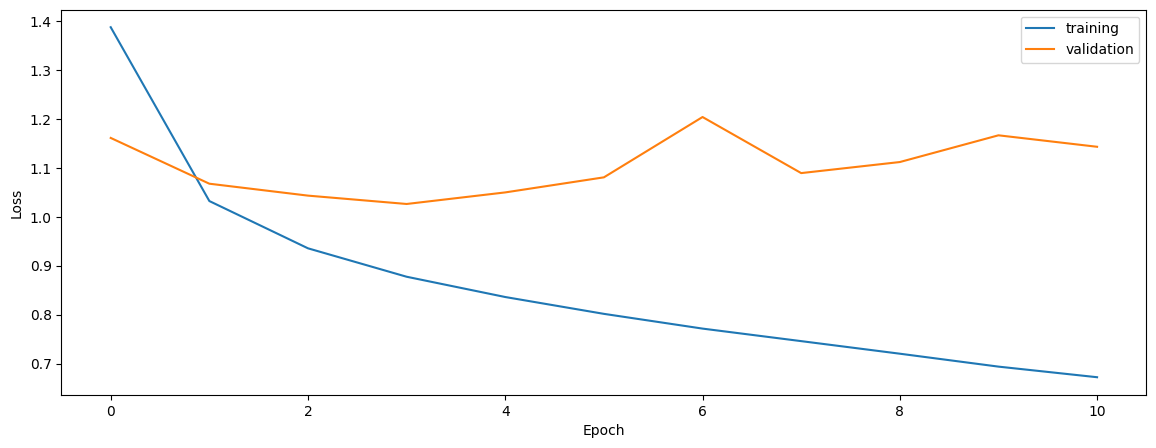

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6755027746722743
0.6020127319401134
0.6263473783097318


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6191406190584835
0.6123063683304647
0.5830024868024956


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6178910105682024
0.6056771922103642
0.5831912071252605


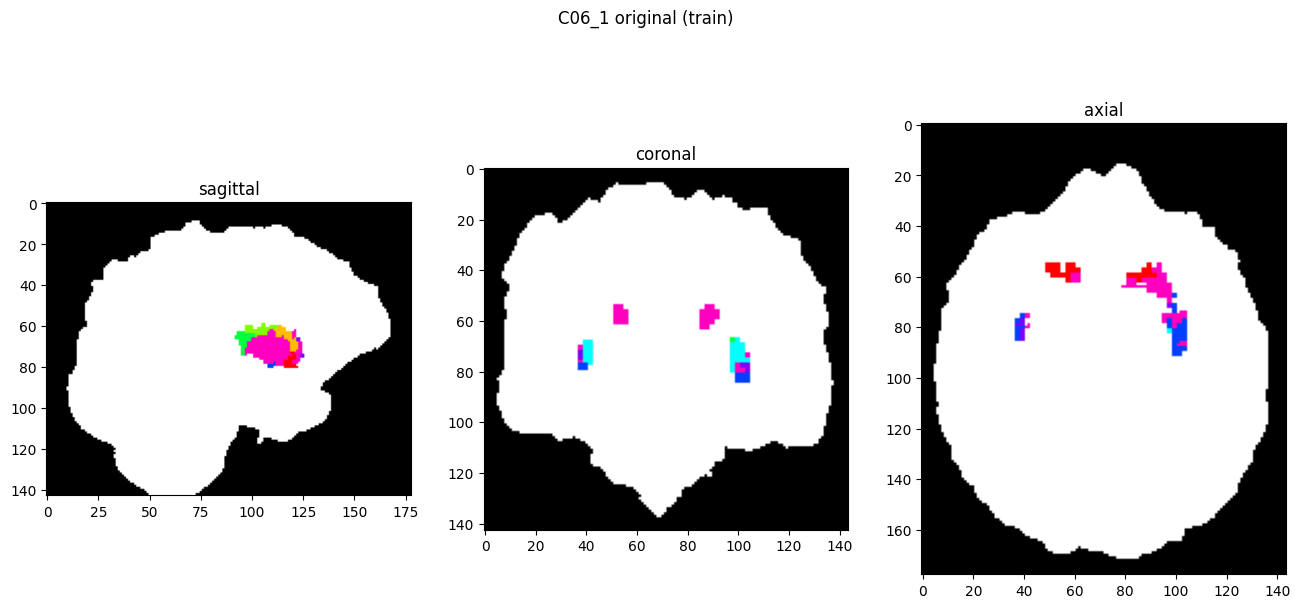

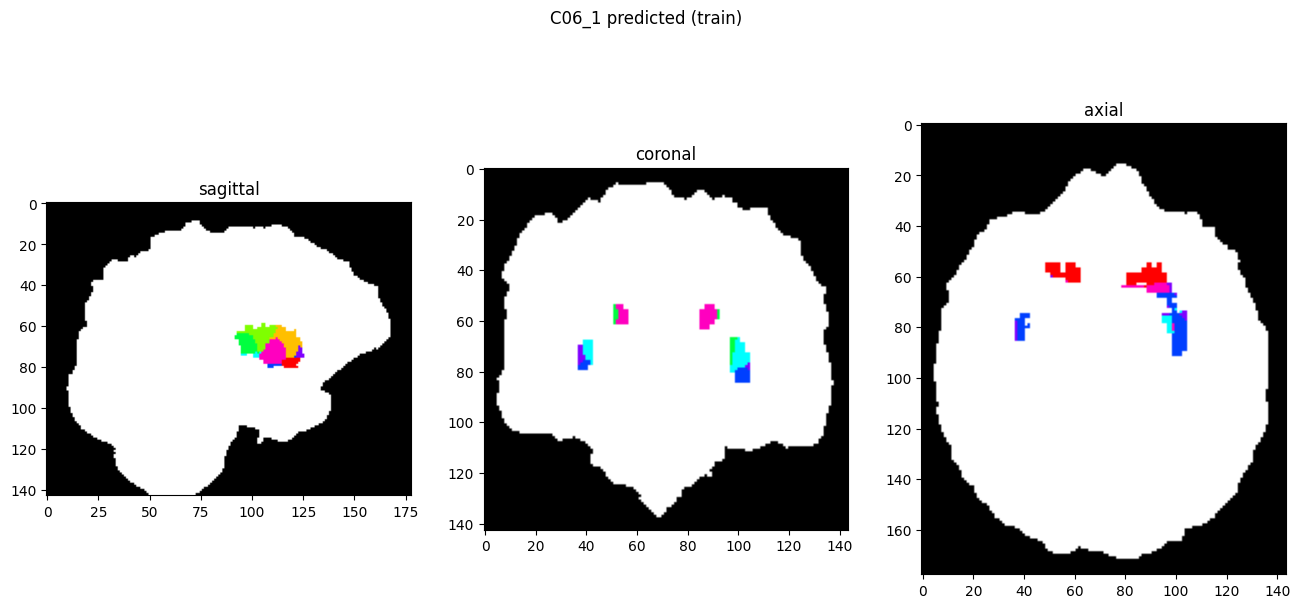

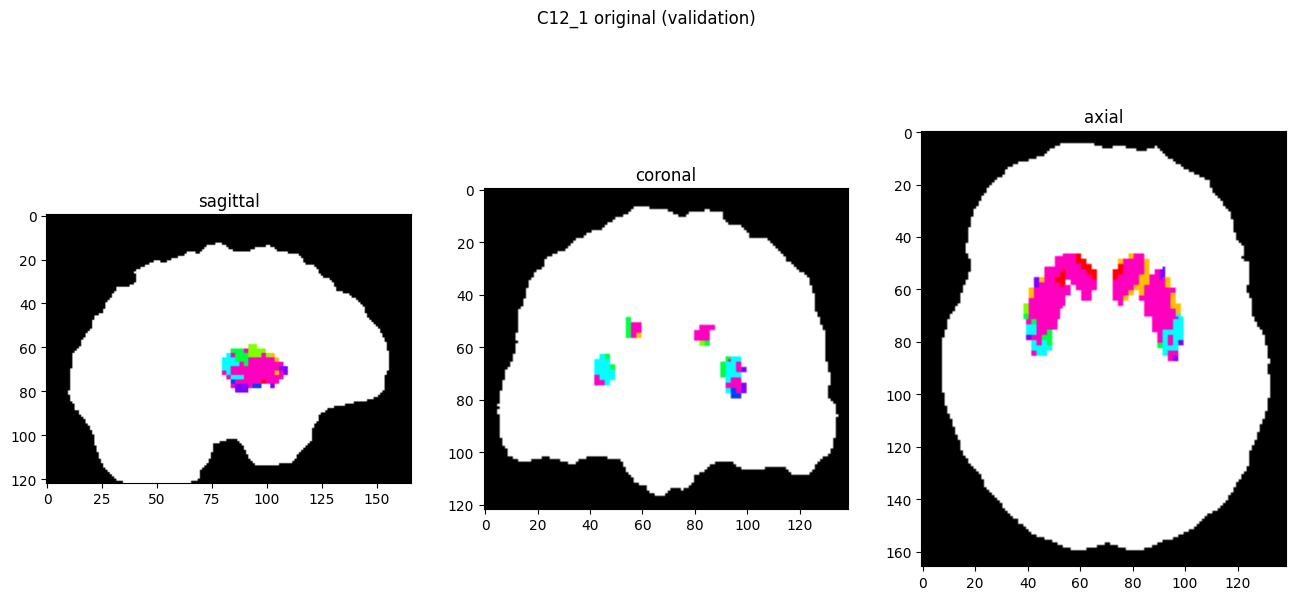

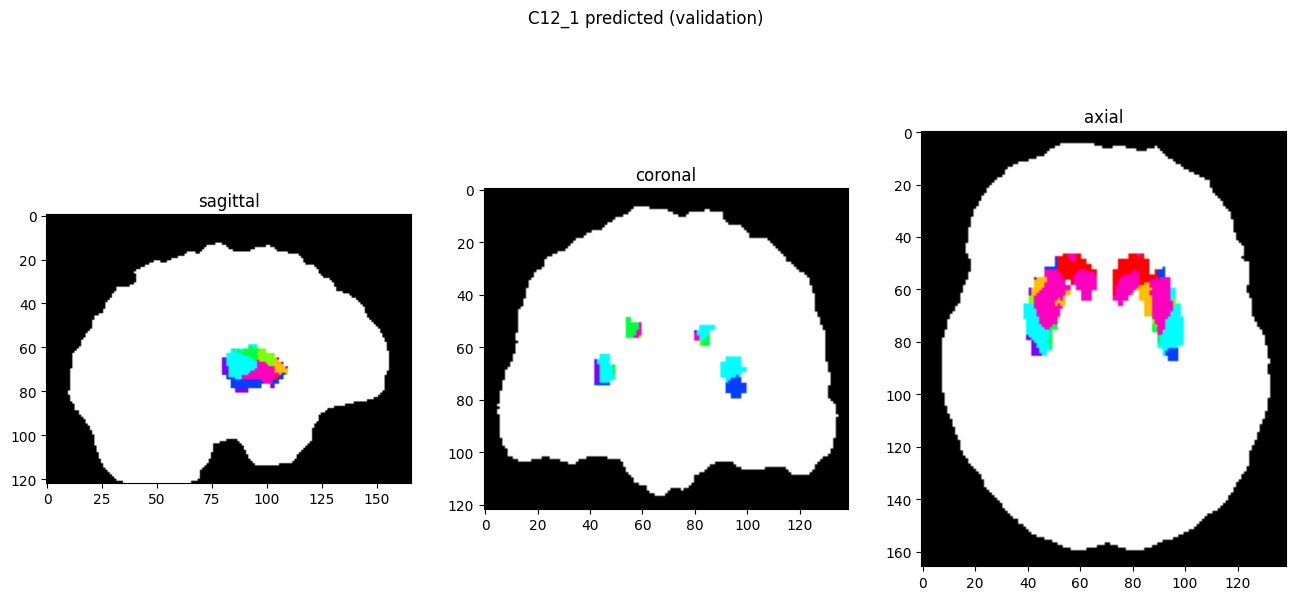

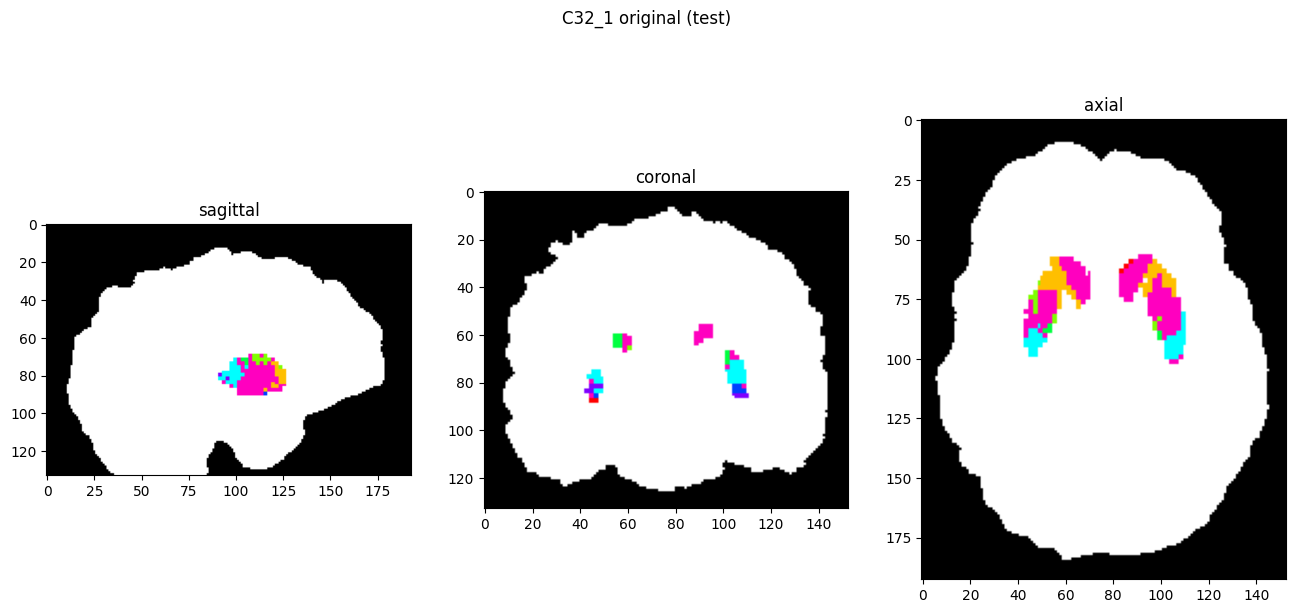

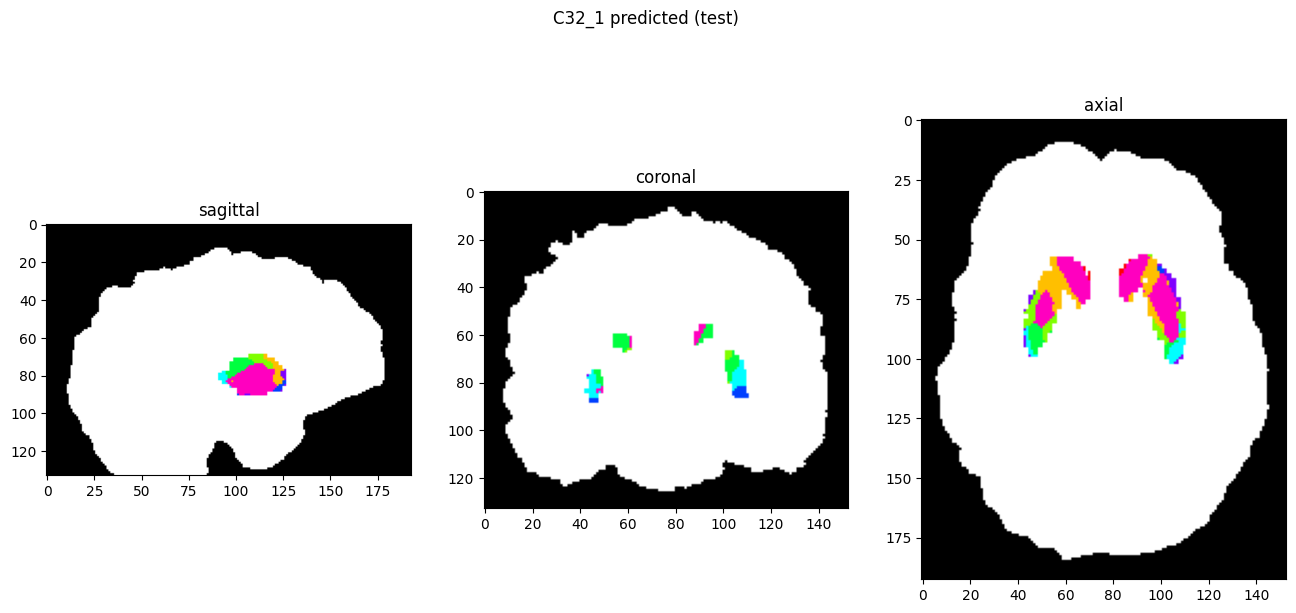

In [10]:
showResults(model, gen, threshold=0)